### 1.0: Environment

#### 1.1: Imports

In [52]:
# --- Imports ---
import pandas as pd
import numpy as np
import urllib.parse
import datetime as dt
import requests
import psycopg2
import sys
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
sns.set_style('darkgrid', {'legend.frameon':True})

from secret import *
from sshtunnel import SSHTunnelForwarder
import dill as pickle

import random
import scipy
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
# --- Imports ---

#### 1.2: Constants

In [108]:
# --- Constants ---
# Weather Variables in parsed format (See https://open-meteo.com/en/docs#api-documentation)
hourly_weather_variables = {
    'temperature' : ['temperature_2m', 'dewpoint_2m', 'apparent_temperature'],
    'humidity' : ['relativehumidity_2m'],
    'pressure' : ['pressure_msl', 'surface_pressure'],
    'clouds' : ['cloudcover', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_high'],
    'wind' : ['windspeed_10m', 'windspeed_80m', 'windspeed_120m', 'windspeed_180m', 'winddirection_10m', 'winddirection_80m', 'winddirection_120m', 'winddirection_180m', 'windgusts_10m'],
    'radiation' : ['shortwave_radiation', 'direct_radiation', 'direct_normal_irradiance', 'diffuse_radiation'],
    'energy' : ['vapor_pressure_deficit', 'cape', 'evapotranspiration', 'et0_fao_evapotranspiration'],
    'precipitation' : ['precipitation', 'snowfall', 'precipitation_probability', 'rain', 'showers'],
    'weather' : ['weathercode'],
    'snow' : ['snow_depth', 'freezinglevel_height'],
    'visibility' : ['visibility'],
    'soil' : ['soil_wind_0cm', 'soil_temperature_6cm', 'soil_temperature_18cm', 'soil_temperature_54cm', 'soil_moisture_0_1cm', 'soil_moisture_1_3cm', 'soil_moisture_3_9cm', 'soil_moisture_9_27cm', 'soil_moisture_27_81cm']
}
daily_weather_variables = {
    'temperature' : ['temperature_2m_max', 'temperature_2m_min', 'apparent_temperature_max', 'apparent_temperature_min'],
    'precipitation' : ['precipitation_sum', 'rain_sum', 'showers_sum', 'snowfall_sum', 'precipitation_hours', 'precipitation_probability_max', 'precipitation_probability_min', 'precipitation_probability_mean'],
    'weather' : ['weathercode', 'sunrise', 'sunset'],
    'wind' : ['windspeed_10m_max', 'windgusts_10m_max', 'winddirection_10m_dominant'],
    'radiation' : ['shortwave_radiation_sum'],
    'energy' : ['et0_fao_evapotranspiration'],
    'uv' : ['uv_index_max', 'uv_index_clear_sky_max']
}

TSO_COUNTRIES = {
#"SK" : "Slovakia",
"DK" : "Denmark",
#"LT" : "Lithuania",
# "SI" : "Slovenia",
# "CZ" : "Czech Republic",
 "FR" : "France",
# "LV" : "Latvia",
# "RO" : "Romania",
 "NL" : "Netherlands",
# "EE" : "Estonia",
# "HU" : "Hungary",
 "AT" : "Austria",
# "FI" : "Finland",
# "PL" : "Poland",
 "ES" : "Spain",
 "PT" : "Portugal",
# "NO" : "Norway",
# "BG" : "Bulgaria",
 "IT" : "Italy",
# "HR" : "Croatia",
# "SE" : "Sweden",
# "GR" : "Greece",
# "CH" : "Switzerland",
 "BE" : "Belgium",
 "DE" : "Germany"
}

# Regions are North Western Europe, mediterranean, eastern, western, baltic, central, southern, scandinavia
LOCATIONS = [
    # Slovakia (SK)
    {"city": "Banská Bystrica", "coordinates": (48.733918, 19.146621), "country": "SK", "region": "Eastern Europe"},
    {"city": "Nitra", "coordinates": (48.309100, 18.087312), "country": "SK", "region": "Eastern Europe"},
    {"city" : "Bratislava", "coordinates": (48.148598, 17.107748), "country": "SK", "region": "Eastern Europe", "primary" : True},
    {"city" : "Košice", "coordinates": (48.720595, 21.257698), "country": "SK", "region": "Eastern Europe", "primary" : True},
    # Denmark (DK)
    {"city": "Odense", "coordinates": (55.403756, 10.402370), "country": "DK", "region": "North Western Europe"},
    {"city": "Esbjerg", "coordinates": (55.476466, 8.459405), "country": "DK", "region": "North Western Europe"},
    {"city" : "Copenhagen", "coordinates": (55.676097, 12.568337), "country": "DK", "region": "North Western Europe", "primary" : True},
    {"city" : "Aarhus", "coordinates": (56.162939, 10.203921), "country": "DK", "region": "North Western Europe", "primary" : True},
    
     # Lithuania (LT)
    {"city": "Klaipėda", "coordinates": (55.703295, 21.144279), "country": "LT", "region": "Baltic"},
    {"city": "Šiauliai", "coordinates": (55.934001, 23.315206), "country": "LT", "region": "Baltic"},
    {"city" : "Vilnius", "coordinates": (54.687157, 25.279652), "country": "LT", "region": "Baltic", "primary" : True},
    {"city" : "Kaunas", "coordinates": (54.898521, 23.903597), "country": "LT", "region": "Baltic", "primary" : True},
    
    # Slovenia (SI)
    {"city": "Koper", "coordinates": (45.548059, 13.730188), "country": "SI", "region": "Central Europe"},
    {"city": "Celje", "coordinates": (46.230529, 15.260840), "country": "SI", "region": "Central Europe"},
    {"city" : "Ljubljana", "coordinates": (46.056946, 14.505751), "country": "SI", "region": "Central Europe", "primary" : True},
    {"city" : "Maribor", "coordinates": (46.554650, 15.646049), "country": "SI", "region": "Central Europe", "primary" : True},
    
        # Czech Republic (CZ)
    {"city": "Ostrava", "coordinates": (49.820923, 18.262524), "country": "CZ", "region": "Central Europe"},
    {"city": "Plzeň", "coordinates": (49.738431, 13.373637), "country": "CZ", "region": "Central Europe"},
    {"city" : "Prague", "coordinates": (50.075539, 14.437800), "country": "CZ", "region": "Central Europe", "primary" : True},
    {"city" : "Brno", "coordinates": (49.195060, 16.606837), "country": "CZ", "region": "Central Europe", "primary" : True},
    
        # France (FR)
    {"city": "Lyon", "coordinates": (45.750000, 4.850000), "country": "FR", "region": "Mediterranean"},
    {"city": "Toulouse", "coordinates": (43.604652, 1.444209), "country": "FR", "region": "Mediterranean"},
    {"city" : "Paris", "coordinates": (48.856614, 2.352222), "country": "FR", "region": "Mediterranean", "primary" : True},
    {"city" : "Marseille", "coordinates": (43.296482, 5.369780), "country": "FR", "region": "Mediterranean", "primary" : True},
    
        # Latvia (LV)
    {"city": "Liepāja", "coordinates": (56.504667, 21.010806), "country": "LV", "region": "Baltic"},
    {"city": "Jūrmala", "coordinates": (56.971391, 23.770651), "country": "LV", "region": "Baltic"},
    {"city" : "Riga", "coordinates": (56.949649, 24.105186), "country": "LV", "region": "Baltic", "primary" : True},
    {"city" : "Daugavpils", "coordinates": (55.874296, 26.536963), "country": "LV", "region": "Baltic", "primary" : True},
    
    # Romania (RO)
    {"city": "Timișoara", "coordinates": (45.748872, 21.208679), "country": "RO", "region": "Eastern Europe"},
    {"city": "Iași", "coordinates": (47.158455, 27.601442), "country": "RO", "region": "Eastern Europe"},
    {"city" : "Bucharest", "coordinates": (44.426765, 26.102537), "country": "RO", "region": "Eastern Europe", "primary" : True},
    {"city" : "Cluj-Napoca", "coordinates": (46.771210, 23.623635), "country": "RO", "region": "Eastern Europe", "primary" : True},
    
    # Netherlands (NL)
    {"city": "Utrecht", "coordinates": (52.090737, 5.121420), "country": "NL", "region": "North Western Europe"},
    {"city": "Groningen", "coordinates": (53.219383, 6.566502), "country": "NL", "region": "North Western Europe"},
    {"city" : "Amsterdam", "coordinates": (52.370216, 4.895168), "country": "NL", "region": "North Western Europe", "primary" : True},
    {"city" : "Rotterdam", "coordinates": (51.920179, 4.481774), "country": "NL", "region": "North Western Europe", "primary" : True},
    
    # Estonia (EE)
    {"city": "Pärnu", "coordinates": (58.385888, 24.497115), "country": "EE", "region": "Baltic"},
    {"city": "Narva", "coordinates": (59.377222, 28.190278), "country": "EE", "region": "Baltic"},
    {"city" : "Tallinn", "coordinates": (59.436962, 24.753574), "country": "EE", "region": "Baltic", "primary" : True},
    {"city" : "Tartu", "coordinates": (58.380624, 26.725056), "country": "EE", "region": "Baltic", "primary" : True},
    
    # Hungary (HU)
    {"city": "Szeged", "coordinates": (46.253010, 20.141425), "country": "HU", "region": "Central Europe"},
    {"city": "Pécs", "coordinates": (46.076831, 18.228116), "country": "HU", "region": "Central Europe"},
    {"city" : "Budapest", "coordinates": (47.497913, 19.040236), "country": "HU", "region": "Central Europe", "primary" : True},
    {"city" : "Debrecen", "coordinates": (47.531604, 21.627312), "country": "HU", "region": "Central Europe", "primary" : True},
    
    # Austria (AT)
    {"city": "Linz", "coordinates": (48.306940, 14.285830), "country": "AT", "region": "Central Europe"},
    {"city": "Salzburg", "coordinates": (47.809490, 13.055010), "country": "AT", "region": "Central Europe"},
    {"city" : "Vienna", "coordinates": (48.208176, 16.373819), "country": "AT", "region": "Central Europe", "primary" : True},
    {"city" : "Graz", "coordinates": (47.070714, 15.439504), "country": "AT", "region": "Central Europe", "primary" : True},
    
    # Finland (FI)
    {"city": "Tampere", "coordinates": (61.498150, 23.760953), "country": "FI", "region": "Scandinavia"},
    {"city": "Oulu", "coordinates": (65.012089, 25.465077), "country": "FI", "region": "Scandinavia"},
    {"city" : "Helsinki", "coordinates": (60.169856, 24.938379), "country": "FI", "region": "Scandinavia", "primary" : True},
    {"city" : "Turku", "coordinates": (60.451810, 22.266630), "country": "FI", "region": "Scandinavia", "primary" : True},
    
    # Poland (PL)
    {"city": "Kraków", "coordinates": (50.064650, 19.944980), "country": "PL", "region": "Central Europe"},
    {"city": "Wrocław", "coordinates": (51.107885, 17.038538), "country": "PL", "region": "Central Europe"},
    {"city" : "Warsaw", "coordinates": (52.229676, 21.012229), "country": "PL", "region": "Central Europe", "primary" : True},
    {"city" : "Lodz", "coordinates": (51.759250, 19.455983), "country": "PL", "region": "Central Europe", "primary" : True},
    
    # Spain (ES)
    {"city": "Valencia", "coordinates": (39.469750, -0.377390), "country": "ES", "region": "Mediterranean"},
    {"city": "Seville", "coordinates": (37.388630, -5.982330), "country": "ES", "region": "Mediterranean"},
    {"city" : "Madrid", "coordinates": (40.416775, -3.703790), "country": "ES", "region": "Mediterranean", "primary" : True},
    {"city" : "Barcelona", "coordinates": (41.385064, 2.173403), "country": "ES", "region": "Mediterranean", "primary" : True},
    
    # Portugal (PT)
    {"city": "Braga", "coordinates": (41.545449, -8.426507), "country": "PT", "region": "Mediterranean"},
    {"city": "Coimbra", "coordinates": (40.203316, -8.410257), "country": "PT", "region": "Mediterranean"},
    {"city" : "Lisbon", "coordinates": (38.722252, -9.139337), "country": "PT", "region": "Mediterranean", "primary" : True},
    {"city" : "Porto", "coordinates": (41.157944, -8.629105), "country": "PT", "region": "Mediterranean", "primary" : True},
    
    # Norway (NO)
    {"city": "Stavanger", "coordinates": (58.969975, 5.733107), "country": "NO", "region": "Scandinavia"},
    {"city": "Trondheim", "coordinates": (63.430515, 10.395053), "country": "NO", "region": "Scandinavia"},
    {"city" : "Oslo", "coordinates": (59.913869, 10.752245), "country": "NO", "region": "Scandinavia", "primary" : True},
    {"city" : "Bergen", "coordinates": (60.392050, 5.322050), "country": "NO", "region": "Scandinavia", "primary" : True},
    
    # Bulgaria (BG)
    {"city": "Varna", "coordinates": (43.214050, 27.914733), "country": "BG", "region": "Balkans"},
    {"city": "Burgas", "coordinates": (42.504793, 27.462636), "country": "BG", "region": "Balkans"},
    {"city" : "Sofia", "coordinates": (42.697708, 23.321868), "country": "BG", "region": "Balkans", "primary" : True},
    {"city" : "Plovdiv", "coordinates": (42.135407, 24.745290), "country": "BG", "region": "Balkans", "primary" : True},
    
    # Italy (IT)
    {"city": "Naples", "coordinates": (40.852160, 14.268110), "country": "IT", "region": "Mediterranean"},
    {"city": "Turin", "coordinates": (45.070312, 7.686856), "country": "IT", "region": "Mediterranean"},
    {"city" : "Rome", "coordinates": (41.902782, 12.496366), "country": "IT", "region": "Mediterranean", "primary" : True},
    {"city" : "Milan", "coordinates": (45.464204, 9.189982), "country": "IT", "region": "Mediterranean", "primary" : True},
    
    # Croatia (HR)
    {"city": "Rijeka", "coordinates": (45.327063, 14.442176), "country": "HR", "region": "Mediterranean"},
    {"city": "Osijek", "coordinates": (45.554962, 18.695514), "country": "HR", "region": "Mediterranean"},
    {"city" : "Zagreb", "coordinates": (45.815011, 15.981919), "country": "HR", "region": "Balkans", "primary" : True},
    {"city" : "Split", "coordinates": (43.508132, 16.440193), "country": "HR", "region": "Balkans", "primary" : True},
    
    # Sweden (SE)
    {"city": "Uppsala", "coordinates": (59.858564, 17.638927), "country": "SE", "region": "Scandinavia"},
    {"city": "Malmö", "coordinates": (55.604981, 13.003822), "country": "SE", "region": "Scandinavia"},
    {"city" : "Stockholm", "coordinates": (59.329323, 18.068581), "country": "SE", "region": "Scandinavia", "primary" : True},
    {"city" : "Gothenburg", "coordinates": (57.708870, 11.974560), "country": "SE", "region": "Scandinavia", "primary" : True},
    
    # Greece (GR)
    {"city": "Thessaloniki", "coordinates": (40.640063, 22.944419), "country": "GR", "region": "Mediterranean"},
    {"city": "Heraklion", "coordinates": (35.338735, 25.144213), "country": "GR", "region": "Mediterranean"},
    {"city" : "Athens", "coordinates": (37.983810, 23.727539), "country": "GR", "region": "Balkans", "primary" : True},
    {"city" : "Thessaloniki", "coordinates": (40.640060, 22.944420), "country": "GR", "region": "Balkans", "primary" : True},
    
    # Switzerland (CH)
    {"city" : "Zürich", "coordinates": (47.376887, 8.541694), "country": "CH", "region": "Central Europe", "primary" : True},
    {"city" : "Geneva", "coordinates": (46.204391, 6.143158), "country": "CH", "region": "Central Europe", "primary" : True},
    
    # Belgium (BE)
    {"city": "Antwerp", "coordinates": (51.219448, 4.402464), "country": "BE", "region": "North Western Europe"},
    {"city": "Liège", "coordinates": (50.633731, 5.567496), "country": "BE", "region": "North Western Europe"},
    {"city" : "Brussels", "coordinates": (50.850340, 4.351710), "country": "BE", "region": "North Western Europe", "primary" : True},
    {"city" : "Antwerp", "coordinates": (51.219448, 4.402464), "country": "BE", "region": "North Western Europe", "primary" : True},
    
    # Germany (DE)
    {"city": "Hamburg", "coordinates": (53.551085, 9.993682), "country": "DE", "region": "Central Europe"},
    {"city": "Munich", "coordinates": (48.135124, 11.581981), "country": "DE", "region": "Central Europe"},
    {"city" : "Berlin", "coordinates": (52.520007, 13.404954), "country": "DE", "region": "North Western Europe", "primary" : True},
    {"city" : "Hamburg", "coordinates": (53.551086, 9.993682), "country": "DE", "region": "North Western Europe", "primary" : True},
]

W_VARIABLES = {
    'daily' : ['temperature_2m_max', 'temperature_2m_min', 'windspeed_10m_max', 'windgusts_10m_max'],
    #'hourly' : ['temperature_2m', 'windspeed_10m','windspeed_100m', 'windgusts_10m']
}

START_DATE = dt.date(2000,1,1)
END_DATE = dt.date(2023,6,1)

SEED = 10
random.seed(SEED)

Update locations, based on the TSO_COUNTRIES

In [122]:
# Update locations, based on the TSO_COUNTRIES
LOCATIONS = [location for location in LOCATIONS if location['country'] in TSO_COUNTRIES]
# Print out the cities in new locations
LOCATIONS = [location for location in LOCATIONS if location.get('primary', None) == True]
print([location['city'] for location in LOCATIONS])

['Copenhagen', 'Aarhus', 'Paris', 'Marseille', 'Amsterdam', 'Rotterdam', 'Vienna', 'Graz', 'Madrid', 'Barcelona', 'Lisbon', 'Porto', 'Rome', 'Milan', 'Brussels', 'Antwerp', 'Berlin', 'Hamburg']


#### 1.3: Data Retrieval Functions

##### 1.3.1: Weather

In [135]:
# --- Weather Retrieval Functions --- #
import time
# Base OpenMeteo API call
def obtain_openmeteo_historical(start : dt.date, end : dt.date, lat : float, lon : float, weather_variables : dict) -> pd.DataFrame:
    url = "https://archive-api.open-meteo.com/v1/archive"
    hourly_params = weather_variables.get('hourly', [])
    daily_params = weather_variables.get('daily', [])
    params = {'latitude' : lat, 
              'longitude' : lon, 
              'start_date' : start.strftime('%Y-%m-%d'), 
              'end_date' : end.strftime('%Y-%m-%d'), 
              'hourly' : ','.join(hourly_params),
              'daily' : ','.join(daily_params),
              'timezone' : 'UTC'
              }
    try:
        response = requests.get(url, params=urllib.parse.urlencode(params, safe = ','))
        print(response.url)
        data = response.json()
        # Daily Data
        if 'daily' in data:
            daily = pd.DataFrame(data['daily'])
            daily['time'] = pd.to_datetime(daily['time'], format='%Y-%m-%dT%H:%M')
            daily['latitude'] = lat
            daily['longitude'] = lon
        else:
            daily = None
        # Hourly Data
        if 'hourly' in data:
            hourly = pd.DataFrame(data['hourly'])
            hourly['time'] = pd.to_datetime(hourly['time'], format='%Y-%m-%dT%H:%M')
            hourly['latitude'] = lat
            hourly['longitude'] = lon
        else:
            hourly = None      
            
        if 'error' in data:
            print(f"OpenMeteo API error: {data['reason']}")
            time.sleep(30)
            return obtain_openmeteo_historical(start, end, lat, lon, weather_variables)
        
        return daily, hourly
    except Exception as e:
        print(f"Failed to retrieve weather data from OpenMeteo API for ({lat}-{lon}) between {start.strftime('%Y-%m-%d')}-{end.strftime('%Y-%m-%d')}: {e}")
    
# Request an array of locations using OpenMeteo API
def obtain_openmeteo_historical_array(start : dt.date, end : dt.date, locations_array : list, weather_variables : dict) -> pd.DataFrame:
    daily, hourly = [], []
    for location in locations_array:
        print(location['city'], location['country'])
        lat, lon = location['coordinates']
        # Get rest of location data (e.g. name, elevation, etc.)
        location_metadata = {k:v for k,v in location.items() if k != 'coordinates'}
        daily_data, hourly_data = obtain_openmeteo_historical(start, end, lat, lon, weather_variables)
        if daily_data is not None:
            daily_data = daily_data.assign(**location_metadata)
            daily.append(daily_data)
        if hourly_data is not None:
            hourly_data = hourly_data.assign(**location_metadata)
            hourly.append(hourly_data)
    return pd.concat(daily), pd.concat(hourly)
# --- Weather Retrieval Functions --- #

##### 1.3.2: Database Connection

In [488]:
# --- Database Retrieval Functions (SSH) ---
def load_connection(user: str,password: str,host: str,database: str, port):
    pg_connection_dict = {
    'dbname': database,
    'user': user,
    'password': password,
    'port': port,
    'host': host
    }
    keepalive_kwargs = {"keepalives": 1,"keepalives_idle": 250,"keepalives_interval": 5,"keepalives_count": 5}
    try:
        connection = psycopg2.connect(**pg_connection_dict, **keepalive_kwargs)
        return connection
    except(Exception, EnvironmentError) as e:
        raise Exception ("Error in connection, }".format(e))
        
def load_query(connection, query) -> pd.DataFrame:
    try:
        cursor = connection.cursor()
        cursor.execute(query) 
        record = cursor.fetchall()
        # Convert to pandas
        df_record = pd.DataFrame.from_records(record, columns =[x[0] for x in cursor.description])
        return df_record

    except(Exception,EnvironmentError) as e:
        raise Exception ("Error while fetching data from postgres, }".format(e))
    finally:
        # Close connection
        if(connection):
            cursor.close()
# --- Database Retrieval Functions (SSH) ---

##### 1.3.3: Database functions

In [46]:
server = SSHTunnelForwarder(
    (REMOTE_HOST, 22),
    ssh_username=REMOTE_USER,
    ssh_password=REMOTE_PASS,
    remote_bind_address=('localhost', DB_PORT)
)

# Create data retrieval functions
def get_hourly_entsoe_generation_production(start_date, end_date,country_list):
    query = f"""
    SELECT 
    date_trunc('hour', datetime_start_utc) AS "timestamp", 
    price_area, 
    country_code,
    AVG(biomass) AS biomass,
    AVG(fossil_brown_coal_lignite) AS fossil_brown_coal_lignite,
    AVG(fossil_coal_derived_gas) AS fossil_coal_derived_gas,
    AVG(fossil_gas) AS fossil_gas,
    AVG(fossil_hard_coal) AS fossil_hard_coal,
    AVG(fossil_oil) AS fossil_oil,
    AVG(geothermal) AS geothermal,
    AVG(hydro_pumped_storage) AS hydro_pumped_storage,
    AVG(hydro_run_of_river_and_poundage) AS hydro_run_of_river_and_poundage,
    AVG(hydro_water_reservoir) AS hydro_water_reservoir,
    AVG(nuclear) AS nuclear,
    AVG(other) AS other,
    AVG(other_renewable) AS other_renewable,
    AVG(solar) AS solar,
    AVG(waste) AS waste, 
    AVG(wind_offshore) AS wind_offshore,
    AVG(wind_onshore) AS wind_onshore
    FROM scraper.entsoe_generation_production
    WHERE country_code IN ('{"','".join(country_list)}')
    AND "datetime_start_utc" BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY "timestamp","price_area", "country_code"
    ORDER BY "timestamp"
    """
    server.start()
    connection = load_connection(user=DB_USER, password=DB_PASS, host='localhost', database = 'raw', port = server.local_bind_port)
    df = load_query(connection, query)
    server.stop()
    return df

def get_hourly_entsoe_day_ahead_forecast(start_date, end_date,country_list):
    query = f"""
    SELECT 
    date_trunc('hour', datetime_start_utc) AS "timestamp", 
    price_area, 
    country_code,
    AVG(solar) AS solar,
    AVG(wind_offshore) AS wind_offshore,
    AVG(wind_onshore) AS wind_onshore,
    AVG(forecasted_load) AS forecasted_load,
    AVG(actual_aggregated) AS actual_aggregated
    FROM scraper.entsoe_da_forecast
    WHERE country_code IN ('{"','".join(country_list)}')
    AND "datetime_start_utc" BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY "timestamp","price_area", "country_code"
    ORDER BY "timestamp"
    """
    server.start()
    connection = load_connection(user=DB_USER, password=DB_PASS, host='localhost', database = 'raw', port = server.local_bind_port)
    df = load_query(connection, query)
    server.stop()
    return df


def get_yearly_capacity_old():
    query = f"""
    SELECT 
    eic.country_code,
    eic.price_area,
    EXTRACT(year FROM eic.datetime_start_utc) AS year,
    (eic.biomass) AS biomass_capacity,
    (eic.fossil_brown_coal_lignite) AS fossil_brown_coal_lignite_capacity,
    (eic.fossil_coal_derived_gas) AS fossil_coal_derived_gas_capacity,
    (eic.fossil_gas) AS fossil_gas_capacity,
    (eic.fossil_hard_coal) AS fossil_hard_coal_capacity,
    (eic.fossil_oil) AS fossil_oil_capacity,
    (eic.geothermal) AS geothermal_capacity,
    (eic.hydro_pumped_storage) AS hydro_pumped_storage_capacity,
    (eic.hydro_run_of_river_and_poundage) AS hydro_run_of_river_and_poundage_capacity,
    (eic.hydro_water_reservoir) AS hydro_water_reservoir_capacity,
    (eic.nuclear) AS nuclear_capacity,
    (eic.other) AS other_capacity,
    (eic.other_renewable) AS other_renewable_capacity,
    (eic.solar) AS solar_capacity,
    (eic.waste) AS waste_capacity,
    (eic.wind_offshore) AS wind_offshore_capacity,
    (eic.wind_onshore) AS wind_onshore_capacity
    FROM 
    scraper.entsoe_installed_capacity eic
    """
    server.start()
    connection = load_connection(user=DB_USER, password=DB_PASS, host='localhost', database = 'raw', port = server.local_bind_port)
    df = load_query(connection, query)
    server.stop()
    return df

def get_yearly_capacity():
    query = f"""
    SELECT 
    egp.*,
    (eic.biomass) AS biomass_capacity,
    (eic.fossil_brown_coal_lignite) AS fossil_brown_coal_lignite_capacity,
    (eic.fossil_coal_derived_gas) AS fossil_coal_derived_gas_capacity,
    (eic.fossil_gas) AS fossil_gas_capacity,
    (eic.fossil_hard_coal) AS fossil_hard_coal_capacity,
    (eic.fossil_oil) AS fossil_oil_capacity,
    (eic.geothermal) AS geothermal_capacity,
    (eic.hydro_pumped_storage) AS hydro_pumped_storage_capacity,
    (eic.hydro_run_of_river_and_poundage) AS hydro_run_of_river_and_poundage_capacity,
    (eic.hydro_water_reservoir) AS hydro_water_reservoir_capacity,
    (eic.nuclear) AS nuclear_capacity,
    (eic.other) AS other_capacity,
    (eic.other_renewable) AS other_renewable_capacity,
    (eic.solar) AS solar_capacity,
    (eic.waste) AS waste_capacity,
    (eic.wind_offshore) AS wind_offshore_capacity,
    (eic.wind_onshore) AS wind_onshore_capacity
    FROM 
    scraper.entsoe_installed_capacity eic
    JOIN
    (
    SELECT
    EXTRACT(year FROM datetime_start_utc) AS year,
    country_code,
    price_area,
    AVG(biomass) AS biomass_generation,
    AVG(fossil_brown_coal_lignite) AS fossil_brown_coal_lignite_generation,
    AVG(fossil_coal_derived_gas) AS fossil_coal_derived_gas_generation,
    AVG(fossil_gas) AS fossil_gas_generation,
    AVG(fossil_hard_coal) AS fossil_hard_coal_generation,
    AVG(fossil_oil) AS fossil_oil_generation,
    AVG(geothermal) AS geothermal_generation,
    AVG(hydro_pumped_storage) AS hydro_pumped_storage_generation,
    AVG(hydro_run_of_river_and_poundage) AS hydro_run_of_river_and_poundage_generation,
    AVG(hydro_water_reservoir) AS hydro_water_reservoir_generation,
    AVG(nuclear) AS nuclear_generation,
    AVG(other) AS other_generation,
    AVG(other_renewable) AS other_renewable_generation,
    AVG(solar) AS solar_generation,
    AVG(waste) AS waste_generation,
    AVG(wind_offshore) AS wind_offshore_generation,
    AVG(wind_onshore) AS wind_onshore_generation
    FROM
    scraper.entsoe_generation_production
    GROUP BY country_code, price_area, year
    ) egp
    ON 
    EXTRACT(year FROM eic.datetime_start_utc)  = egp.year
    AND
    eic.price_area=egp.price_area
    """
    server.start()
    connection = load_connection(user=DB_USER, password=DB_PASS, host='localhost', database = 'raw', port = server.local_bind_port)
    df = load_query(connection, query)
    server.stop()
    return df

def get_hourly_entsoe_day_ahead_prices(start_date, end_date,country_list):
    query = f"""
    SELECT 
    date_trunc('hour', datetime_start_utc) AS "timestamp", 
    price_area, 
    country_code,
    AVG(price) AS price
    FROM scraper.entsoe_da_prices
    WHERE country_code IN ('{"','".join(country_list)}')
    AND "datetime_start_utc" BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY "timestamp","price_area", "country_code"
    ORDER BY "timestamp"
    """
    server.start()
    connection = load_connection(user=DB_USER, password=DB_PASS, host='localhost', database = 'raw', port = server.local_bind_port)
    df = load_query(connection, query)
    server.stop()
    return df

def get_unit_generation_plants():
    query = f"""
    SELECT 
    DISTINCT
    egu.plant_type,
    eec.eic_long_name,
    egu.country_code,
    egu.eic_code eic_code
    FROM 
    scraper.entsoe_generation_unit egu
    LEFT JOIN
    scraper.entsoe_eic_codes eec
    ON
    egu.eic_code=eec.eic_code
    WHERE egu.datetime_start_utc BETWEEN '2023-01-01' AND '2023-01-10'
    AND generation > 0
    """
    server.start()
    connection = load_connection(user=DB_USER, password=DB_PASS, host='localhost', database = 'raw', port = server.local_bind_port)
    df = load_query(connection, query)
    server.stop()
    return df


def get_hourly_entsoe_unit_generation(start_date, end_date, code_list):
    query = f"""
    SELECT 
    date_trunc('hour',egu.datetime_start_utc) AS "timestamp",
    egu.plant_type,
    egu.plant_label,
    egu.country_code,
    egu.price_area,
    egu.eic_code,
    AVG(egu.generation) AS generation
    FROM 
    scraper.entsoe_generation_unit egu
    WHERE egu.datetime_start_utc BETWEEN '{start_date}' AND '{end_date}'
    AND egu.eic_code IN ('{"','".join(code_list)}')
    GROUP BY "timestamp", egu.plant_type, egu.plant_label, egu.country_code, egu.price_area, egu.eic_code
    """
    server.start()
    connection = load_connection(user=DB_USER, password=DB_PASS, host='localhost', database = 'raw', port = server.local_bind_port)
    df = load_query(connection, query)
    server.stop()
    return df

def get_weekly_crossborder(start_date, end_date):
    query = f""""
    SELECT
    date_trunc('week', "datetime_start_utc") AS "time",
    price_area_from,
    price_area_to,
    SUM(flow) AS "flow"
    FROM "scraper"."entsoe_crossborder" eod
    WWHERE datetime_start_utc BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY "time", "price_area_from",price_area_to
    ORDER BY 1,2
    """
    server.start()
    connection = load_connection(user=DB_USER, password=DB_PASS, host='localhost', database = 'raw', port = server.local_bind_port)
    df = load_query(connection, query)
    server.stop()
    return df

### 2.0: Data

#### 2.1: Weather

In [136]:
w_daily, w_hourly = obtain_openmeteo_historical_array(
    START_DATE, 
    END_DATE, 
    LOCATIONS,
    weather_variables=W_VARIABLES)

w_daily.head(5)

Copenhagen DK
https://archive-api.open-meteo.com/v1/archive?latitude=55.676097&longitude=12.568337&start_date=2000-01-01&end_date=2023-06-01&hourly=&daily=temperature_2m_max,temperature_2m_min,windspeed_10m_max,windgusts_10m_max&timezone=UTC
OpenMeteo API error: Minutely API request limit exceeded. Please try again in one minute.
https://archive-api.open-meteo.com/v1/archive?latitude=55.676097&longitude=12.568337&start_date=2000-01-01&end_date=2023-06-01&hourly=&daily=temperature_2m_max,temperature_2m_min,windspeed_10m_max,windgusts_10m_max&timezone=UTC
Aarhus DK
https://archive-api.open-meteo.com/v1/archive?latitude=56.162939&longitude=10.203921&start_date=2000-01-01&end_date=2023-06-01&hourly=&daily=temperature_2m_max,temperature_2m_min,windspeed_10m_max,windgusts_10m_max&timezone=UTC
Paris FR
https://archive-api.open-meteo.com/v1/archive?latitude=48.856614&longitude=2.352222&start_date=2000-01-01&end_date=2023-06-01&hourly=&daily=temperature_2m_max,temperature_2m_min,windspeed_10m_m

time  temperature_2m_max  temperature_2m_min  windspeed_10m_max  \
0 2000-01-01                 4.4                 1.2               19.2   
1 2000-01-02                 6.3                 1.5               25.4   
2 2000-01-03                 7.4                 3.9               26.9   
3 2000-01-04                 5.7                 2.3               25.6   
4 2000-01-05                 5.1                 2.5               22.4   

   windgusts_10m_max   latitude  longitude        city country  \
0               34.6  55.676097  12.568337  Copenhagen      DK   
1               45.7  55.676097  12.568337  Copenhagen      DK   
2               48.2  55.676097  12.568337  Copenhagen      DK   
3               43.9  55.676097  12.568337  Copenhagen      DK   
4               43.6  55.676097  12.568337  Copenhagen      DK   

                 region  primary  
0  North Western Europe     True  
1  North Western Europe     True  
2  North Western Europe     True  
3  North Western Europe     True  
4  North Western Europe     True

##### Hourly

In [113]:
# Resample the hourly weather data to daily values, such that we can use it for CARMA.
weather_df = w_hourly.groupby(['region','country', 'city', pd.Grouper(key='time', freq='D')]).agg({
    'temperature_2m': ['min', 'max'],
    'windspeed_10m': ['max'],
    'windspeed_100m' : ['max']
})
weather_df = weather_df.reset_index()
weather_df['temperature_2m_avg'] = (weather_df['temperature_2m']['min'] + weather_df['temperature_2m']['max']) / 2
# Remove leading and trailing underscores and melt to normal format
weather_df.columns = weather_df.columns.map('_'.join).str.strip('_')
# Add season to the data
weather_df['season'] = weather_df['time'].apply(lambda x: 0 if x.month in [12,1,2] else (1 if x.month in [3,4,5] else (2 if x.month in [6,7,8] else 3)))

weather_df.head(5)

KeyError: "Column(s) ['temperature_2m'] do not exist"

##### Daily

In [146]:
weather_df = w_daily
weather_df['temperature_2m_avg'] = (weather_df['temperature_2m_min'] + weather_df['temperature_2m_max']) / 2
weather_df['season'] = weather_df['time'].apply(lambda x: 0 if x.month in [12,1,2] else (1 if x.month in [3,4,5] else (2 if x.month in [6,7,8] else 3)))
weather_df.head(5)

time  temperature_2m_max  temperature_2m_min  windspeed_10m_max  \
0 2000-01-01                 4.4                 1.2               19.2   
1 2000-01-02                 6.3                 1.5               25.4   
2 2000-01-03                 7.4                 3.9               26.9   
3 2000-01-04                 5.7                 2.3               25.6   
4 2000-01-05                 5.1                 2.5               22.4   

   windgusts_10m_max   latitude  longitude        city country  \
0               34.6  55.676097  12.568337  Copenhagen      DK   
1               45.7  55.676097  12.568337  Copenhagen      DK   
2               48.2  55.676097  12.568337  Copenhagen      DK   
3               43.9  55.676097  12.568337  Copenhagen      DK   
4               43.6  55.676097  12.568337  Copenhagen      DK   

                 region  primary  temperature_2m_avg  season  
0  North Western Europe     True                2.80       0  
1  North Western Europe     True                3.90       0  
2  North Western Europe     True                5.65       0  
3  North Western Europe     True                4.00       0  
4  North Western Europe     True                3.80       0

In [138]:
weather_df[['country','city']].drop_duplicates()

country        city
0      DK  Copenhagen
0      DK      Aarhus
0      FR       Paris
0      FR   Marseille
0      NL   Amsterdam
0      NL   Rotterdam
0      AT      Vienna
0      AT        Graz
0      ES      Madrid
0      ES   Barcelona
0      PT      Lisbon
0      PT       Porto
0      IT        Rome
0      IT       Milan
0      BE    Brussels
0      BE     Antwerp
0      DE      Berlin
0      DE     Hamburg

#### 2.2: Energy

In [110]:
hourly_entsoe_day_ahead_forecast = get_hourly_entsoe_day_ahead_forecast(START_DATE, END_DATE, list(TSO_COUNTRIES.keys()))
hourly_entsoe_generation_production = get_hourly_entsoe_generation_production(START_DATE, END_DATE, list(TSO_COUNTRIES.keys()))
hourly_entsoe_day_ahead_prices = get_hourly_entsoe_day_ahead_prices(START_DATE, END_DATE, list(TSO_COUNTRIES.keys()))
hourly_entsoe_day_ahead_prices.head(5)

timestamp price_area country_code      price
0 2017-12-31 00:00:00+00:00         BE           BE  14.040000
1 2017-12-31 00:00:00+00:00   DE_AT_LU           DE  -4.990000
2 2017-12-31 00:00:00+00:00       DK_1           DK  26.440001
3 2017-12-31 00:00:00+00:00       DK_2           DK  26.440001
4 2017-12-31 00:00:00+00:00         ES           ES  19.830000

In [252]:
# Sample plants
unit_generation_plants = get_unit_generation_plants()
unit_generation_plants = unit_generation_plants[unit_generation_plants['country_code'].isin(list(TSO_COUNTRIES.keys()))]
fuel_samples = {
    'Solar': 5,
    'Wind': 10,
    'Hydro': 5,
    'Nuclear': 5,
    'Fossil Gas': 10,
    'Fossil Coal' : 5,
    'Fossil Brown coal' : 5,
    'Biomass' : 5,
    'Waste' : 5
}
sampled_plants = []
for fuel, sample_size in fuel_samples.items():
    sampled_plants += list(unit_generation_plants[unit_generation_plants['plant_type'].str.contains(fuel)].sample(sample_size, random_state = SEED, replace = True)['eic_code'])

#unit_generation_plants = unit_generation_plants[unit_generation_plants['eic_code'].isin(sampled_plants)]
unit_generation_plants.head(10)

plant_type           eic_long_name country_code  \
0                     Biomass     Amagerværket Blok 4           DK   
1                     Biomass    Avedøreværket Blok 1           DK   
2                     Biomass    Avedøreværket Blok 2           DK   
6                     Biomass              PROVENCE 4           FR   
7                     Biomass            RODENHUIZE 4           BE   
8                     Biomass    Skærbækværket Blok 3           DK   
9                     Biomass  Studstrupværket Blok 3           DK   
26  Fossil Brown coal/Lignite               Boxberg N           DE   
27  Fossil Brown coal/Lignite               Boxberg P           DE   
28  Fossil Brown coal/Lignite               Boxberg Q           DE   

            eic_code  
0   45W000000000113T  
1   45W000000000029I  
2   45W000000000030X  
6   17W100P100P03655  
7   22WRODENH150213L  
8   45W000000000031V  
9   45W000000000036L  
26  11WD8BOXB1L---N8  
27  11WD8BOXB1L---P4  
28  11WD8BOXB1L---Q2

In [255]:
sampled_plants = [
    '22WRODENH150213L',
    '49W000000000055V',
    '18W000000000H02A',
    '22W20200608D---U',
    '18W000000000NXBH',
    '49W0000000000172'
]
unit_generation_plants = unit_generation_plants[unit_generation_plants['eic_code'].isin(sampled_plants)]
unit_generation_plants

plant_type    eic_long_name country_code          eic_code
7           Biomass     RODENHUIZE 4           BE  22WRODENH150213L
172      Fossil Gas        Diemen 34           NL  49W0000000000172
969         Nuclear      Borssele 30           NL  49W000000000055V
1085          Solar     NUÑEZ BALBOA           ES  18W000000000H02A
1102  Wind Offshore          Seastar           BE  22W20200608D---U
1115   Wind Onshore  UFI P.E. GECAMA           ES  18W000000000NXBH

In [256]:
# Get the hourly generation for the sampled plants
hourly_entsoe_unit_generation = get_hourly_entsoe_unit_generation(START_DATE, END_DATE, list(unit_generation_plants['eic_code'].unique()))
hourly_entsoe_unit_generation.head(5)

timestamp  plant_type   plant_label country_code price_area  \
0 2017-12-31 00:00:00+00:00     Biomass  RODENHUIZE 4           BE         BE   
1 2017-12-31 00:00:00+00:00  Fossil Gas     Diemen 34           NL         NL   
2 2017-12-31 00:00:00+00:00     Nuclear   Borssele 30           NL         NL   
3 2017-12-31 01:00:00+00:00     Biomass  RODENHUIZE 4           BE         BE   
4 2017-12-31 01:00:00+00:00  Fossil Gas     Diemen 34           NL         NL   

           eic_code  generation  
0  22WRODENH150213L       206.0  
1  49W0000000000172         1.0  
2  49W000000000055V       488.0  
3  22WRODENH150213L       206.0  
4  49W0000000000172         0.0

#### 2.3: Other

In [19]:
farms_df = pd.read_csv(r"C:\Users\Nicky\Documents\Data\PowerPlants\thewindpower\Final\windfarms_processed_final.csv", delimiter = ',')
turbines_df = pd.read_csv(r"C:\Users\Nicky\Documents\Data\PowerPlants\thewindpower\Final\turbines_windpower_final.csv", delimiter = ',')
turbines_df.head(5)

id                        manufacturer            model  rated_power  \
0   0  China Creative Wind Energy (Chine)  CCWE-1500/87.DF         1500   
1   1             XEMC-Darwind (Pays-Bas)       XD137-4000         4000   
2   2        Guodian United Power (Chine)            UP154         6000   
3   3                   Acciona (Espagne)      AW-3000/132         3000   
4   4                   Acciona (Espagne)      AW-3000/132         3000   

   rotor_diameter  wind_class offshore  swept_area  specific_area  n_blades  \
0            87.0         NaN       no   5945.4495            NaN         3   
1           137.0      IEC II       no  14743.0495            NaN         3   
2           154.0         NaN       no  18628.9180            NaN         3   
3           132.0  IEC IIIb/S       no  13686.5520            NaN         3   
4           132.0  IEC IIIb/S       no  13686.5520            NaN         3   

   ...  voltage  hub_height  min_hub_height  max_hub_height  \
0  ...    690.0        68.5             NaN             NaN   
1  ...    900.0       100.0           100.0           140.0   
2  ...      NaN       102.0             NaN             NaN   
3  ...  12000.0        84.0            84.0           137.5   
4  ...  12000.0        84.0            84.0           137.5   

                                         power_curve  \
0  [0,0,0,0,0,0,23.05,36.265,54.13,77.467,107.111...   
1  [0, 0, 0, 0, 0, 0, 0, 95, 197, 330, 465, 630, ...   
2  [0,0,0,0,0,0,92.198,145.059,216.518,309.867,42...   
3  [0,0,0,0,0,0,46.099,72.53,108.259,154.933,214....   
4  [0,0,0,0,0,0,46.099,72.53,108.259,154.933,214....   

                                          wind_curve commisioning  \
0  [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7...          NaN   
1  [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5....          NaN   
2  [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7...          NaN   
3  [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7...       2014.0   
4  [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7...       2014.0   

             update                                                url  \
0  25 November 2019  www.thewindpower.net/turbine_en_1000_china-cre...   
1  10 February 2021  www.thewindpower.net/turbine_en_1001_xemc-darw...   
2       7 June 2018  www.thewindpower.net/turbine_en_1002_guodian-u...   
3   18 January 2021   www.thewindpower.net/turbine_en_1003_acciona.php   
4   18 January 2021  www.thewindpower.net/turbine_en_1003_acciona_a...   

  simulated  
0      True  
1     False  
2      True  
3      True  
4      True  

[5 rows x 31 columns]

In [419]:
# Find the nearest weather station for each wind farm
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r  
    
def find_nearest_station(lat, lon, stations):
    distances = {station['city'] : haversine(lon, lat, station['coordinates'][1], station['coordinates'][0]) for station in stations}
    # Find the station with the smallest distance
    station = min(distances, key=distances.get)
    distance = round(distances[station],2)
     
    return station, distance

# Find the nearest weather station for each wind farm, and store in two columns
farms_df['station', 'distance'] = farms_df.apply(lambda x: find_nearest_station(x['latitude'], x['longitude'], LOCATIONS), axis = 1)
# Unwrap as separate columns
farms_df[['station', 'distance']] = pd.DataFrame(farms_df['station', 'distance'].tolist(), index=farms_df.index)

In [420]:
farms_df.head(5)

id_parent                      name  country         zone_parent  \
0      29961  Dinosaur Point Wind Farm      USA          California   
1       4839               Silberstedt  Germany  Schleswig Holstein   
2      27575      Näs Amfunds Snaigsto   Sweden             Gotland   
3       3817                  Loxstedt  Germany       Niedersachsen   
4       4939                  Stadland  Germany       Niedersachsen   

                     name_2  id_child         city  n_turbines  \
0                       NaN         0       Merced         161   
1                       NaN         4  Silberstedt           1   
2                       NaN         0      Gotland           2   
3                       NaN         1          NaN           1   
4  Gewerbegebiet Hartwarden         0     Stadland           1   

     type_turbine  nominal_power  ...  \
0             NaN        16905.0  ...   
1  Vestas V25 200          200.0  ...   
2   Bonus B23 150          300.0  ...   
3  Vestas V25 200          200.0  ...   
4  Vestas V25 200          200.0  ...   

                                                 url id_turbine continent  \
0  www.thewindpower.net/windfarm_en_7134_dinosaur...        NaN       NaN   
1  www.thewindpower.net/windfarm_en_14283_silbers...      583.0    Europe   
2  www.thewindpower.net/windfarm_en_5012_nas-amfu...      327.0    Europe   
3  www.thewindpower.net/windfarm_en_13374_loxsted...      583.0    Europe   
4  www.thewindpower.net/windfarm_en_14373_stadlan...      583.0    Europe   

  commisioning  decommisioning  imputed nearest_station   (station, distance)  \
0   1988-01-01             NaN        4          Bergen     (Bergen, 8137.69)   
1   1988-12-29             NaN        2         Hamburg     (Hamburg, 114.79)   
2   1990-02-02             NaN        2      Copenhagen  (Copenhagen, 384.59)   
3   1990-11-29             NaN        2         Hamburg      (Hamburg, 89.37)   
4   1991-01-24             NaN        2         Hamburg     (Hamburg, 102.27)   

      station  distance  
0      Bergen   8137.69  
1     Hamburg    114.79  
2  Copenhagen    384.59  
3     Hamburg     89.37  
4     Hamburg    102.27  

[5 rows x 28 columns]

#### 2.99: Data Dump

In [1070]:
del server

In [1071]:
# Dump the IPYNB environment for reproducibility
pickle.dump_session('notebook_env.db')

In [3]:
# Load the IPYNB environment for reproducibility
pickle.load_session('notebook_env.db')

In [283]:
# Data summary, count; mean; std; min; 25%; 50%; 75%; max; size (gb) per country
# prices
data_summary_prices = hourly_entsoe_day_ahead_prices.groupby('country_code').describe()[['price']]
# generation
data_summary_generation = hourly_entsoe_generation_production.groupby('country_code').describe()[['fossil_gas','solar','wind_offshore','wind_onshore','nuclear','hydro_pumped_storage']]
# weather
data_summary_weather = weather_df.groupby('country').describe()[['temperature_2m_avg']]

# Combine the dataframes
data_summary = pd.concat([data_summary_prices, data_summary_generation,data_summary_weather], axis = 1).transpose()
data_summary
# Define the background gradients for each variable
data_summary = data_summary.style
data_summary = data_summary.format("{:.2f}")
print(data_summary.to_latex(convert_css=True, clines= "skip-last;data", hrules = False, multicol_align = 'c', multirow_align='c'))

\begin{tabular}{llrrrrrrrrr}
 &  & AT & BE & DE & DK & ES & FR & IT & NL & PT \\
\multirow[c]{8}{*}{price} & count & 40803.00 & 47377.00 & 47473.00 & 60298.00 & 47377.00 & 47378.00 & 82140.00 & 47379.00 & 47377.00 \\
 & mean & 108.24 & 96.34 & 90.19 & 78.86 & 83.89 & 102.32 & 161.36 & 95.14 & 84.14 \\
 & std & 114.27 & 103.33 & 102.80 & 92.33 & 66.71 & 115.32 & 271.13 & 100.70 & 66.60 \\
 & min & -81.59 & -500.00 & -129.96 & -129.96 & 0.00 & -75.82 & 0.00 & -400.00 & 0.00 \\
 & 25% & 37.39 & 36.64 & 34.46 & 32.47 & 42.00 & 36.49 & 48.56 & 37.40 & 42.08 \\
 & 50% & 57.96 & 54.26 & 50.00 & 47.05 & 58.39 & 54.20 & 70.53 & 53.00 & 58.51 \\
 & 75% & 145.08 & 115.90 & 102.67 & 86.00 & 108.52 & 126.80 & 149.80 & 113.78 & 109.19 \\
 & max & 919.64 & 871.00 & 871.00 & 871.00 & 700.00 & 2987.78 & 1750.00 & 871.00 & 651.00 \\
\cline{1-11}
\multirow[c]{8}{*}{fossil_gas} & count & 47473.00 & 47418.00 & 235920.00 & 41663.00 & 23117.00 & 47440.00 & 205038.00 & 47473.00 & 23137.00 \\
 & mean & 1070.89

### 2.4: Media

#### 2.4.1: Understanding EU energy infrastructure

In [853]:
electricity_colors = {
    # Fossil fuels in earthy/grey tones
    'fossil (brown coal lignite)': '#755C40',  # brownish-grey for brown coal
    'fossil (coal derived gas)': '#5A5A5A',  # slate grey for coal-derived gas
    'fossil (gas)': '#93734A',  # muted gold for natural gas
    'fossil (hard coal)': '#434343',  # darker grey for hard coal
    'fossil (oil)': '#3E2A1B',  # very dark brown for oil
    
    # Renewables in vibrant/fresh tones
    'biomass': '#4E7325',  # dark green for organic matter
    'geothermal': '#CC4D00',  # deep orange for earth heat
    'solar': '#DB9500',  # deep gold for sun
    'wind (offshore)': '#00617A',  # deep teal for oceanic winds
    'wind (onshore)': '#00905E',  # forest green for onshore winds
    'other (renewable)': '#7DAA52',  # muted green for other renewables
    
    # Hydro in shades of blue
    'hydro (pumped storage)': '#0B3D6E',  # deep navy for stored water
    'hydro (run of river and poundage)': '#1E6BB2',  # medium blue for running rivers
    'hydro (water reservoir)': '#3E91D3',  # sky blue for reservoirs
    
    # Miscellaneous
    'nuclear': '#A200A6',  # muted magenta for nuclear
    'other': '#9E9E9E',  # muted silver for other categories
    'waste': '#732E20',  # dark rust for waste
}

Capacity

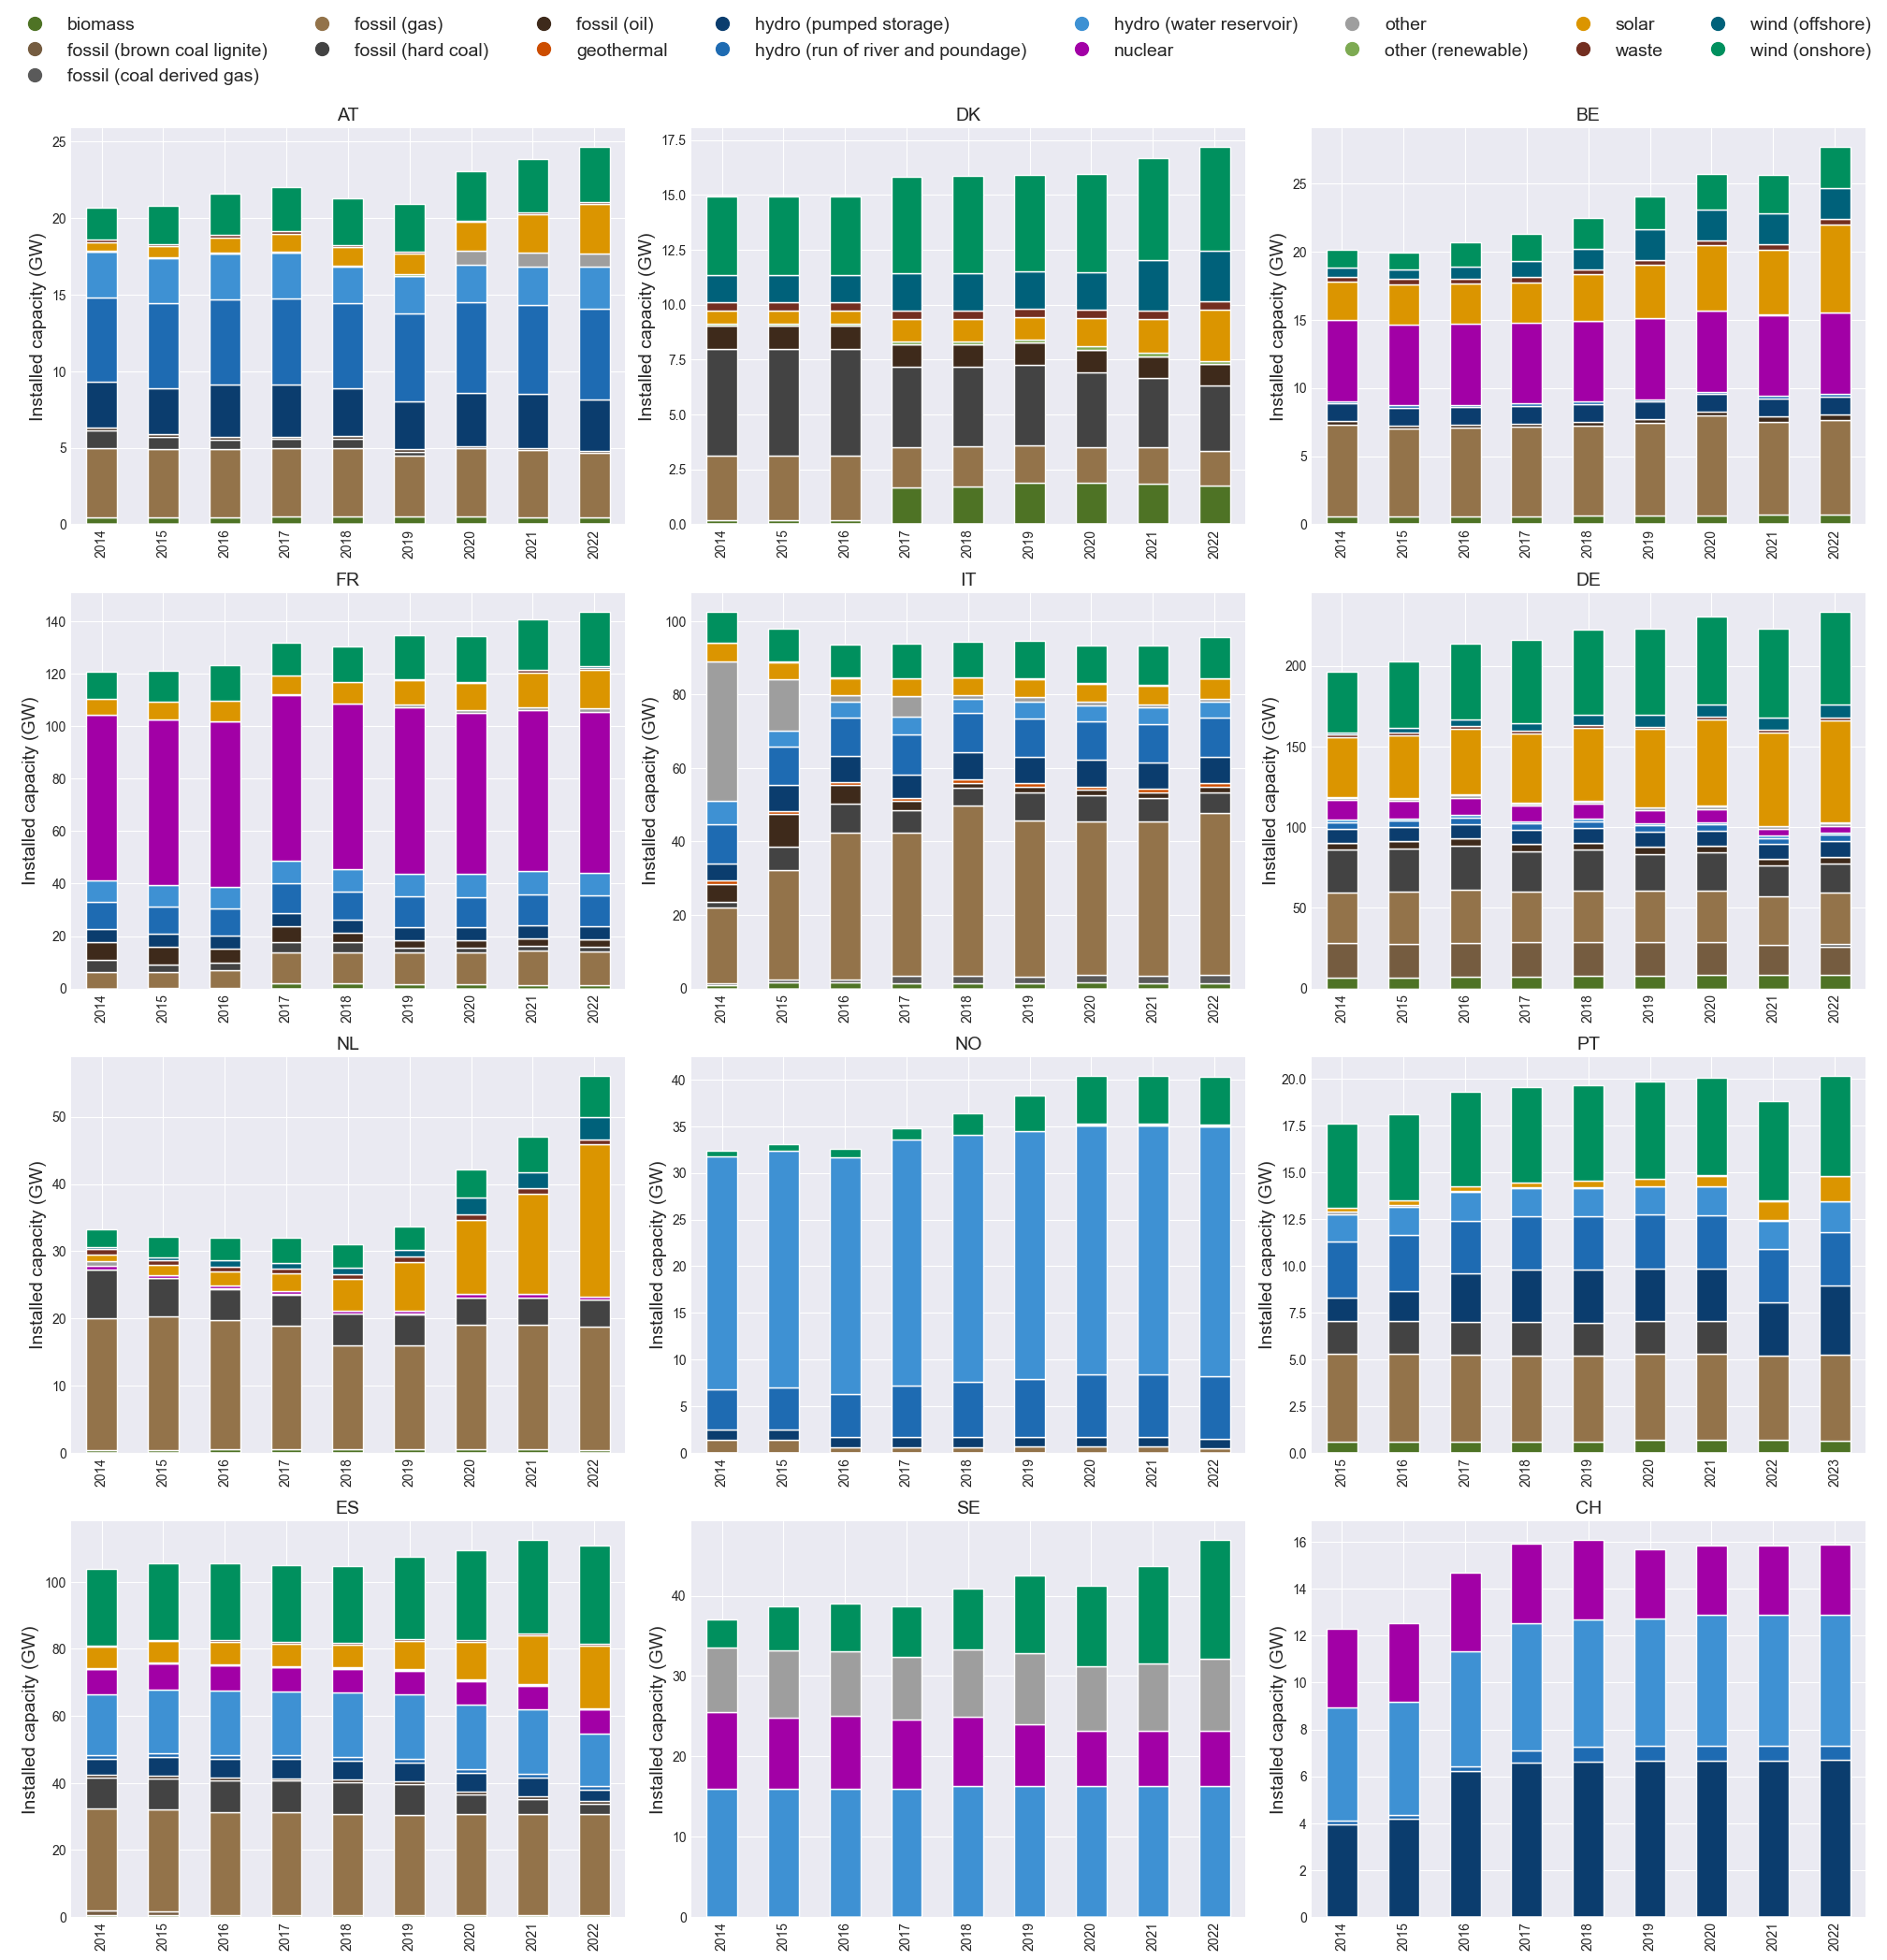

In [53]:
import seaborn as sns

df_capacity = get_yearly_capacity_old()
df_capacity = pd.melt(df_capacity, id_vars=['country_code','price_area', 'year'], var_name = 'generation_type')
# Get the last word after last _, e.g. biomass_generation and biomass_capacity extract generation and capacity
df_capacity['variable'] = df_capacity['generation_type'].apply(lambda x: x.split('_')[-1])
df_capacity['generation_group'] = df_capacity['generation_type'].apply(lambda x: x.split('_')[0])
df_capacity['generation_specific'] = df_capacity['generation_type'].apply(lambda x: '_'.join(x.split('_')[1:-1]))
# Concatenate generation_group and generation_specific if generation_specific is not null
df_capacity['generation_type'] = df_capacity.apply(lambda x: x['generation_group'] if x['generation_specific'] == '' else x['generation_group'] + ' (' + x['generation_specific'].replace('_', ' ') + ')', axis = 1)

# Match the colors to the generation types
df_capacity['color'] = df_capacity['generation_type'].apply(lambda x: electricity_colors[x])
df_capacity = df_capacity[df_capacity['variable'] == 'capacity']
df_capacity = df_capacity[(df_capacity['country_code']==df_capacity['price_area']) & (df_capacity['country_code'].isin(TSO_COUNTRIES.keys()))]

countries = df_capacity['price_area'].unique()
ncols = 3
nrows = len(countries) // ncols + (len(countries) % ncols > 0)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

axes_flat = axes.ravel() if nrows > 1 else [axes]

for ax, country in zip(axes_flat, countries):
    country_data = df_capacity[df_capacity['price_area'] == country]
    
    # Sort and pivot the data for stacked bar plotting
    country_data_sorted = country_data.sort_values(by='generation_type') # This ensures the order of bars is consistent across plots
    country_data_sorted['year'] = country_data_sorted['year'].astype(int)

    pivot_data = country_data_sorted.pivot_table(index='year', columns='generation_type', values='value', aggfunc='sum').fillna(0)/1000
    
    # Get colors from the dataframe
    column_colors = [country_data_sorted[country_data_sorted['generation_type'] == col]['color'].iloc[0] for col in pivot_data.columns]
    pivot_data.plot(kind='bar', stacked=True, color=column_colors, ax=ax)

    # Set title and ylabel for each subplot
    ax.set_title(country, fontsize=14)
    ax.set_ylabel('Installed capacity (GW)', fontsize=14)
    ax.set_xlabel('')
    # Remove legend
    ax.get_legend().remove()

for i in range(len(countries), len(axes_flat)):
    axes_flat[i].axis('off')
# Creating legend
handles = [plt.Line2D([0], [0], color=col, marker='o', markersize=10, label=gen_spec, linestyle='') for col, gen_spec in zip(column_colors, pivot_data.columns)]
fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(df_capacity['color'].unique())/2, fontsize=14)
plt.tight_layout()
plt.show()

In [972]:
# Latest capacity as table
df_capacity_latest = df_capacity[df_capacity['year'] == 2022]
df_capacity_latest = df_capacity_latest.pivot_table(index='price_area', columns='generation_type', values='value', aggfunc='sum').fillna(0)/1000
df_capacity_latest = df_capacity_latest.round(2)
# Add total column
df_capacity_latest['Total'] = df_capacity_latest.sum(axis=1)

df_capacity_latest = df_capacity_latest.transpose().style
# Format 2f
df_capacity_latest = df_capacity_latest.format("{:.2f}")

print(df_capacity_latest.to_latex(convert_css=True, clines= "skip-last;data", hrules = False, multicol_align = 'c', multirow_align='c'))


\begin{tabular}{lrrrrrrrrrrrr}
price_area & AT & BE & CH & DE & DK & ES & FR & IT & NL & NO & PT & SE \\
generation_type &  &  &  &  &  &  &  &  &  &  &  &  \\
biomass & 0.48 & 0.71 & 0.00 & 8.47 & 1.75 & 0.71 & 1.34 & 1.53 & 0.42 & 0.00 & 0.68 & 0.00 \\
fossil (brown coal lignite) & 0.00 & 0.00 & 0.00 & 17.69 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
fossil (coal derived gas) & 0.00 & 0.00 & 0.00 & 1.26 & 0.00 & 0.00 & 0.00 & 2.07 & 0.00 & 0.00 & 0.00 & 0.00 \\
fossil (gas) & 4.21 & 6.92 & 0.00 & 31.81 & 1.57 & 29.90 & 12.89 & 44.22 & 18.35 & 0.46 & 4.52 & 0.00 \\
fossil (hard coal) & 0.00 & 0.00 & 0.00 & 18.13 & 3.02 & 3.22 & 1.82 & 5.58 & 4.01 & 0.00 & 0.00 & 0.00 \\
fossil (oil) & 0.12 & 0.46 & 0.00 & 4.08 & 0.96 & 0.67 & 2.57 & 1.54 & 0.00 & 0.00 & 0.00 & 0.00 \\
geothermal & 0.00 & 0.00 & 0.00 & 0.06 & 0.00 & 0.00 & 0.00 & 0.87 & 0.00 & 0.00 & 0.00 & 0.00 \\
hydro (pumped storage) & 3.36 & 1.31 & 6.70 & 10.03 & 0.00 & 3.42 & 5.05 & 7.26 & 0.00 & 1.06 & 2.83 & 0.0

C:\Users\Nicky\AppData\Local\Temp\ipykernel_8340\895315228.py:58: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax1.plot(x, norm.pdf(x, mu, std), 'k', linewidth=2, label='Normal Distribution', color = 'b')
C:\Users\Nicky\AppData\Local\Temp\ipykernel_8340\895315228.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


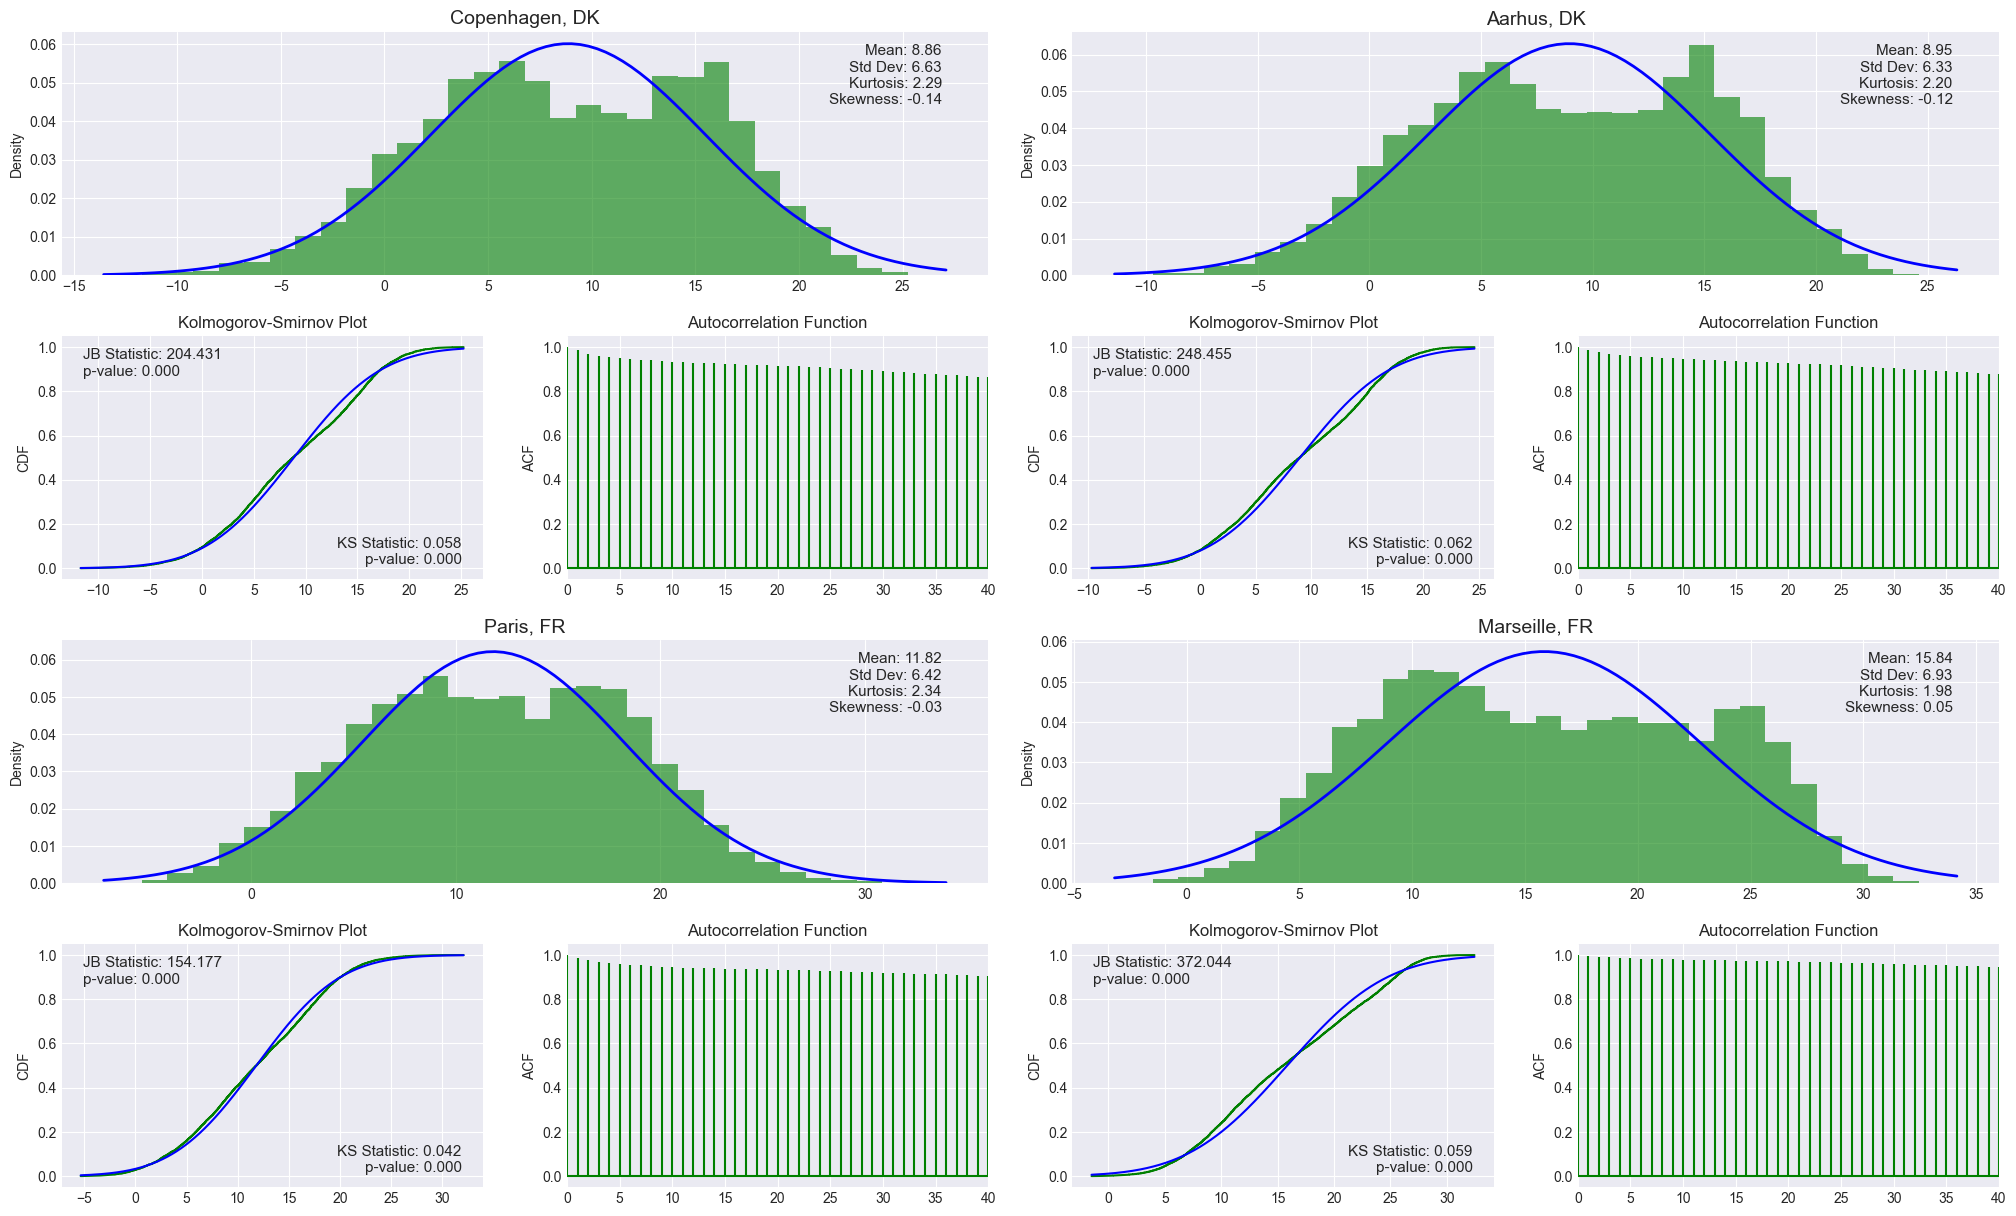

\begin{tabular}{llrrrrrrrr}
 &  & mean & std & kurtosis & skewness & ks_stat & ks_pval & jb_stat & jb_pval \\
country & city &  &  &  &  &  &  &  &  \\
\multirow[c]{2}{*}{DK} & Copenhagen & 8.86 & 6.63 & 2.29 & -0.14 & 0.06 & 0.00 & 204.43 & 0.00 \\
 & Aarhus & 8.95 & 6.33 & 2.20 & -0.12 & 0.06 & 0.00 & 248.45 & 0.00 \\
\cline{1-10}
\multirow[c]{2}{*}{FR} & Paris & 11.82 & 6.42 & 2.34 & -0.03 & 0.04 & 0.00 & 154.18 & 0.00 \\
 & Marseille & 15.84 & 6.93 & 1.98 & 0.05 & 0.06 & 0.00 & 372.04 & 0.00 \\
\cline{1-10}
NL & Amsterdam & 10.66 & 5.87 & 2.41 & -0.12 & 0.05 & 0.00 & 142.15 & 0.00 \\
\cline{1-10}
AT & Vienna & 10.98 & 8.25 & 2.19 & -0.11 & 0.05 & 0.00 & 253.42 & 0.00 \\
\cline{1-10}
ES & Madrid & 14.52 & 7.82 & 1.88 & 0.24 & 0.08 & 0.00 & 531.45 & 0.00 \\
\cline{1-10}
NO & Oslo & 6.66 & 8.35 & 2.50 & -0.29 & 0.07 & 0.00 & 205.40 & 0.00 \\
\cline{1-10}
CH & Zürich & 10.37 & 7.20 & 2.18 & 0.01 & 0.05 & 0.00 & 242.30 & 0.00 \\
\cline{1-10}
BE & Brussels & 11.03 & 6.25 & 2.39 & -0.10 &

In [40]:
# Temperature
# Define the grid layout
from scipy.stats import kurtosis, skew, norm
# Import ECDF
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats

num_countries = 2
gs = gridspec.GridSpec(num_countries*2, 4, height_ratios=[4, 4] * num_countries, hspace = 0.25)
fig = plt.figure(figsize=(25, 15))

stats_table = []

for i, (country_name, country_cities) in enumerate(CAR_temperature_dict.items()):
    for j, city_dict in enumerate(country_cities):

        
        city_name = city_dict['city']
        country_name = city_dict['country']
        city_indices = city_dict['ar_model']['result']
        
        # Compute statistics
        data = city_indices['temperature_2m_avg'].dropna()
        mu, std = np.mean(data), np.std(data)
        kur = kurtosis(data, fisher=False)
        skw = skew(data)

        # KS test
        ks_stat, p_val = stats.kstest(data, 'norm', args=(mu, std))
        # JB test
        jb_stat, jb_pval = stats.jarque_bera(data)
        
        stats_table.append({
            'city': city_name, 
            'country': country_name,
            'mean': mu,
            'std': std,
            'kurtosis': kur,
            'skewness': skw,
            'ks_stat': ks_stat,
            'ks_pval': p_val,
            'jb_stat': jb_stat,
            'jb_pval': jb_pval
        })
        
        
        if i > num_countries - 1:
            break
        
        # y_11: Histogram of payoffs
        ax1 = plt.subplot(gs[2*i, 2*j:2*j+2])

        n, bins, patches = ax1.hist(data, bins=30, density=True, color='g', alpha=0.6)
        xmin, xmax = ax1.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        ax1.plot(x, norm.pdf(x, mu, std), 'k', linewidth=2, label='Normal Distribution', color = 'b')
        ax1.set_ylabel('Density')
        ax1.set_title(f'{city_name}, {country_name}', fontsize=14)

        # Annotate with summary statistics including kurtosis and skewness
        stats_text = f"Mean: {mu:.2f}\nStd Dev: {std:.2f}\nKurtosis: {kur:.2f}\nSkewness: {skw:.2f}"
        ax1.annotate(stats_text, xy=(0.95, 0.95), xycoords='axes fraction', ha='right', va='top', fontsize=11)


        # y_121: Kolmogorov-Smirnov plot
        ax2 = plt.subplot(gs[2*i+1, 2*j])
        ecdf = ECDF(data)
        ax2.plot(ecdf.x, ecdf.y, label='ECDF', color = 'g')
        ax2.plot(ecdf.x, norm.cdf(ecdf.x, loc=mu, 
                                  scale=std), label='Theoretical Normal CDF', color = 'b')
        ax2.set_ylabel('CDF')
        ax2.set_title('Kolmogorov-Smirnov Plot')
        
        # Annotate with KS statistic and p-value
        ks_text = f"KS Statistic: {ks_stat:.3f}\np-value: {p_val:.3f}"
        ax2.annotate(ks_text, xy=(0.95, 0.05), xycoords='axes fraction', ha='right', va='bottom', fontsize=11)
        # Annotate with JB statistic and p-value
        jb_text = f"JB Statistic: {jb_stat:.3f}\np-value: {jb_pval:.3f}"
        ax2.annotate(jb_text, xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top', fontsize=11)



        # y_122: ACF
        ax3 = plt.subplot(gs[2*i+1, 2*j+1])
        ax3.acorr(data, maxlags=40, color = 'g')
        ax3.set_xlim([0, 40])
        
        ax3.set_title('Autocorrelation Function')
        ax3.set_ylabel('ACF')

plt.tight_layout()
plt.show()

stats_table = pd.DataFrame(stats_table).set_index(['country','city']).style
# Format 2f
stats_table.format('{:.2f}', subset=['mean', 'std', 'kurtosis', 'skewness', 'ks_stat', 'ks_pval', 'jb_stat', 'jb_pval'])

print(stats_table.to_latex(convert_css=True, clines= "skip-last;data", hrules = False, multicol_align = 'c', multirow_align='c'))

Export/ Import in each Area

### 3.0: Methodology

#### 3.1: Time Series Decomposition

##### 3.1.1: Temperature Dynamics

In [152]:
from scipy.optimize import curve_fit

def seasonality_benth(x, a_0, a_1, a_2, a_3):
    omega = 2*np.pi/365.25
    y_pred = a_0 + a_1*x + a_2*np.cos(omega*x) + a_3*np.sin(omega*x)
    return y_pred

def seasonality_cabrera(x, a_0, a_1, a_2,a_3, d_1, d_2):
    omega = 2*np.pi/365.25
    y_pred = a_0 + a_1*x + a_2*np.cos(omega*(x-d_1)) + a_3*np.sin((omega /2 )*(x-d_2))
    return y_pred

def RSS(y, y_pred):
    return np.sqrt(np.sum((y-y_pred)**2))

In [151]:
from symfit import parameters, variables, sin, cos, Fit

def fourier_series(x, f, n=0):
    """
    Returns a symbolic fourier series of order `n`.
    :param n: Order of the fourier series.
    :param x: Independent variable
    :param f: Frequency of the fourier series
    """
    # Make the parameter objects for all the terms
    a0, *cos_a = parameters(','.join(['a{}'.format(i) for i in range(0, n + 1)]))
    sin_b = parameters(','.join(['b{}'.format(i) for i in range(1, n + 1)]))
    # Construct the series
    series = a0 + sum(ai * cos(i * f * x) + bi * sin(i * f * x)
                     for i, (ai, bi) in enumerate(zip(cos_a, sin_b), start=1))
    return series

def autoregressive_constant_variance_fit(df, seasonality_mean_func,variable = 'temperature_2m_avg', max_ar_lag=6):
    # Fit the seasonality function
    params, cov = curve_fit(seasonality_mean_func, df.index, df[variable], method = 'lm')
    # Seasonalize the variable
    df['seasonalized'] = df[variable] - seasonality_mean_func(df.index, *params)
    # Select the optimal lag
    optimal = ar_select_order(df['seasonalized'], maxlag=max_ar_lag, ic='aic', trend='n')
    # Fit the model using AutoReg
    model = AutoReg(df['seasonalized'], lags=optimal.ar_lags, trend='n')
    model_fit = model.fit()
    # Add the constant variance residuals to the dataframe
    df['residuals_cv'] = model_fit.resid

    return {'seasonality_function' : (params, cov), 'ar_model' : model_fit, 'result' : df}

# We are now going to create a function that takes in a time varying variance
# Notice, that these functions estimate the parameters one after the other. TODO: is it different from estimating them together?
def autoregressive_time_varying_variance_fit(df, seasonality_mean_func, variable = 'temperature_2m_avg', max_ar_lag=6, fourier_order = 4):
    # Fit the seasonality function
    params, cov = curve_fit(seasonality_mean_func, df.index, df[variable], method = 'lm')
    # Seasonalize the variable
    df['seasonalized'] = df[variable] - seasonality_mean_func(df.index, *params)
    # Select the optimal lag
    optimal = ar_select_order(df['seasonalized'], maxlag=max_ar_lag, ic='aic', trend='n')
    # Fit the model using AutoReg
    model = AutoReg(df['seasonalized'], lags=optimal.ar_lags, trend='n')
    model_fit = model.fit()
    # Add the constant variance residuals to the dataframe
    df['residuals_cv'] = model_fit.resid
    # Fit the variance function
    x, y = variables('x, y')
    # Within Benth (2012), the variance is modelled using 4 fourier terms, we define it as fourier_order
    fourier_model_dict = {y: fourier_series(x, f=2*np.pi/365.25, n=fourier_order)}
    # Fit the fourier model, recall that we have used AR(p) model, so we need to use a time shift of p (the maximum lag)
    time_shift = np.max(optimal.ar_lags)
    
    fourier_model = Fit(fourier_model_dict, x=df[time_shift:].index, y=df[time_shift:]['residuals_cv']**2)
    fourier_model_fit = fourier_model.execute()
    # Add the time varying variance residuals to the dataframe
    df['fitted_variance'] = fourier_model_fit.model(x=df.index, **fourier_model_fit.params).y
    df['residuals_tv'] = df['residuals_cv'] / np.sqrt(df['fitted_variance'])
    
    # Return the seasonality function parameters, the AR model, the fourier model result and the dataframe
    return {'seasonality_function' : (params, cov), 'ar_model' : model_fit, 'fourier_model' : fourier_model_fit, 'result' : df}

##### 3.1.2: Wind Dynamics

Benth (2010) employed a Box-Cox transformation to achieve symmetry in wind speed data before fitting an AR(4) process with seasonal mean and volatility. We consider here the general transformation of wind speed data when defining continuous time dynamics. Therefore, we define the *wind speed* $W(t)$ at time $t \geq 0$ to be:

\begin{equation}
    W(t)=
    \begin{cases}
      \big [ 
      \lambda (\Lambda(t) + Y(t))
      + 1 \big ]^{1/\lambda} &, \lambda \neq 0,
      \\
      \exp (\Lambda(t) + Y(t)) &, \lambda=0,
    \end{cases}
\end{equation}

for a constant $\lambda$ and $\Lambda(t)$ a seasonal function as in the previous section. A problem with this transformation is that for $\lambda \neq 0$, we may theoretically obtain negative wind speeds. The research of Benth (2010) argued that $1/\lambda=5$ performed best.

In [150]:
def transformation_wind_speed(x, lambda_value = 1/5):
    if lambda_value == 0:
        x_transformed = np.log(x)
    else:
        x_transformed = (x**lambda_value - 1) / lambda_value
    
    return x_transformed

#### 3.2: Continious-Time Autoregressive Models

In [149]:
def ar_car_link(phi):
    """
    Returns a AR-CAR link between the AR(p) and CAR(p) models for p=1,2,3,4
    """
    # AR(p) model
    # phi = [phi_1, phi_2, phi_3, phi_4, ..., phi_p]
    p = len(phi)
    if p==1:
        x = [1 - phi[0]]
    elif p==2:
        A = np.array([[-1,0],[1,-1]])
        b = np.array([phi[0]-2,phi[1]+1])
        x = np.linalg.solve(A, b)
    elif p==3:
        A = np.array([[-1,0,0],[2,-1,0],[-1,1,-1]])
        b = np.array([phi[0]-3,phi[1] + 3,phi[2] -1])
        x = np.linalg.solve(A, b)
    elif p==4:
        A = np.array([[1,0,0,0],[3,-1,0,0],[-3,2,-1,0],[1,-1,1,-1]])
        b = np.array([-phi[0]+4,phi[1]+6,phi[2]-4,phi[3]+1])
        x = np.linalg.solve(A, b)
    else:
        raise ValueError('Only p=1,2,3,4 supported')
        
    # CAR(p) model
    A = np.zeros((p,p))
    for i in range(p):
        if i>0:
            A[i-1,i] = 1
        A[p-1,i] = -x[len(x)-i-1]
        
    return A, x

from scipy.linalg import expm
# Recursive Euler Scheme, see https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method
class EulerSchemeCAR:
    def __init__(self, A, seasonality_mean_func, seasonality_mean_params, variance_func, variance_func_params, dt = 1):
        self.A = A
        self._ = expm(A*dt)
        
        self.variance_func = variance_func
        self.variance_func_params = variance_func_params
        self.seasonality_mean_func = seasonality_mean_func
        self.seasonality_mean_params = seasonality_mean_params
        
        self.variance = None
        self.mean = None
        
        self.dt = dt
        self.p = A.shape[0]
        # Euclidean unit vector
        e = np.zeros(self.p)
        e[-1] = 1
        self.e = e.reshape(self.p,1)
    
    """
    Simulate the CAR(p) model using the Euler Scheme
    
    x0: initial value
    t0: start time (in days)
    t1: end time (in days)
    nsim: number of simulations
    """
    
    def simulate(self, x0, t0, t1, nsim = 100):
        # Calculate the number of steps
        n_steps = int((t1-t0)/self.dt)
        # Calculate the time points
        time_points = np.linspace(t0, t1, n_steps)
        # Calculate the variance at time t (Fourier Series)
        variance = self.variance_func.model(x=time_points, **self.variance_func_params).y
        # Calculate the mean at time t (Custom Function)
        mean = self.seasonality_mean_func(time_points, *self.seasonality_mean_params)
        
        # Create a 3D array for xs_sim (nsim x self.p x n_steps)
        xs_sim = np.zeros((nsim, self.p, n_steps))
        
        # TODO: Vectorize this loop to
        for s in range(nsim):
            # Euler Scheme Approximation        
            xs = np.zeros((n_steps, self.p))
            # Fill the first value with the initial value (px1)
            xs[0] = np.full(self.p, x0)
            for i in range(1, n_steps):
                xs[i] = self.euler_step(xs[i-1], variance[i])
                
            xs_sim[s] = xs.transpose()
            
        # xs is the simulated CAR(p) model (px1)
        # ys is the simulated transformed using Y(t) = b'X(t)
        # ms is Y(t) + mean
        b = np.zeros(self.p).reshape(1,self.p)
        b[0] = 1
        ys_sim = np.dot(b, xs_sim)
        ms_sim = ys_sim + mean
        return xs_sim.transpose(), ys_sim.transpose()[:,:,0], ms_sim.transpose()[:,:,0]
        
    def euler_step(self, x, v):
        # Calculate the next step
        # p i.i.d. standard normal random variables (px1) TODO: This is weird, I think it should be 1x1 or a cross product or something
        epsilon = np.array(np.random.normal(0,1, size = 1))
        x = np.matmul(self._, x) + np.matmul(self._,self.e).dot(epsilon *np.sqrt(v)*np.sqrt(self.dt))
        # Returns a (px1) vector
        return x


#### 3.3: Pricing & Change Of Measure

In this section, different methodologies for pricing weather contracts based on temperature and wind speed are presented and discussed. Consider a forward contract at time $t$, the arbitrage-free price of the forward contract will be:

\begin{equation}
f(t,T)=S(t)\exp (r(T-t)),
\end{equation}

where $r$ is a constant compounding interest rate, $T$ is the delivery date of the forward, and $S(t)$ is the current spot price. From the general arbitrage pricing theory, we know that a market is free of arbitrage as long as there exists at least one equivalent martingale measure $\mathcal{Q}$.

To derive the explicit price, a specification is needed for the risk-neutral probability measure $\mathcal{Q}$. However, the weather derivatives market is an incomplete market, as weather parameters themselves cannot be stored or traded. Because of this incompleteness, any probability measure $\mathcal{Q}$ is equivalent to the real measure $\mathcal{P}$ in a risk-neutral measure, yielding a *zero risk premium*.

---

We introduce a class of equivalent probabilities $\mathcal{Q}$ to be used as the pricing measures in the pricing of weather forwards. The measures change the level of mean reversion in the CARMA dynamics $\mathbf{X}(t)$ from zero to a constant and in addition change the AR coefficients $a_{1},a_{2},...,a_{p}$. The latter may be interpreted as a change in the speed of mean reversion of the stationary CARMA dynamics. In the book of Benth (2012) precise derivations are given that lead to the following result.

The $\mathcal{Q}^{\theta}$ dynamics of $\mathbf{X}(t)$  is

\begin{equation}
d \mathbf{X}(t) = (e_{p} \theta_{0}(t) + A_{\theta}\mathbf{X}) dt + e_{p} \sigma(t)d \mathcal{\tilde{B}}(t),
\end{equation}

where the measure change $\mathcal{\tilde{B}}(t)$ is defined as
\begin{equation}
d \mathcal{\tilde{B}}(t)= \frac{\theta_{0}(t)}{\sigma(t)} dt + d \mathcal{B}(t)
\end{equation}

and $A_{\theta}$ is 

$A_{\theta}$ = $\begin{bmatrix}
    0  & 1 & 0 & \cdots & 0 \\
    0  & 0 & 1 & \cdots & 0 \\
    \vdots & \vdots & \vdots & \vdots & \vdots \\
    0 & 0 & 0 & \cdots & 1 \\
    -(a_{p} - \theta_{p}) & -(a_{p-1} - \theta_{p-1}) & -(a_{p-2} - \theta_{p-2})& \cdots & -(a_{1} - \theta_{1}) \\
\end{bmatrix}$

Very difficult, for now we assume $\theta$=0

##### 3.3.1: Temperature Derivatives

The following equations represent the calculations for various weather indices:
\begin{equation}
HDD(\tau_{1},\tau_{2}) = \int_{\tau_{1}}^{\tau_{2}} \max(c - T_{u}, 0) du,
\end{equation}

\begin{equation}
CDD(\tau_{1},\tau_{2}) = \int_{\tau_{1}}^{\tau_{2}} \max(T_{u}-c, 0) du,
\end{equation}

\begin{equation}
CAT(\tau_{1},\tau_{2}) = \int_{\tau_{1}}^{\tau_{2}} T_{u} du,
\end{equation}
where c is a baseline temperature, which is usually $18^{\circ}C$ or $65^{\circ}F$, and $T_{u}=\frac{T_{u,\max} + T_{u, \min}}{2}$ is the average daily temperature on day u. The CDD index is intended to measure the demand for air-conditioning, whereas the HDD measures the demand for heating. The typical seasons of these contracts correspond to when heating demands or cooling demands are high, thus the HDD index usually measures the temperature from October to April whereas the CDD index measures the temperature from April to October. The CAT index substitutes the CDD index for the European cities traded on the CME. 

A HDD-CDD parity can be deduced from the previous expressions which can be expressed as:
\begin{equation}
CDD(\tau_{1},\tau_{2})- HDD(\tau_{1},\tau_{2})= CAT(\tau_{1},\tau_{2}) - c(\tau_{2}-\tau_{1}).
\end{equation}

In [148]:
### Using simulations to compute the weather derivatives

# HDD(\tau_{1},\tau_{2}) = \int_{\tau_{1}}^{\tau_{2}} \max(c - T_{u}, 0) du,
def HDD(x, t0, t1 , c = 18.0, y = []):
    # x is a vector of (simulated) temperatures, if its a matrix return a vector of columns
    # y is a vector of actual temperatures
    # c is the baseline temperature
    _x = x[t0:t1].copy()
    _y = y[t0:t1].copy()

    # Replace the simulated temperatures with the actual temperatures (if available)
    if len(_y) > 0:
        # Fill a matrix of the same size as x with the values of y
        _x[:len(_y)] = np.tile(_y, (_x.shape[1], 1)).T
        
    return np.sum(np.maximum(c - _x, 0), axis = 0)
    
# CDD(\tau_{1},\tau_{2}) = \int_{\tau_{1}}^{\tau_{2}} \max(T_{u}-c, 0) du,
def CDD(x, t0, t1 , c = 18.0, y = []):
    # x is a vector of (simulated) temperatures, if its a matrix return a vector of columns
    # y is a vector of actual temperatures
    # c is the baseline temperature
    _x = x[t0:t1].copy()
    _y = y[t0:t1].copy()

    # Replace the simulated temperatures with the actual temperatures (if available)
    if len(_y) > 0:
        # Fill a matrix of the same size as x with the values of y
        _x[:len(_y)] = np.tile(_y, (_x.shape[1], 1)).T
        
    return np.sum(np.maximum(_x - c, 0), axis = 0)

# CAT(\tau_{1},\tau_{2}) = \int_{\tau_{1}}^{\tau_{2}} T_{u} du,
def CAT(x, t0, t1, y = []):
    # x is a vector of (simulated) temperatures, if its a matrix return a vector of columns
    # y is a vector of actual temperatures
    # c is the baseline temperature
    _x = x[t0:t1].copy()
    _y = y[t0:t1].copy()

    # Replace the simulated temperatures with the actual temperatures (if available)
    if len(_y) > 0:
        # Fill a matrix of the same size as x with the values of y
        _x[:len(_y)] = np.tile(_y, (_x.shape[1], 1)).T
        
    return np.sum(_x, axis = 0)

##### 3.3.3: Actual Indices

The typical seasons of these contracts correspond to when heating demands or cooling demands are high, thus the HDD index usually measures the temperature from October to April whereas the CDD index measures the temperature from April to October. The CAT index substitutes the CDD index for the European cities traded on the CME. 

We are going to create monthly HDD, CAT running from:
- OCT, NOV, DEC, JAN, FEB, MAR: HDD
- APR, MAY, JUN, JUL, AUG, SEP, OCT: CAT

We are also going to make 3 and 6 month strips, HDD OCT-JAN, JAN-APR, OCT-APR and CAT APR-JUL, JUL-OCT, APR-OCT

In [147]:
def actual_temperature_indices(car, ar_fit, start_date = dt.date(2016,1,1), nsim = 100, index_points = 20):
    df_actual = ar_fit['result'] # The dataframe with the actual temperatures
    end_date = df_actual['date'].max()

    # Get the idx of the start date in df_actual
    start_idx = df_actual[df_actual['date'] == start_date].index[0]
    end_idx = df_actual[df_actual['date'] == end_date].index[0]
    # Simulate the CAR(p) model
    xs, ys, ms = car.simulate(x0=1, t0=start_idx, t1=end_idx, nsim = nsim)
    
    # Strip - Monthly
    df_actual['year'] = df_actual['date'].dt.year
    df_actual['month'] = df_actual['date'].dt.month
    df_actual['season'] = df_actual['date'].apply(lambda x: 0 if x.month in [12,1,2] else (1 if x.month in [3,4,5] else (2 if x.month in [6,7,8] else 3)))

    # Group by month, and for each date/day in the month we are going to run the CAT function using the same indices:
    # 1: Group by month
    # 2: For each month, get the index of the days in the month (e.g. 60,61,...,90)
    # 3: For each day in the month, run the CAT function using the ms[60:90] as in the example above
    # 4: For every day, add the actual temperature to the CAT function. So for day 62, it will become CAT(ms[60:90], df_actual['temperature_2m_avg'][60:62])
    # 5: Add the results to a list, and then add the list to a dataframe. This column will be called front month CAT    
    # Initialize an empty list to store the results
    results = []
    # For each granularity, calculate the CAR(p) values
    for (year, month), group in df_actual.groupby(['year', 'month']):
        indices = group.index
        for idx in indices:
            if idx < start_idx:
                continue
            ms_selected = ms[(indices[0]-start_idx):(indices[-1]-start_idx)]
            actual_selected = df_actual.loc[indices[0]:(idx-1), 'temperature_2m_avg']
            # Calculate the CAT function for each day of the month
            cat_value = CAT(x=ms_selected, y=actual_selected, t0 = 0, t1 = (indices[-1] - indices[0])).mean()
            cdd_value = CDD(x=ms_selected, y=actual_selected, t0 = 0, t1 = (indices[-1] - indices[0])).mean()
            hdd_value = HDD(x=ms_selected, y=actual_selected, t0 = 0, t1 = (indices[-1] - indices[0])).mean()
            
            # The continuous instrument that we are going to use to simplify; we'll call the OT (Overall Temperature)
            ot_value = 0
            # CAT: Jun, JUL, AUG, SEP, MAY
            # HDD: OCT, NOV, DEC, JAN, FEB, MAR, APR
            if month in [5,6,7,8,9]:
                ot_value = cat_value
            elif month in [10,11,12,1,2,3,4]:
                ot_value = hdd_value
                    
            _ = {
                'date' : group.loc[idx, 'date'], # Get the date of the idx
                'year' : year,
                'month' : month,
                f'strip_cat_{month}' : cat_value*index_points,
                f'strip_cdd_{month}' : cdd_value*index_points,
                f'strip_hdd_{month}' : hdd_value*index_points,
                'strip_cat_continuous' : cat_value*index_points,
                'strip_cdd_continuous' : cdd_value*index_points,
                'strip_hdd_continuous' : hdd_value*index_points,
                'strip_ot_continuous' : ot_value*index_points,
                'temperature_2m_avg' : group.loc[idx, 'temperature_2m_avg'],
                'ms' : ms[(indices[0]-start_idx):(idx-start_idx)].mean()
            }
            # Store the result
            #results.append((group.loc[idx, 'date'], cat_value, cdd_value, hdd_value))
            results.append(_)

    # Convert the results to a DataFrame and rename the columns
    df_results = pd.DataFrame(results).bfill()
    df_results['date'] = pd.to_datetime(df_results['date'], format='%Y-%m-%d')

    # Payoff is simply the difference between the current and previous value. Notice, that because we have monthly holding period.     
    for instrument in ['cat', 'cdd', 'hdd', 'ot']:
        df_results[f'strip_{instrument}_continuous_payoff'] = df_results[f'strip_{instrument}_continuous'].diff()
        # Each first day of the month will have a payoff of 0, because there is no previous value to compare it to.
        df_results.loc[df_results['date'].dt.day == 1, f'strip_{instrument}_continuous_payoff'] = 0

        
    return df_results

#### 3.4: PPA


In [28]:
def ppa_calc(p_fixed, p_dynamic, lamb, delta, phi, kappa = -np.inf, nu = np.inf):
    result = (p_fixed + phi) * lamb + (1 - lamb) * (1 - delta) * p_dynamic
    return np.where(result < kappa, kappa, np.where(result > nu, nu, result))

\begin{equation}
PPA(p_{\text{fixed}}, p_{\text{dynamic}}, \lambda, \delta, \phi, \kappa, \nu) = 
\begin{cases} 
\kappa & \text{if } p_{\text{fixed}}\lambda + \phi\lambda + (1 - \lambda)(1 - \delta)p_{\text{dynamic}} < \kappa \\
\nu & \text{if } p_{\text{fixed}}\lambda + \phi\lambda + (1 - \lambda)(1 - \delta)p_{\text{dynamic}} > \nu \\
p_{\text{fixed}}\lambda + \phi\lambda + (1 - \lambda)(1 - \delta)p_{\text{dynamic}} & \text{otherwise}
\end{cases}
\end{equation}

#### 3.4: Hedging



We define the power output of an asset $i$ as $\xi_{t,i}$ and the PPA price within the asset's country as $P_{t}$. We can compute the revenue of the asset within a given time period $(\tau_{1},\tau_{2})$ as $\pi_{i}(\tau_{1},\tau_{2})=\sum_{t=\tau_{1}}^{\tau_{2}} P_{t} \cdot \xi_{t,i}$. 

Like in multivariate continious-time modelling of of wind indexes and hedging wind risk, we obtain a payoff using the revenue and the weather derivatives.

This results in:

\begin{equation}
\pi_{i}(\tau_{1},\tau_{2}) + \sum_{j=1}^{L} \gamma_{j} W_{j}(\tau_{1},\tau_{2})
\end{equation}

where $\gamma_{j} W_{j}$ is the weighted weather derivate payoff.

### 4: Results

#### 4.1: Prepare Methodology

In [368]:
hybrid_10 = lambda x : ppa_calc(p_fixed = x['price_fixed'], p_dynamic = x['price'], lamb = 0.10, delta = 0, phi = 0)
hybrid_25 = lambda x : ppa_calc(p_fixed = x['price_fixed'], p_dynamic = x['price'], lamb = 0.25, delta = 0, phi = 0)
hybrid_50 = lambda x : ppa_calc(p_fixed = x['price_fixed'], p_dynamic = x['price'], lamb = 0.5, delta = 0, phi = 0)
hybrid_75 = lambda x : ppa_calc(p_fixed = x['price_fixed'], p_dynamic = x['price'], lamb = 0.75, delta = 0, phi = 0)
hybrid_90 = lambda x : ppa_calc(p_fixed = x['price_fixed'], p_dynamic = x['price'], lamb = 0.90, delta = 0, phi = 0)

market_collar = lambda x : ppa_calc(p_fixed = x['price_fixed'], p_dynamic = x['price'], lamb = 0, delta = 0, phi = 0, kappa = 20, nu = x['price_fixed']*1.5)
discount_market_collar = lambda x : ppa_calc(p_fixed = x['price_fixed'], p_dynamic = x['price'], lamb = 0, delta = 0.1, phi = 0, kappa = 20, nu = x['price_fixed']*1.5)

dynamic = lambda x : ppa_calc(p_fixed = x['price_fixed'], p_dynamic = x['price'], lamb = 1, delta = 0, phi = 0)

ppa_functions = {
    #'hybrid_10' :    hybrid_10,
    #'hybrid_25' :    hybrid_25,
    #'hybrid_50' :    hybrid_50,
    #'hybrid_75' :    hybrid_75,
    #'hybrid_90' :    hybrid_90,
    #'market_collar' : market_collar,
    #'discount_market_collar' : discount_market_collar,
    'dynamic' : dynamic
}


In [163]:
# We average the prices for each country code, so NOT THE PRICE AREA
hourly_entsoe_day_ahead_prices = hourly_entsoe_day_ahead_prices.groupby(['timestamp', 'country_code','price']).mean().reset_index()
# Price fixed is the median price of the day-ahead market for a given year and price area
hourly_entsoe_day_ahead_prices['season'] = hourly_entsoe_day_ahead_prices['timestamp'].apply(lambda x: 0 if x.month in [12,1,2] else (1 if x.month in [3,4,5] else (2 if x.month in [6,7,8] else 3)))
# This is a proxy for the baseload future season price
hourly_entsoe_day_ahead_prices['year'] = hourly_entsoe_day_ahead_prices['timestamp'].dt.year

hourly_entsoe_day_ahead_prices['price_fixed'] = hourly_entsoe_day_ahead_prices.groupby(['country_code', 'year', 'season'])['price'].transform('median')

for ppa_name, ppa_func in ppa_functions.items():
    # Create for each ppa function a new column (not using ppa_func.__name__ because it returns <lambda>)
    hourly_entsoe_day_ahead_prices[f"price_{ppa_name}"] = hourly_entsoe_day_ahead_prices.apply(ppa_func, axis = 1)

#### Revenue (generation category)

In [164]:

# Pivot the energy categories from wide to long
hourly_entsoe_category_revenue = pd.melt(hourly_entsoe_generation_production, id_vars = ['timestamp', 'price_area', 'country_code'], var_name = 'generation_type', value_name = 'generation').fillna(0)

for ppa_name, ppa_func in ppa_functions.items():
    # Create for each ppa function a new column (not using ppa_func.__name__ because it returns <lambda>)
    hourly_entsoe_day_ahead_prices[f"price_{ppa_name}"] = hourly_entsoe_day_ahead_prices.apply(ppa_func, axis = 1)
     
hourly_entsoe_category_revenue = hourly_entsoe_category_revenue.merge(hourly_entsoe_day_ahead_prices, on = ['timestamp', 'country_code'])
hourly_entsoe_category_revenue.head(5)

timestamp price_area country_code  \
0 2017-12-31 00:00:00+00:00         BE           BE   
1 2017-12-31 00:00:00+00:00         BE           BE   
2 2017-12-31 00:00:00+00:00         BE           BE   
3 2017-12-31 00:00:00+00:00         BE           BE   
4 2017-12-31 00:00:00+00:00         BE           BE   

             generation_type  generation  price  season  year  price_fixed  \
0                    biomass       364.0  14.04       0  2017        18.54   
1  fossil_brown_coal_lignite         0.0  14.04       0  2017        18.54   
2    fossil_coal_derived_gas         0.0  14.04       0  2017        18.54   
3                 fossil_gas      1264.0  14.04       0  2017        18.54   
4           fossil_hard_coal         0.0  14.04       0  2017        18.54   

        price_dynamic  
0  18.539999961853027  
1  18.539999961853027  
2  18.539999961853027  
3  18.539999961853027  
4  18.539999961853027

In [165]:
for ppa_name, ppa_func in ppa_functions.items():
    hourly_entsoe_category_revenue[f"revenue_{ppa_name}"] = hourly_entsoe_category_revenue[f"price_{ppa_name}"] * hourly_entsoe_category_revenue['generation']

In [166]:
# Turn to daily revenues
hourly_entsoe_category_revenue['date'] = hourly_entsoe_category_revenue['timestamp'].dt.date
daily_entsoe_category_revenue = hourly_entsoe_category_revenue.groupby(['date', 'generation_type','country_code']).agg(
    {'price' : 'mean', 'price_fixed' : 'mean', 
     'generation' : 'sum', 
    # ppa_functions
    **{f'revenue_{ppa_name}' : 'sum' for ppa_name in ppa_functions.keys()}
    }).reset_index()

daily_entsoe_category_revenue['date'] = pd.to_datetime(daily_entsoe_category_revenue['date'])
# As date instead of datetime
daily_entsoe_category_revenue.head(5)

date generation_type country_code      price  price_fixed  generation  \
0 2017-12-31         biomass           BE  16.381667       18.540      7341.0   
1 2017-12-31         biomass           DE   2.467917        1.950    350544.5   
2 2017-12-31         biomass           ES  15.040833       13.795      6716.0   
3 2017-12-31         biomass           FR  10.760000       11.880      6850.0   
4 2017-12-31         biomass           IT  55.220000       46.680     24177.0   

  revenue_dynamic  
0    136102.13972  
1   683561.770821  
2     92647.21731  
3    81377.997518  
4  1128582.367378

In [168]:
REVENUE_DATE = min(daily_entsoe_category_revenue['date']).strftime('%Y-%m-%d')
REVENUE_DATE = '2018-01-01'

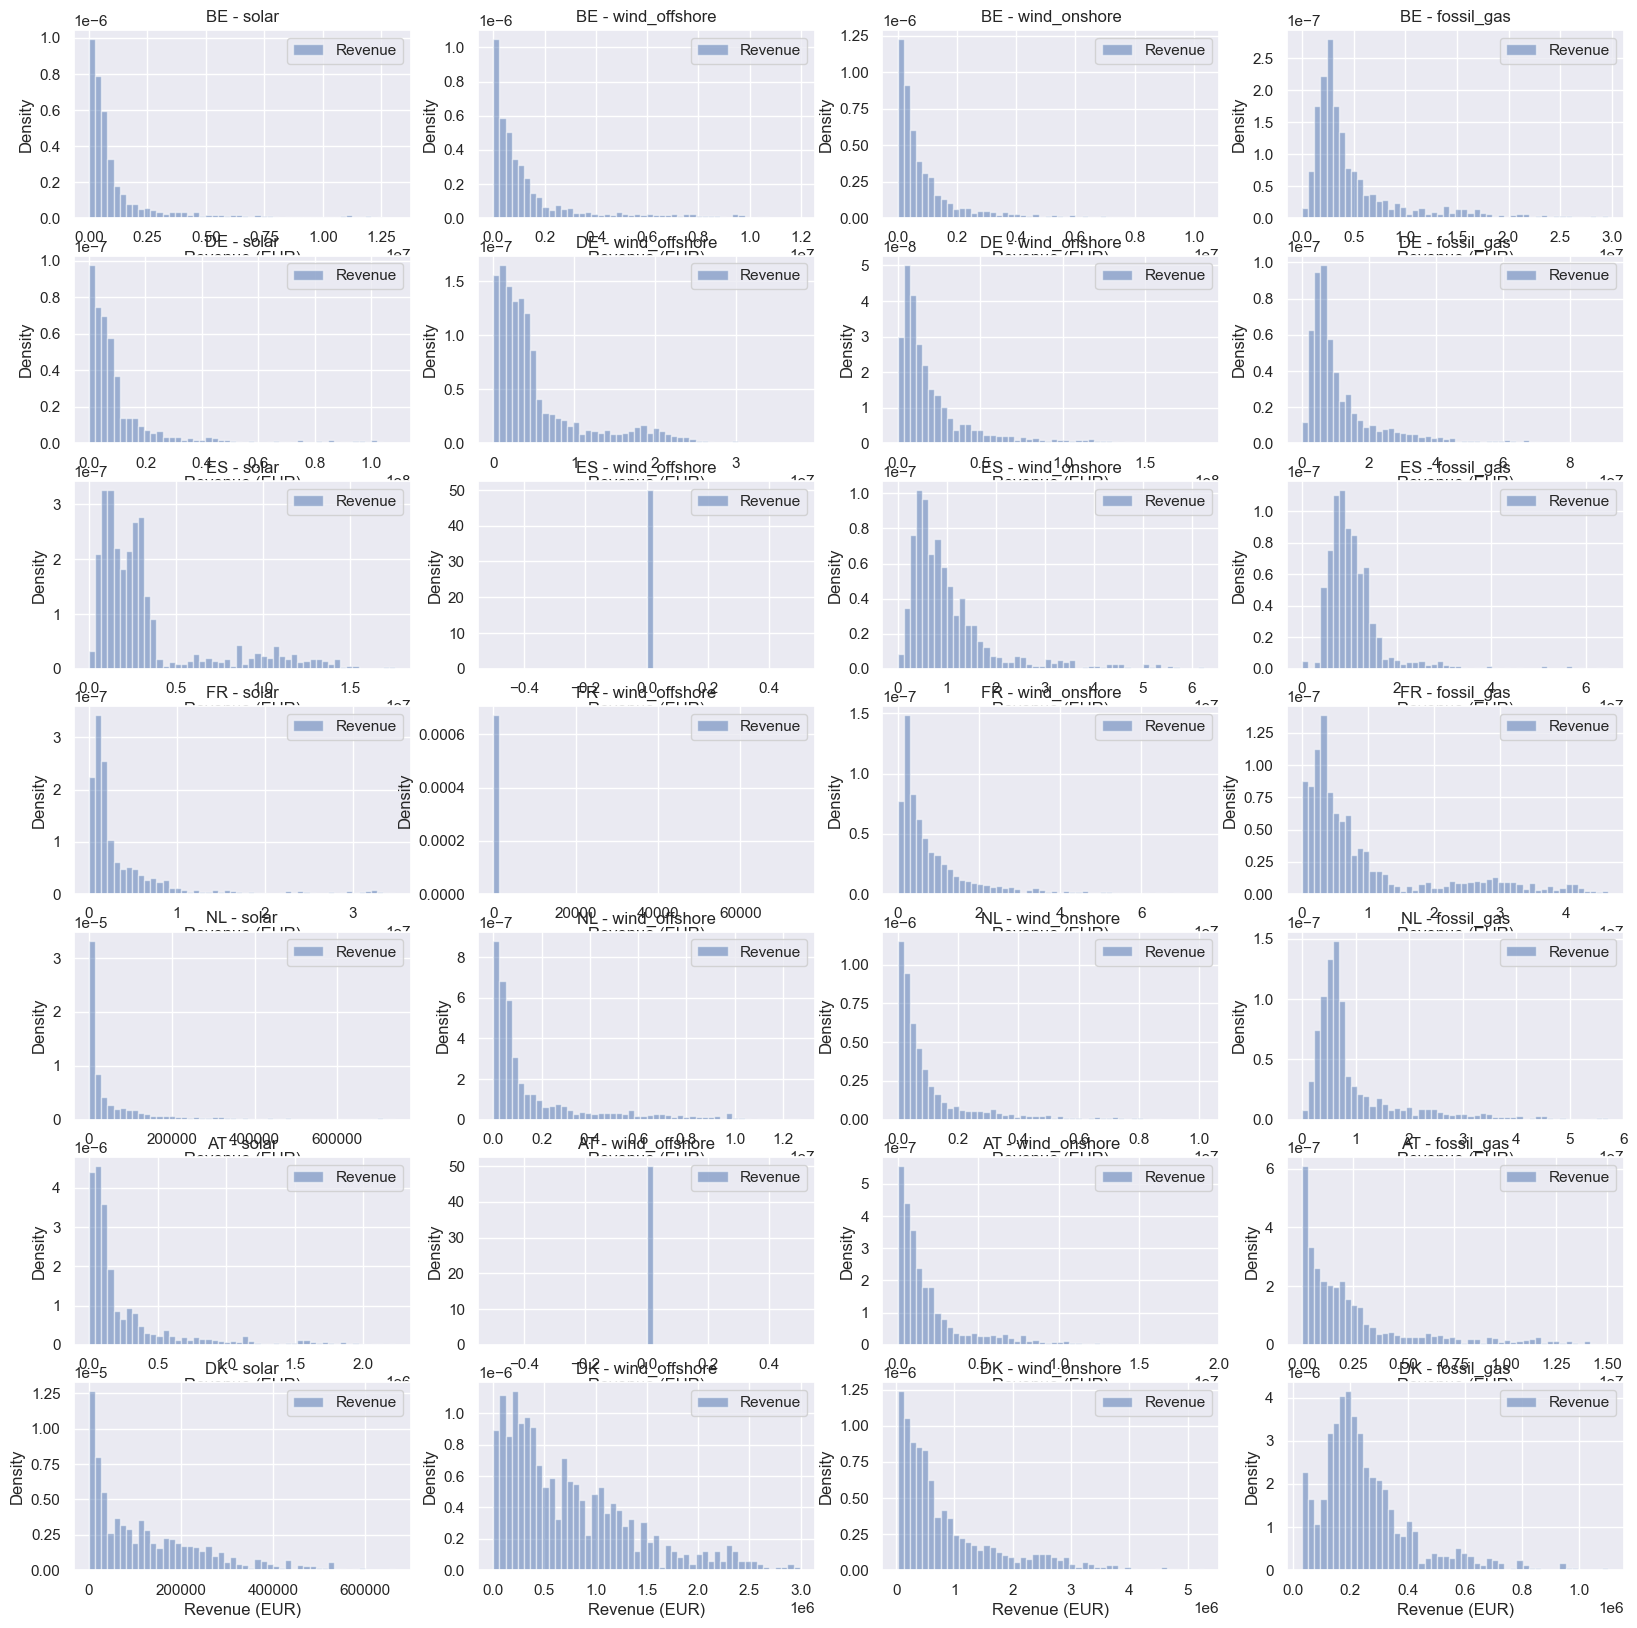

In [434]:
# Create a histogram for every country_code and generation_type on the same figure

generation_types = ['solar','wind_offshore','wind_onshore','fossil_gas']

fig, axs = plt.subplots(len(daily_entsoe_category_revenue['country_code'].unique()), len(generation_types), figsize = (20,20))

for i, country_code in enumerate(daily_entsoe_category_revenue['country_code'].unique()):
    for j, generation_type in enumerate(generation_types):
        # Filter the data
        data = daily_entsoe_category_revenue[(daily_entsoe_category_revenue['country_code'] == country_code) & (daily_entsoe_category_revenue['generation_type'] == generation_type)]
        # Plot the histogram
        axs[i,j].hist(data['revenue_dynamic'], bins = 50, density = True, alpha = 0.5, label = 'Revenue')
        axs[i,j].set_title(f'{country_code} - {generation_type}')
        axs[i,j].set_xlabel('Revenue (EUR)')
        axs[i,j].set_ylabel('Density')
        axs[i,j].legend()
     

#### 4.2 Weather Derivatives: Temperature Dynamics

##### Computations

In [153]:
%%capture output
CAR_temperature_dict = {}

# For every country, city in the weather_df
for country in weather_df['country'].unique():
    CAR_temperature_dict[country] = []
    for city in weather_df[weather_df['country'] == country]['city'].unique():
        # Get the temperature data
        temperature_df = weather_df[weather_df['city'] == city][['time', 'temperature_2m_avg']]
        # Sort by time
        temperature_df = temperature_df.sort_values(by='time')[['time','temperature_2m_avg']]
        temperature_df = temperature_df.set_index('time')
        # Keep the old date column
        temperature_df['date'] = temperature_df.index
        # Convert the index to ordinal
        if isinstance(temperature_df.index , pd.DatetimeIndex):
            first_ord = temperature_df.index.map(dt.datetime.toordinal)[0]
            # The index needs to correspond to the day of the year, so if toordinal is 7800, but the day of the year is 200, we need to subtract 7600
            first_day = dt.datetime.fromordinal(first_ord).timetuple().tm_yday
            temperature_df.index=temperature_df.index.map(dt.datetime.toordinal)

        # Shift the index to start at 0
        temperature_df.index = temperature_df.index - first_ord + (first_day - 1)
        
        # Get our autoregressive model
        city_result = autoregressive_time_varying_variance_fit(temperature_df, seasonality_cabrera, variable = 'temperature_2m_avg', max_ar_lag=3, fourier_order = 4)
        # Get the link between the AR model and the CAR model
        ar_model = city_result['ar_model']
        A, x = ar_car_link(ar_model.params)
        variance_func = city_result['fourier_model']
        variance_func_params = city_result['fourier_model'].params
        mean_func = seasonality_cabrera
        mean_func_params = city_result['seasonality_function'][0]
        
        # Create the CAR model
        city_CAR = EulerSchemeCAR(A, 
                                    seasonality_mean_func=mean_func, 
                                    seasonality_mean_params=mean_func_params, 
                                    variance_func=variance_func, 
                                    variance_func_params=variance_func_params)

        # Save the CAR model
        CAR_temperature_dict[country].append({
            'car_model' : city_CAR,
            'ar_model' : city_result,
            'city' : city,
            'country' : country
        })

##### Simulation

In [154]:
%%capture output
# Start simulating the CAR models to join with the generation data
for country_name, country_cities in CAR_temperature_dict.items():
    for i, city_dict in enumerate(country_cities):
        # Get the city and country name
        city_name = city_dict['city']
        country_name = city_dict['country']
        # Get the CAR model
        city_CAR = city_dict['car_model']
        # Get the AR model
        city_AR = city_dict['ar_model']
        
        # Start the simulation
        city_indices = actual_temperature_indices(city_CAR, city_AR, start_date = REVENUE_DATE, nsim = 250)
        CAR_temperature_dict[country_name][i] = {**city_dict, 'temperature_indices' : city_indices}

##### Visualization

Table of the temperature dynamics

In [278]:
# Temperature Dynamics Table
# For every city; the fitted parameters of the linear trend, seasonal component and AR(3) model
table_temperature_dynamics = []

for country, country_object in CAR_temperature_dict.items():
    for city_object in country_object:
        
        city = city_object['city']
        fourier_model = city_object['ar_model']['fourier_model']
        (params_cabrera, cov_cabrera)  = city_object['ar_model']['seasonality_function']
        params_cabrera_names = ['a_0', 'a_1', 'a_2', 'a_3', 'd_1', 'd_2']
        pararms_cabrera_list = zip(params_cabrera_names, params_cabrera)

        
        ar_model = city_object['ar_model']['ar_model']
        
        table_temperature_dynamics.append({'city' : city,'country' : country, **dict(pararms_cabrera_list), **dict(ar_model.params), **dict(fourier_model.params)})

table_temperature_dynamics = pd.DataFrame(table_temperature_dynamics)
# Multiply a1 by 1000
table_temperature_dynamics['a_1'] = table_temperature_dynamics['a_1'] * 1000

table_temperature_dynamics.set_index(['country', 'city'], inplace=True)
# Create the MultiIndex for the columns
header = pd.MultiIndex.from_arrays([['Seasonal Component'] * 6 + ['Autoregressive Component'] * 3 + ['Variance Function'] * 9,
                                    table_temperature_dynamics.columns])
# Assign the new column index to the DataFrame
table_temperature_dynamics.columns = header

table_temperature_dynamics = table_temperature_dynamics[['Seasonal Component', 'Autoregressive Component']]
#table_temperature_dynamics = table_temperature_dynamics[['Variance Function']]

# Define the background gradients for each variable
table_temperature_dynamics = table_temperature_dynamics.style
table_temperature_dynamics = table_temperature_dynamics.format("{:.3f}")

# Math mode

print(table_temperature_dynamics.to_latex(convert_css=True, clines= "skip-last;data", hrules = False, multicol_align = 'c', multirow_align='c'))
#table_temperature_dynamics

\begin{tabular}{llrrrrrrrrr}
 &  & \multicolumn{6}{c}{Seasonal Component} & \multicolumn{3}{c}{Autoregressive Component} \\
 &  & a_0 & a_1 & a_2 & a_3 & d_1 & d_2 & seasonalized.L1 & seasonalized.L2 & seasonalized.L3 \\
country & city &  &  &  &  &  &  &  &  &  \\
\multirow[c]{2}{*}{DK} & Copenhagen & 8.346 & 0.137 & 8.353 & 0.210 & -158.138 & -73.294 & 0.907 & -0.200 & 0.096 \\
 & Aarhus & 8.531 & 0.115 & 8.055 & 0.221 & -157.284 & -68.305 & 0.876 & -0.150 & 0.096 \\
\cline{1-11}
\multirow[c]{2}{*}{FR} & Paris & 11.352 & 0.125 & 7.865 & -0.043 & -160.843 & -1256.779 & 0.952 & -0.248 & 0.088 \\
 & Marseille & 15.312 & 0.141 & 9.121 & 0.030 & -160.399 & 38.090 & 0.862 & -0.106 & 0.048 \\
\cline{1-11}
\multirow[c]{2}{*}{NL} & Amsterdam & 10.295 & 0.099 & 7.225 & 0.229 & -157.935 & -103.658 & 0.943 & -0.227 & 0.087 \\
 & Rotterdam & 10.409 & 0.101 & 7.343 & 0.220 & -159.275 & -108.739 & 0.946 & -0.235 & 0.087 \\
\cline{1-11}
\multirow[c]{2}{*}{AT} & Vienna & 10.335 & 0.167 & 10.555 & 0.0

Comprehensive visualization of what happens under the hood.

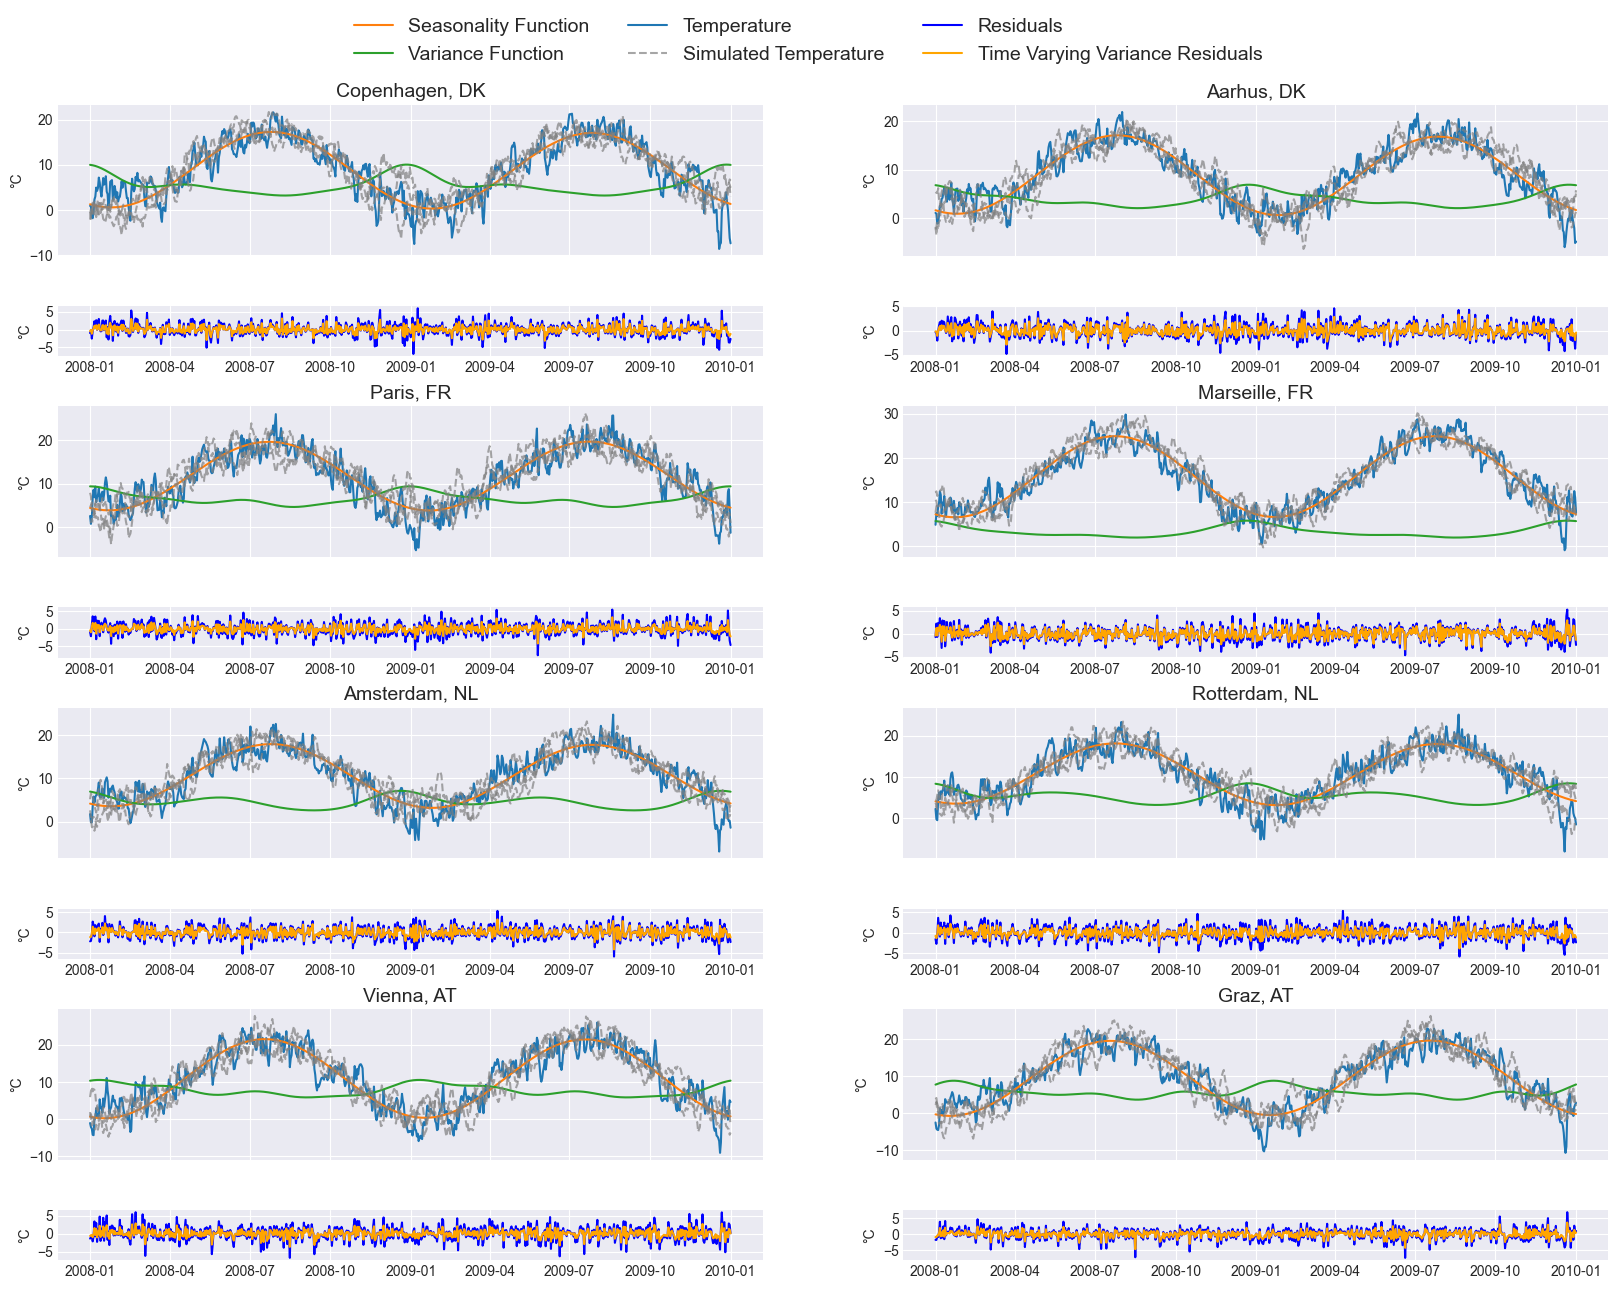

In [156]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

graph_temperature_dynamics = []

num_countries = 4
period_of_interest = [dt.datetime(2008,1,1), dt.datetime(2010,1,1)]
# Simulate n times for the graph
nsim = 3

# Define the grid layout
gs = gridspec.GridSpec(num_countries*2, 2, height_ratios=[3, 1] * num_countries, hspace = 0.50)  # 3:1 height ratio between line plot and bar chart
fig = plt.figure(figsize=(20, 15))


for i, (country, country_object) in enumerate(CAR_temperature_dict.items()):
    for j, city_object in enumerate(country_object):
        if i > num_countries - 1:
            break
        
        city_name = city_object['city']
        country_name = city_object['country']
        
        fourier_model = city_object['ar_model']['fourier_model']
        (params_cabrera, cov_cabrera)  = city_object['ar_model']['seasonality_function']
    
        ar_model = city_object['ar_model']['ar_model']
        
        city_df = city_object['ar_model']['result']
        cabrera = pd.DataFrame(seasonality_cabrera(city_df.index, *params_cabrera))
        fourier = pd.DataFrame(fourier_model.model(x=city_df.index, **fourier_model.params).y)
        
        city_df['cabrera'] = cabrera
        city_df['fourier'] = fourier        
        # Square fourier (correct?)
        city_df['fourier'] = city_df['fourier']**1.5

        xs, ys, ms = city_object['car_model'].simulate(x0=1,t0=city_df.index[0],t1=city_df.index[-1]+1,nsim=nsim)
        for sim in range(nsim):
            city_df[f'sim_{sim}'] = ms[:,sim]
        
        city_df['country'] = country
        city_df['city'] = city
        
        city_df = city_df[city_df['date'].between(*period_of_interest)]
        
        # Create the line plot on a custom-sized subplot
        ax1 = plt.subplot(gs[2*i, j])
        line3, = ax1.plot(city_df['date'], city_df['temperature_2m_avg'], label='Temperature')
        
        line1, = ax1.plot(city_df['date'], city_df['cabrera'], label='Seasonality Function')
        line2, = ax1.plot(city_df['date'], city_df['fourier'], label='Variance Function')
        for sim in range(nsim):
            line4, = ax1.plot(city_df['date'], city_df[f'sim_{sim}'], label='Simulated Temperature', alpha = 0.7, linestyle = '--', color = 'gray')

        
        ax1.set_ylabel('°C')
        
        # Create the bar chart on a custom-sized subplot below the line plot, sharing the x-axis
        ax3 = plt.subplot(gs[2*i+1, j], sharex=ax1)
        line5, = ax3.plot(city_df['date'], city_df['residuals_cv'], label='Residuals', color = 'blue')
        line6, = ax3.plot(city_df['date'], city_df['residuals_tv'], label='Time Varying Variance Residuals', color = 'orange')
        
        ax3.set_ylabel('°C')
        # Set title for the combined plot and hide grid for the secondary axis
        ax1.set_title(f'{city_name}, {country_name}', fontsize=14)

        # Hide x-ticks for ax1 since it's shared with ax3
        for label in ax1.get_xticklabels():
            label.set_visible(False)

# Add legend to the figure outside of the plots
lines = [line1, line2, line3, line4, line5, line6]
labels = [l.get_label() for l in lines]
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=3, fontsize=14)

plt.tight_layout()
plt.show()


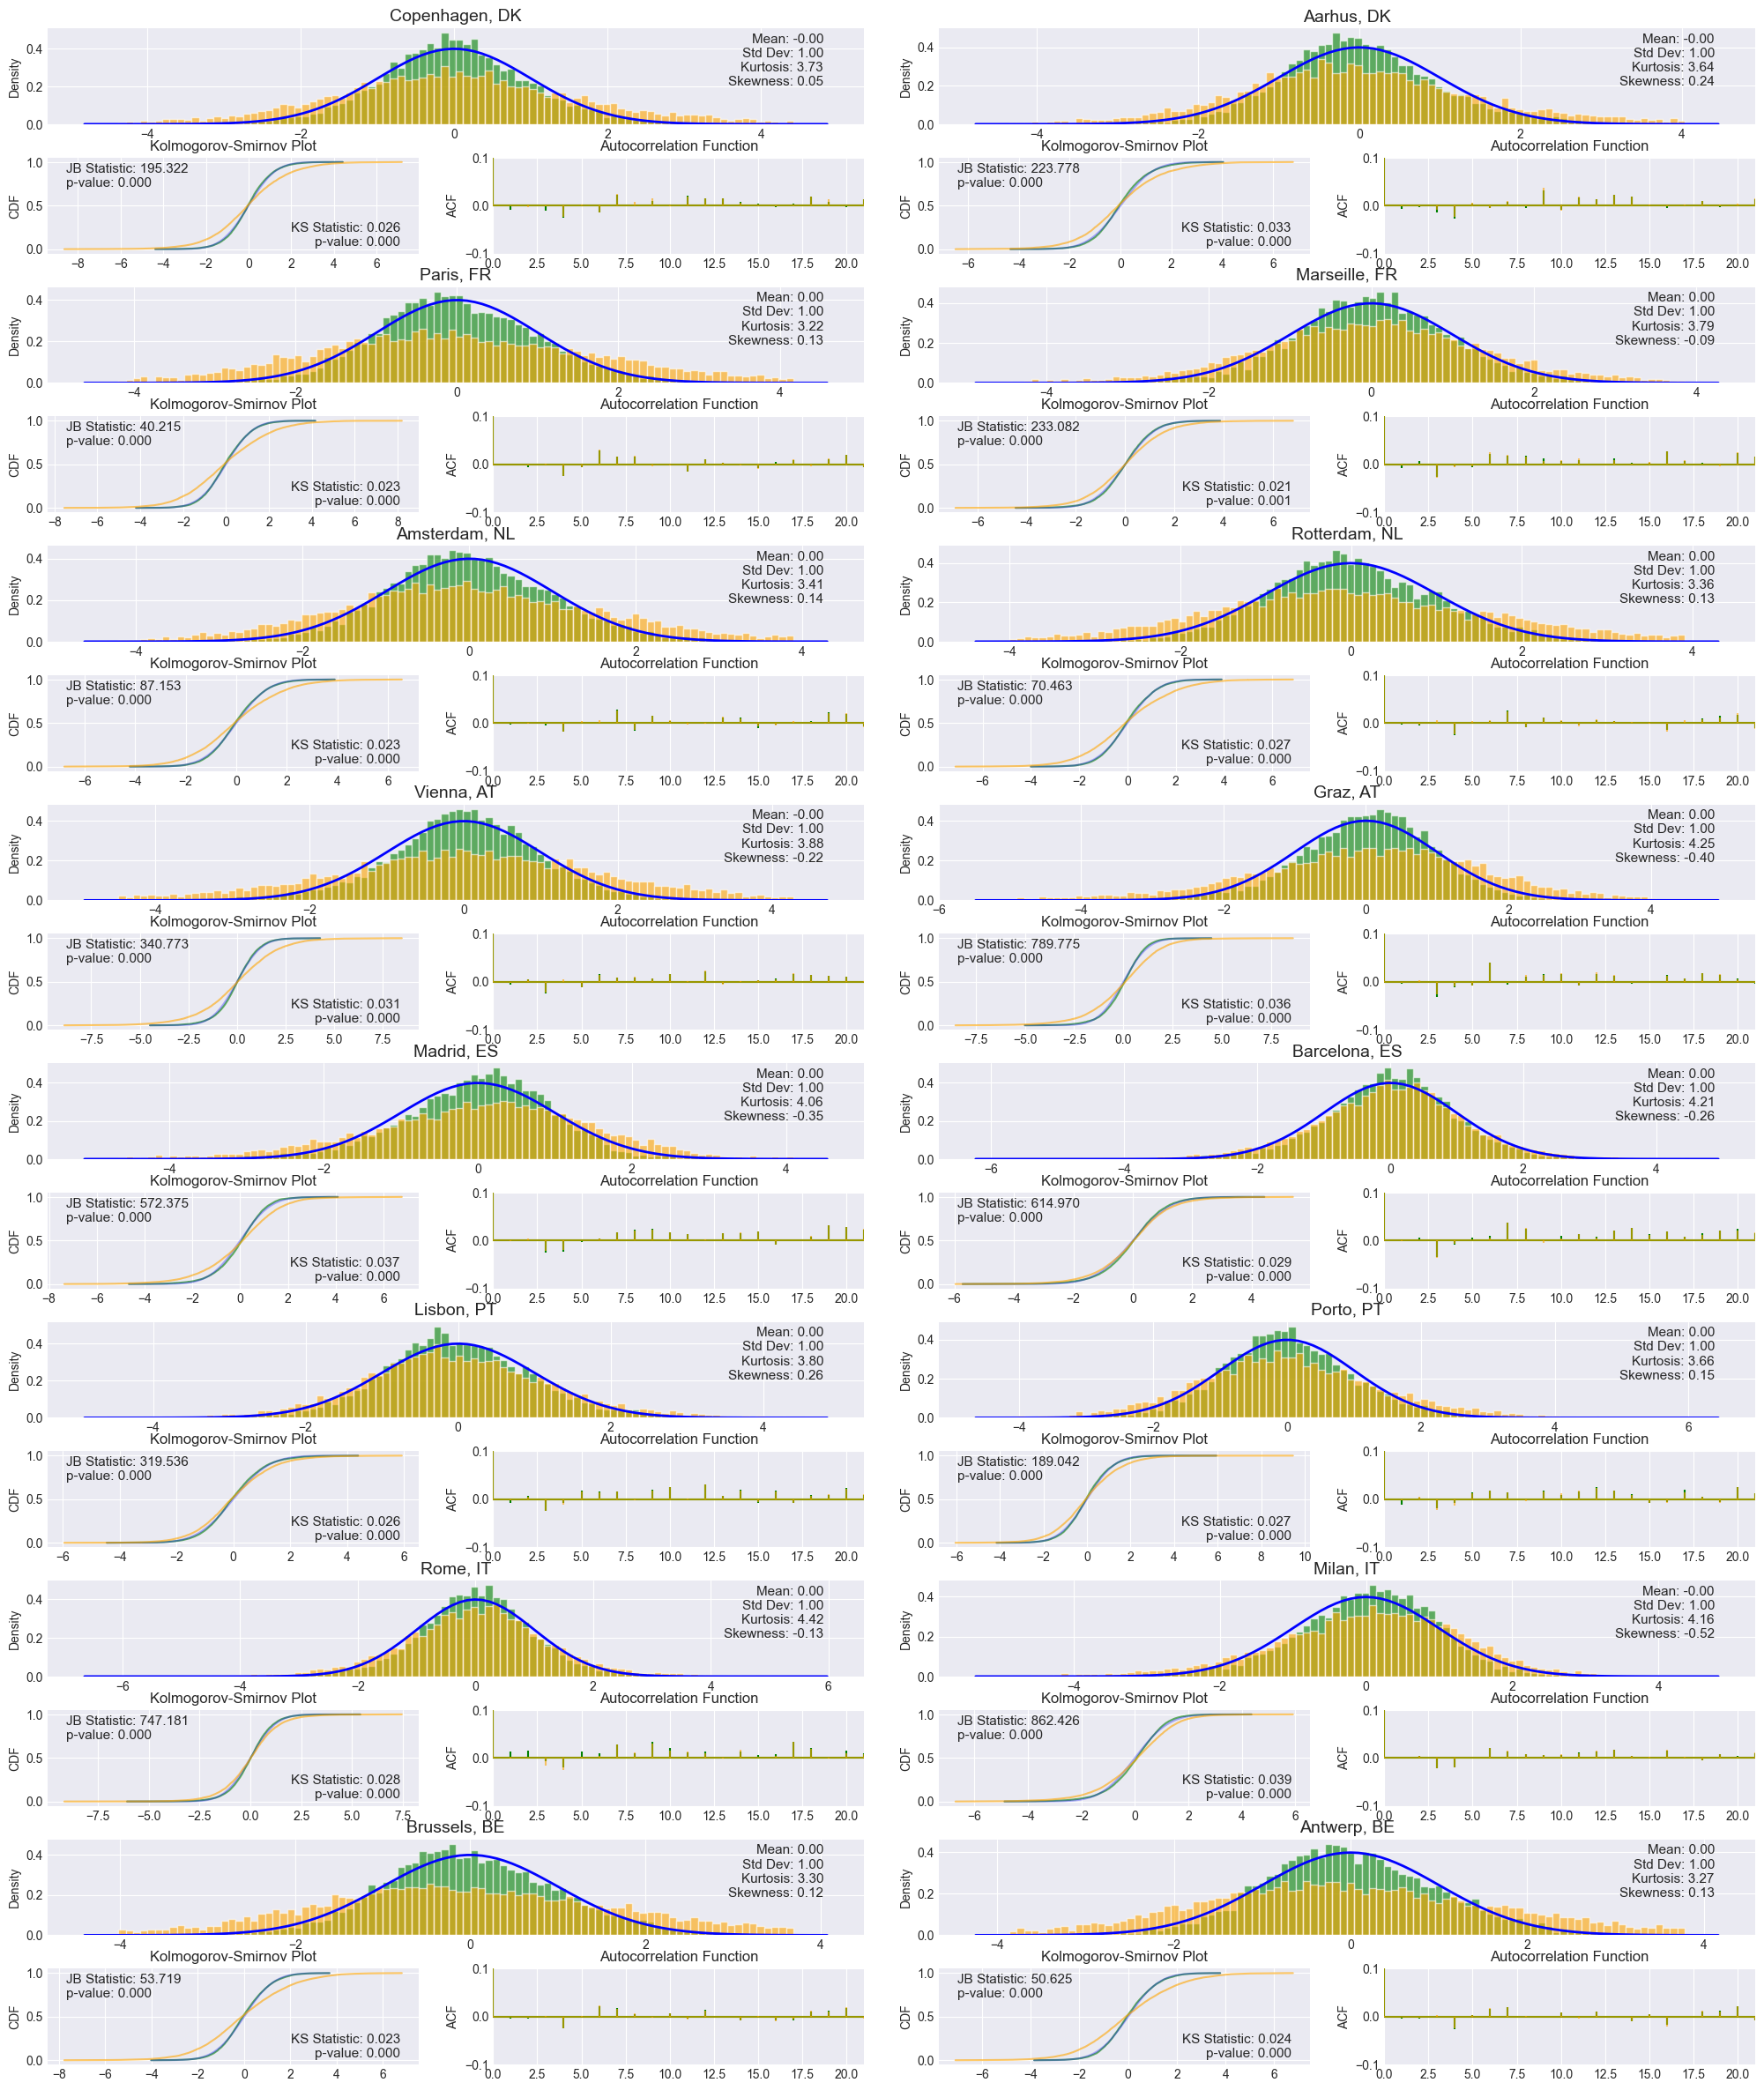

\begin{tabular}{llrrrrrrrr}
 &  & mean & std & kurtosis & skewness & ks_stat & ks_pval & jb_stat & jb_pval \\
country & city &  &  &  &  &  &  &  &  \\
\multirow[c]{2}{*}{DK} & Copenhagen & -0.00 & 1.00 & 3.73 & 0.05 & 0.03 & 0.00 & 195.32 & 0.00 \\
 & Aarhus & -0.00 & 1.00 & 3.64 & 0.24 & 0.03 & 0.00 & 223.78 & 0.00 \\
\cline{1-10}
\multirow[c]{2}{*}{FR} & Paris & 0.00 & 1.00 & 3.22 & 0.13 & 0.02 & 0.00 & 40.22 & 0.00 \\
 & Marseille & 0.00 & 1.00 & 3.79 & -0.09 & 0.02 & 0.00 & 233.08 & 0.00 \\
\cline{1-10}
\multirow[c]{2}{*}{NL} & Amsterdam & 0.00 & 1.00 & 3.41 & 0.14 & 0.02 & 0.00 & 87.15 & 0.00 \\
 & Rotterdam & 0.00 & 1.00 & 3.36 & 0.13 & 0.03 & 0.00 & 70.46 & 0.00 \\
\cline{1-10}
\multirow[c]{2}{*}{AT} & Vienna & -0.00 & 1.00 & 3.88 & -0.22 & 0.03 & 0.00 & 340.77 & 0.00 \\
 & Graz & 0.00 & 1.00 & 4.25 & -0.40 & 0.04 & 0.00 & 789.78 & 0.00 \\
\cline{1-10}
\multirow[c]{2}{*}{ES} & Madrid & 0.00 & 1.00 & 4.06 & -0.35 & 0.04 & 0.00 & 572.37 & 0.00 \\
 & Barcelona & 0.00 & 1.00 & 4.21

In [282]:
# Define the grid layout
from scipy.stats import kurtosis, skew, norm
# Import ECDF
from statsmodels.distributions.empirical_distribution import ECDF

num_countries = 8
gs = gridspec.GridSpec(num_countries*2, 4, height_ratios=[4, 4] * num_countries, hspace = 0.35)
fig = plt.figure(figsize=(25, 30))

stats_table = []

for i, (country_name, country_cities) in enumerate(CAR_temperature_dict.items()):
    for j, city_dict in enumerate(country_cities):

        
        city_name = city_dict['city']
        country_name = city_dict['country']
        city_indices = city_dict['ar_model']['result']
        
        # Compute statistics
        data = city_indices['residuals_tv'].dropna()
        data_cv = city_indices['residuals_cv'].dropna()
        mu, std = np.mean(data), np.std(data)
        kur = kurtosis(data, fisher=False)
        skw = skew(data)

        # KS test
        ks_stat, p_val = stats.kstest(data, 'norm', args=(mu, std))
        # JB test
        jb_stat, jb_pval = stats.jarque_bera(data)
        
        stats_table.append({
            'city': city_name, 
            'country': country_name,
            'mean': mu,
            'std': std,
            'kurtosis': kur,
            'skewness': skw,
            'ks_stat': ks_stat,
            'ks_pval': p_val,
            'jb_stat': jb_stat,
            'jb_pval': jb_pval
        })
        
        
        if i > num_countries - 1:
            break
        
        # y_11: Histogram of payoffs
        ax1 = plt.subplot(gs[2*i, 2*j:2*j+2])

        # bins of square root of number of observations
        bins = int(np.sqrt(len(data)))
        n, bins, patches = ax1.hist(data, bins=bins, density=True, color='g', alpha=0.6)

        xmin, xmax = ax1.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        ax1.plot(x, norm.pdf(x, mu, std), 'k', linewidth=2, label='Normal Distribution', color = 'b')
        ax1.set_ylabel('Density')
        ax1.set_title(f'{city_name}, {country_name}', fontsize=14)

        # Annotate with summary statistics including kurtosis and skewness
        stats_text = f"Mean: {mu:.2f}\nStd Dev: {std:.2f}\nKurtosis: {kur:.2f}\nSkewness: {skw:.2f}"
        ax1.annotate(stats_text, xy=(0.95, 0.95), xycoords='axes fraction', ha='right', va='top', fontsize=11)


        # y_121: Kolmogorov-Smirnov plot
        ax2 = plt.subplot(gs[2*i+1, 2*j])
        ecdf = ECDF(data)
        ax2.plot(ecdf.x, ecdf.y, label='ECDF', color = 'g', alpha = 0.6)
        ax2.plot(ecdf.x, norm.cdf(ecdf.x, loc=mu, 
                                  scale=std), label='Theoretical Normal CDF', color = 'b', alpha = 0.3)
        ax2.set_ylabel('CDF')
        ax2.set_title('Kolmogorov-Smirnov Plot')
        
        # Annotate with KS statistic and p-value
        ks_text = f"KS Statistic: {ks_stat:.3f}\np-value: {p_val:.3f}"
        ax2.annotate(ks_text, xy=(0.95, 0.05), xycoords='axes fraction', ha='right', va='bottom', fontsize=11)
        # Annotate with JB statistic and p-value
        jb_text = f"JB Statistic: {jb_stat:.3f}\np-value: {jb_pval:.3f}"
        ax2.annotate(jb_text, xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top', fontsize=11)



        # y_122: ACF
        ax3 = plt.subplot(gs[2*i+1, 2*j+1])
        ax3.acorr(data, maxlags=21, color = 'g')
        ax3.set_xlim([0, 21])
        ax3.set_ylim([-0.1,0.1])
        # Add residuals_cv (orange)
        ax1.hist(data_cv, bins=bins, density=True, color='orange', alpha=0.6)
        ecdf = ECDF(data_cv)
        ax2.plot(ecdf.x, ecdf.y, label='ECDF', color = 'orange', alpha = 0.6)
        ax3.acorr(data_cv, maxlags=21, color = 'orange', alpha = 0.6)
        
        
        ax3.set_title('Autocorrelation Function')
        ax3.set_ylabel('ACF')

plt.tight_layout()
plt.show()

stats_table = pd.DataFrame(stats_table).set_index(['country','city']).style
# Format 2f
stats_table.format('{:.2f}', subset=['mean', 'std', 'kurtosis', 'skewness', 'ks_stat', 'ks_pval', 'jb_stat', 'jb_pval'])

print(stats_table.to_latex(convert_css=True, clines= "skip-last;data", hrules = False, multicol_align = 'c', multirow_align='c'))

C:\Users\Nicky\AppData\Local\Temp\ipykernel_8340\2324091353.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


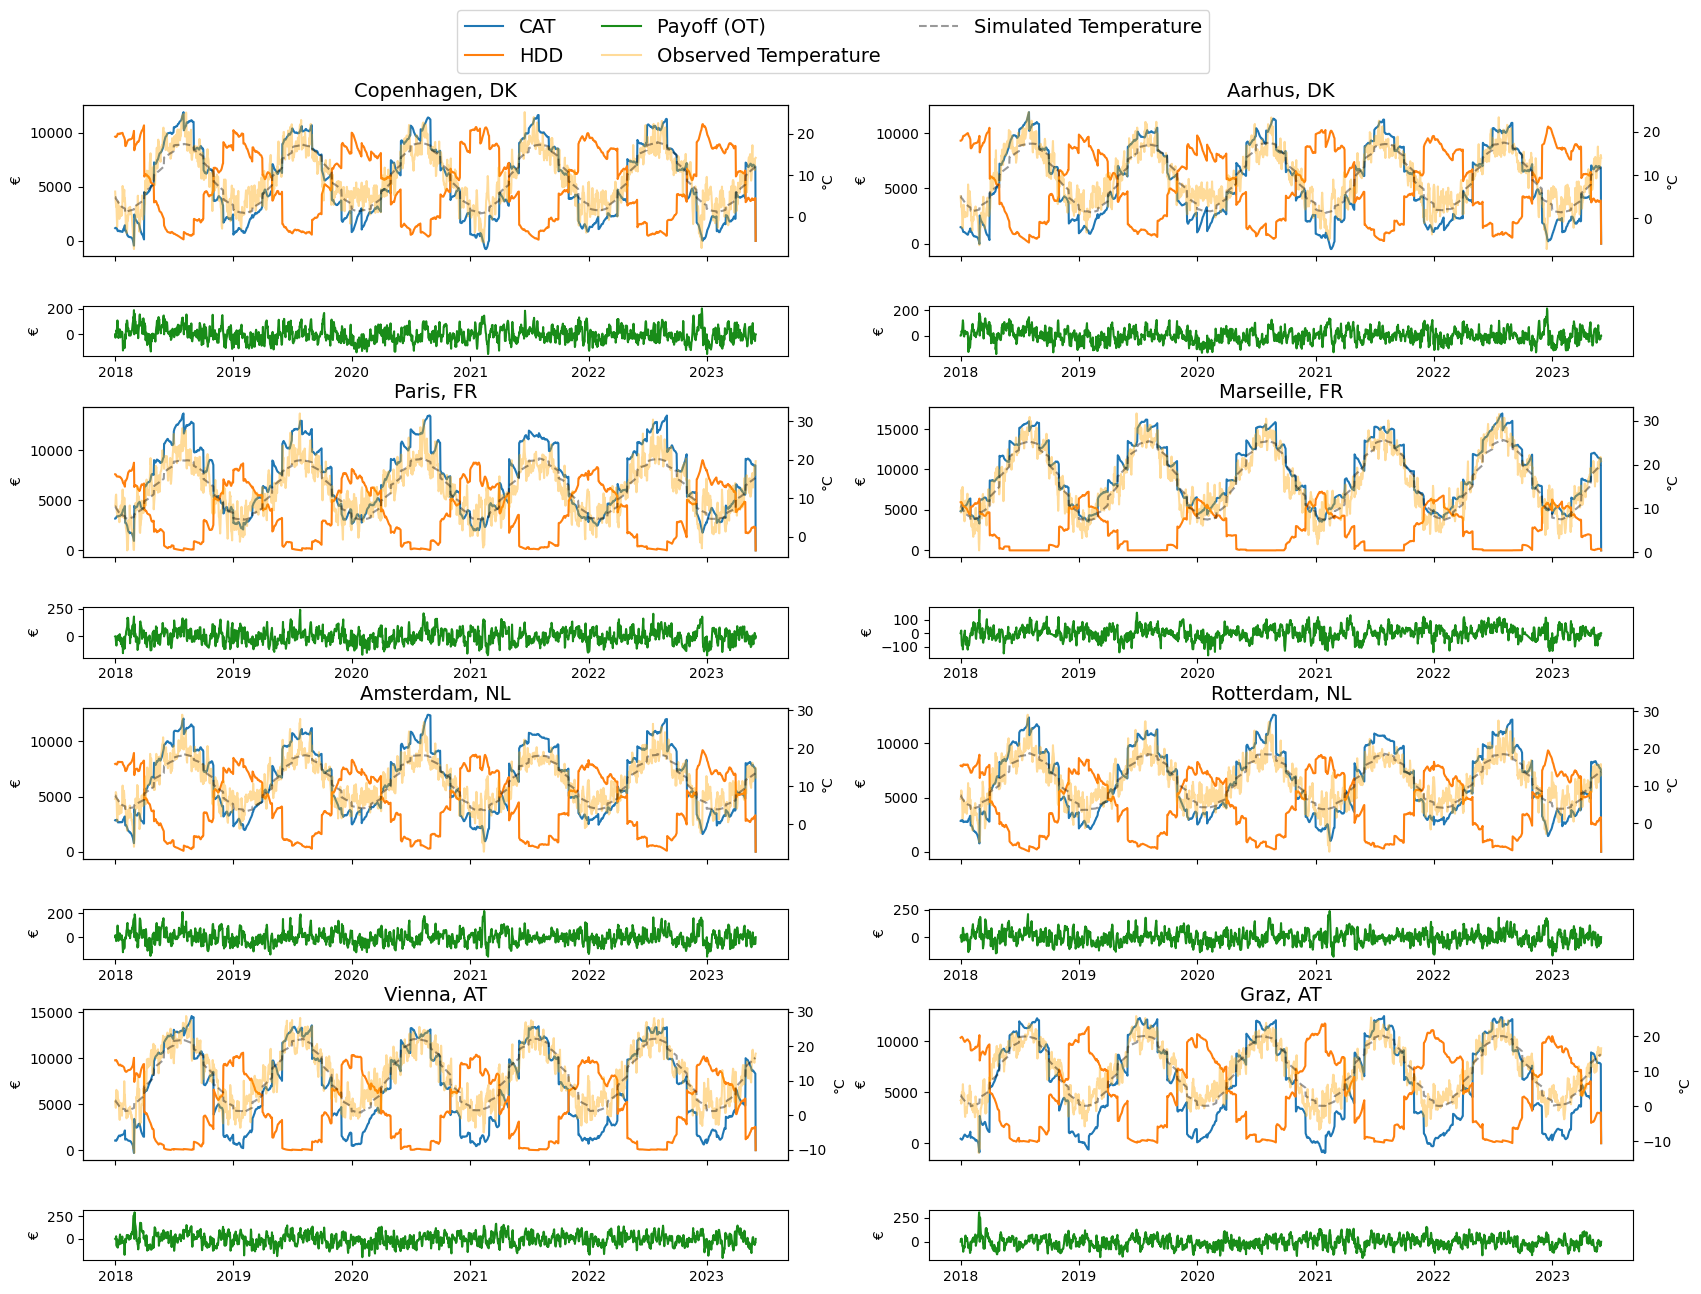

In [37]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

num_countries = 4
# Define the grid layout
gs = gridspec.GridSpec(num_countries*2, 2, height_ratios=[3, 1] * num_countries, hspace = 0.50)  # 3:1 height ratio between line plot and bar chart
fig = plt.figure(figsize=(20, 15))

for i, (country_name, country_cities) in enumerate(CAR_temperature_dict.items()):
    for j, city_dict in enumerate(country_cities):
        if i > num_countries - 1:
            break
        
        # Get the city and country name
        city_name = city_dict['city']
        country_name = city_dict['country']
        #if country_name not in ['NL','DE','FR']:
        #    continue
        city_indices = city_dict['temperature_indices']
        
        # Create the line plot on a custom-sized subplot
        ax1 = plt.subplot(gs[2*i, j])
        line1, = ax1.plot(city_indices['date'], city_indices['strip_cat_continuous'], label='CAT')
        line2, = ax1.plot(city_indices['date'], city_indices['strip_hdd_continuous'], label='HDD')
        ax1.set_ylabel('€')
        # Plot the temperature data on a secondary axis
        ax2 = ax1.twinx()
        line4, = ax2.plot(city_indices['date'], city_indices['temperature_2m_avg'], color='orange', label='Observed Temperature', alpha=0.4)
        line5, = ax2.plot(city_indices['date'], city_indices['ms'], color='black', label='Simulated Temperature', alpha = 0.4, linestyle = '--')
        ax2.set_ylabel('°C')
        
        # Create the bar chart on a custom-sized subplot below the line plot, sharing the x-axis
        ax3 = plt.subplot(gs[2*i+1, j], sharex=ax1)
        line3, = ax3.plot(city_indices['date'], city_indices['strip_ot_continuous_payoff'], label='Payoff (OT)', color = 'green', alpha = 0.9)
        ax3.set_ylabel('€')
        # Set title for the combined plot and hide grid for the secondary axis
        ax1.set_title(f'{city_name}, {country_name}', fontsize=14)
        ax2.grid(False, axis='y')
        ax2.grid(False, axis='x')

        # Hide x-ticks for ax1 since it's shared with ax3
        for label in ax1.get_xticklabels():
            label.set_visible(False)

# Add legend to the figure outside of the plots
lines = [line1, line2, line3, line4, line5]
labels = [l.get_label() for l in lines]
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=3, fontsize=14)

plt.tight_layout()
plt.show()

C:\Users\Nicky\AppData\Local\Temp\ipykernel_8340\1137100006.py:52: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax1.plot(x, norm.pdf(x, mu, std), 'k', linewidth=2, label='Normal Distribution', color = 'b')
C:\Users\Nicky\AppData\Local\Temp\ipykernel_8340\1137100006.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


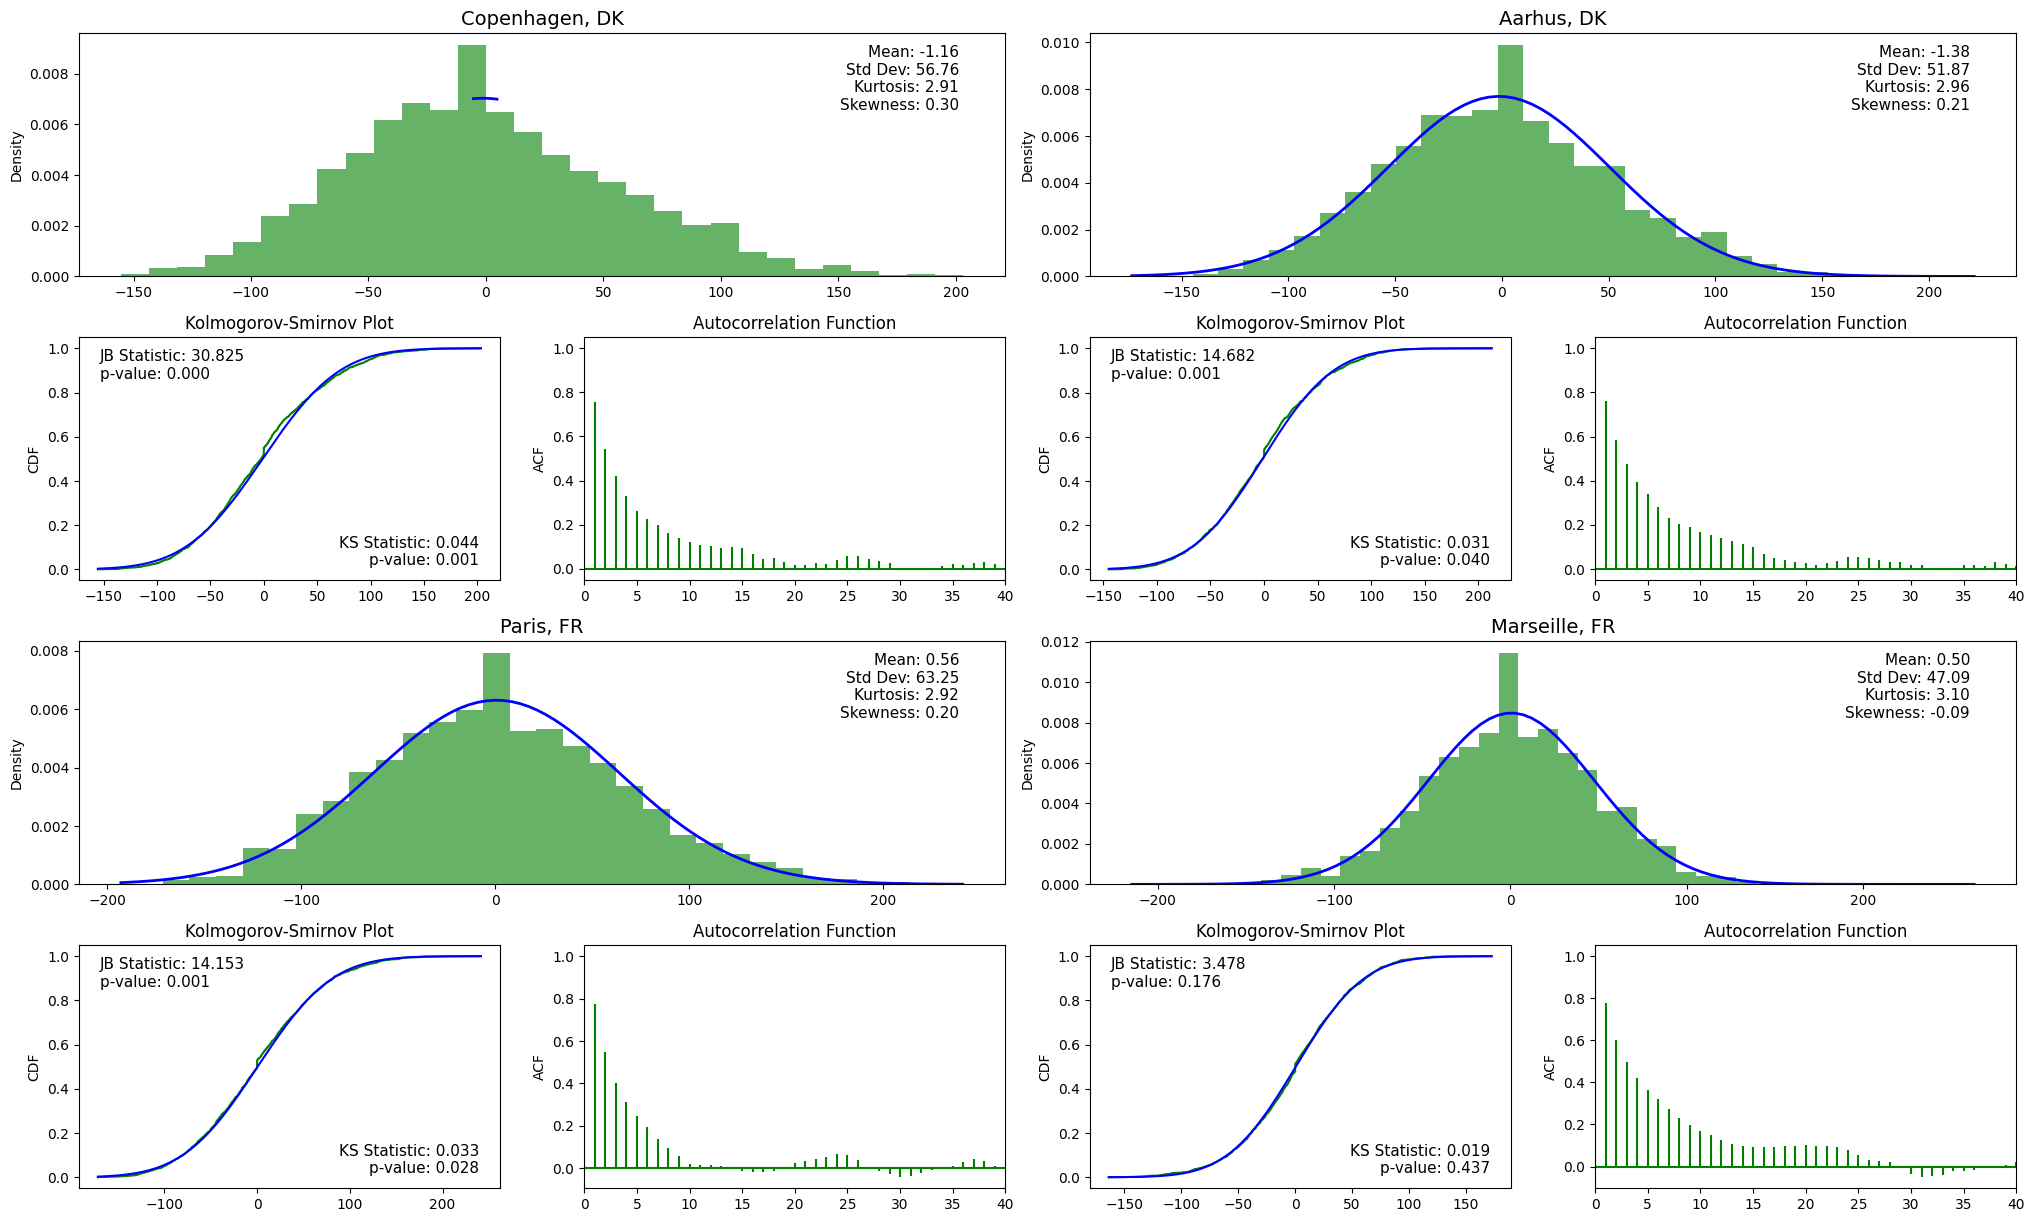

\begin{tabular}{llrrrrrrrr}
 &  & mean & std & kurtosis & skewness & ks_stat & ks_pval & jb_stat & jb_pval \\
country & city &  &  &  &  &  &  &  &  \\
\multirow[c]{2}{*}{DK} & Copenhagen & -1.16 & 56.76 & 2.91 & 0.30 & 0.04 & 0.00 & 30.83 & 0.00 \\
 & Aarhus & -1.38 & 51.87 & 2.96 & 0.21 & 0.03 & 0.04 & 14.68 & 0.00 \\
\cline{1-10}
\multirow[c]{2}{*}{FR} & Paris & 0.56 & 63.25 & 2.92 & 0.20 & 0.03 & 0.03 & 14.15 & 0.00 \\
 & Marseille & 0.50 & 47.09 & 3.10 & -0.09 & 0.02 & 0.44 & 3.48 & 0.18 \\
\cline{1-10}
\multirow[c]{2}{*}{NL} & Amsterdam & -0.97 & 56.16 & 3.56 & 0.46 & 0.05 & 0.00 & 95.90 & 0.00 \\
 & Rotterdam & -1.05 & 58.84 & 3.46 & 0.39 & 0.04 & 0.00 & 66.38 & 0.00 \\
\cline{1-10}
\multirow[c]{2}{*}{AT} & Vienna & -4.28 & 64.67 & 3.12 & 0.11 & 0.02 & 0.30 & 4.92 & 0.09 \\
 & Graz & -4.53 & 56.50 & 3.61 & 0.16 & 0.02 & 0.21 & 38.46 & 0.00 \\
\cline{1-10}
\multirow[c]{2}{*}{ES} & Madrid & 1.61 & 58.77 & 2.68 & -0.02 & 0.03 & 0.12 & 8.60 & 0.01 \\
 & Barcelona & 1.60 & 40.13 & 3.

In [35]:
# Define the grid layout
from scipy.stats import kurtosis, skew, norm
# Import ECDF
from statsmodels.distributions.empirical_distribution import ECDF

num_countries = 2
gs = gridspec.GridSpec(num_countries*2, 4, height_ratios=[4, 4] * num_countries, hspace = 0.25)
fig = plt.figure(figsize=(25, 15))

stats_table = []

for i, (country_name, country_cities) in enumerate(CAR_temperature_dict.items()):
    for j, city_dict in enumerate(country_cities):

        
        city_name = city_dict['city']
        country_name = city_dict['country']
        city_indices = city_dict['temperature_indices']
        
        # Compute statistics
        data = city_indices['strip_ot_continuous_payoff']
        mu, std = np.mean(data), np.std(data)
        kur = kurtosis(data, fisher=False)
        skw = skew(data)
        xmin, xmax = ax1.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        # KS test
        ks_stat, p_val = stats.kstest(data, 'norm', args=(mu, std))
        # JB test
        jb_stat, jb_pval = stats.jarque_bera(data)
        
        stats_table.append({
            'city': city_name, 
            'country': country_name,
            'mean': mu,
            'std': std,
            'kurtosis': kur,
            'skewness': skw,
            'ks_stat': ks_stat,
            'ks_pval': p_val,
            'jb_stat': jb_stat,
            'jb_pval': jb_pval
        })
        
        
        if i > num_countries - 1:
            continue
        
        # y_11: Histogram of payoffs
        ax1 = plt.subplot(gs[2*i, 2*j:2*j+2])
        n, bins, patches = ax1.hist(data, bins=30, density=True, color='g', alpha=0.6)
        ax1.plot(x, norm.pdf(x, mu, std), 'k', linewidth=2, label='Normal Distribution', color = 'b')
        ax1.set_ylabel('Density')
        ax1.set_title(f'{city_name}, {country_name}', fontsize=14)

        # Annotate with summary statistics including kurtosis and skewness
        stats_text = f"Mean: {mu:.2f}\nStd Dev: {std:.2f}\nKurtosis: {kur:.2f}\nSkewness: {skw:.2f}"
        ax1.annotate(stats_text, xy=(0.95, 0.95), xycoords='axes fraction', ha='right', va='top', fontsize=11)


        # y_121: Kolmogorov-Smirnov plot
        ax2 = plt.subplot(gs[2*i+1, 2*j])
        ecdf = ECDF(data)
        ax2.plot(ecdf.x, ecdf.y, label='ECDF', color = 'g')
        ax2.plot(ecdf.x, norm.cdf(ecdf.x, loc=mu, 
                                  scale=std), label='Theoretical Normal CDF', color = 'b')
        ax2.set_ylabel('CDF')
        ax2.set_title('Kolmogorov-Smirnov Plot')
        
        # Annotate with KS statistic and p-value
        ks_text = f"KS Statistic: {ks_stat:.3f}\np-value: {p_val:.3f}"
        ax2.annotate(ks_text, xy=(0.95, 0.05), xycoords='axes fraction', ha='right', va='bottom', fontsize=11)
        # Annotate with JB statistic and p-value
        jb_text = f"JB Statistic: {jb_stat:.3f}\np-value: {jb_pval:.3f}"
        ax2.annotate(jb_text, xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top', fontsize=11)



        # y_122: ACF
        ax3 = plt.subplot(gs[2*i+1, 2*j+1])
        ax3.acorr(data, maxlags=40, color = 'g')
        ax3.set_xlim([0, 40])
        
        ax3.set_title('Autocorrelation Function')
        ax3.set_ylabel('ACF')

plt.tight_layout()
plt.show()

stats_table = pd.DataFrame(stats_table).set_index(['country','city']).style
# Format 2f
stats_table.format('{:.2f}', subset=['mean', 'std', 'kurtosis', 'skewness', 'ks_stat', 'ks_pval', 'jb_stat', 'jb_pval'])

print(stats_table.to_latex(convert_css=True, clines= "skip-last;data", hrules = False, multicol_align = 'c', multirow_align='c'))

(1): Analyze the residuals of the above models

(2): Analyze the correlation of the indices/payoffs with the electricity prices


In [157]:
# Create temperature_indices_df
pd.options.mode.chained_assignment = None  # default='warn'

temperature_indices_df = []
for country_name, country_cities in CAR_temperature_dict.items():
    for i, city_dict in enumerate(country_cities):
        city_indices = city_dict.get('temperature_indices')
        # Only keep date and .*(continious).* columns e..g continious_monthly
        city_indices = city_indices.filter(regex='(date|.*strip_ot_continuous_payoff.*)')
        # indice will be called 
        city_indices['city'] = city_dict.get('city')
        city_indices['country'] = city_dict.get('country')
        temperature_indices_df.append(city_indices)
        
temperature_indices_df = pd.concat(temperature_indices_df)
# Date will be the index column, the value columns will become monthly_strip_cat_continuous_{city}_{country} where city and country were columns
temperature_indices_df['city_country'] = (temperature_indices_df['city'] + '_' + temperature_indices_df['country']).str.lower()
# Drop the city and country columns
temperature_indices_df = temperature_indices_df.drop(columns=['city', 'country'])
temperature_indices_df = temperature_indices_df.pivot(index='date', columns='city_country')
temperature_indices_df.columns = [f'{col[0]}_{col[1]}' for col in temperature_indices_df.columns]

temperature_indices_df = temperature_indices_df.reset_index()

temperature_indices_df.head(5)

date  strip_ot_continuous_payoff_aarhus_dk  \
0 2018-01-01                              0.000000   
1 2018-01-02                              0.547287   
2 2018-01-03                              9.902884   
3 2018-01-04                             33.326504   
4 2018-01-05                             25.349017   

   strip_ot_continuous_payoff_amsterdam_nl  \
0                                 0.000000   
1                                17.289827   
2                                -0.755557   
3                               -32.424226   
4                               -30.023665   

   strip_ot_continuous_payoff_antwerp_be  \
0                               0.000000   
1                              23.470639   
2                             -10.048836   
3                             -45.151616   
4                             -42.371295   

   strip_ot_continuous_payoff_barcelona_es  \
0                                 0.000000   
1                                19.740912   
2                                 5.119082   
3                               -74.516785   
4                               -84.805432   

   strip_ot_continuous_payoff_berlin_de  \
0                              0.000000   
1                            -56.211081   
2                             -4.994701   
3                            -14.429662   
4                            -50.276073   

   strip_ot_continuous_payoff_brussels_be  \
0                                0.000000   
1                               25.165331   
2                               -5.534016   
3                              -49.191844   
4                              -51.594786   

   strip_ot_continuous_payoff_copenhagen_dk  \
0                                  0.000000   
1                                -26.650559   
2                                 -5.972932   
3                                 10.306728   
4                                 27.417701   

   strip_ot_continuous_payoff_graz_at  strip_ot_continuous_payoff_hamburg_de  \
0                            0.000000                               0.000000   
1                           29.586704                             -21.761372   
2                           16.478750                              11.399544   
3                           36.238719                             -24.213424   
4                           28.527661                             -32.118664   

   strip_ot_continuous_payoff_lisbon_pt  strip_ot_continuous_payoff_madrid_es  \
0                              0.000000                              0.000000   
1                             54.363909                             68.133927   
2                             26.523075                             -6.762910   
3                             -8.676742                            -68.903336   
4                             -8.235196                            -59.132507   

   strip_ot_continuous_payoff_marseille_fr  \
0                                 0.000000   
1                                11.780565   
2                                19.084934   
3                               -55.252279   
4                               -89.477644   

   strip_ot_continuous_payoff_milan_it  strip_ot_continuous_payoff_paris_fr  \
0                             0.000000                             0.000000   
1                            45.209052                            -3.566031   
2                             9.647949                           -31.128272   
3                            34.348775                           -70.513288   
4                            22.648100                           -81.139691   

   strip_ot_continuous_payoff_porto_pt  strip_ot_continuous_payoff_rome_it  \
0                             0.000000                            0.000000   
1                            32.086877                           -0.509182   
2                           -10.113049                           41.152443   
3                  

In [169]:
prices_df = daily_entsoe_category_revenue[['date','country_code','price']].drop_duplicates()
# Pivot price area to columns
prices_df = prices_df.pivot(index='date', columns='country_code', values='price')

prices_df = pd.merge(prices_df, 
                     temperature_indices_df, left_on=['date'], right_on=[ 'date'], how='inner')

# Create correlation matrix
# Countries to list
corr_matrix = prices_df.corr()[['AT', 'BE', 'DE','DK','ES','FR','NL','PT']]
# Stylize the correlation matrix
corr_matrix = corr_matrix.style.set_precision(2)
# Set background .background_gradient(cmap='coolwarm') blue for negative, red for positive
cmap = sns.diverging_palette(220, 10, as_cmap=True)

corr_matrix = corr_matrix.background_gradient(cmap=cmap, axis=None, vmin=-1, vmax=1)
# ratio is -1 to 1
 
# Set the max and min values
#corr_matrix
print(corr_matrix.to_latex(convert_css=True, clines= "skip-last;data", hrules = False, multicol_align = 'c', multirow_align='c'))


\begin{tabular}{lrrrrrrrr}
 & AT & BE & DE & DK & ES & FR & NL & PT \\
AT & {\cellcolor[HTML]{DA3B46}} \color[HTML]{F1F1F1} 1.00 & {\cellcolor[HTML]{DA3D49}} \color[HTML]{F1F1F1} 0.98 & {\cellcolor[HTML]{DA3D49}} \color[HTML]{F1F1F1} 0.98 & {\cellcolor[HTML]{DD515C}} \color[HTML]{F1F1F1} 0.87 & {\cellcolor[HTML]{E27880}} \color[HTML]{F1F1F1} 0.66 & {\cellcolor[HTML]{DA3C48}} \color[HTML]{F1F1F1} 0.99 & {\cellcolor[HTML]{DA3C48}} \color[HTML]{F1F1F1} 0.98 & {\cellcolor[HTML]{E27880}} \color[HTML]{F1F1F1} 0.66 \\
BE & {\cellcolor[HTML]{DA3D49}} \color[HTML]{F1F1F1} 0.98 & {\cellcolor[HTML]{DA3B46}} \color[HTML]{F1F1F1} 1.00 & {\cellcolor[HTML]{DA3D49}} \color[HTML]{F1F1F1} 0.98 & {\cellcolor[HTML]{DD515C}} \color[HTML]{F1F1F1} 0.87 & {\cellcolor[HTML]{E27981}} \color[HTML]{F1F1F1} 0.66 & {\cellcolor[HTML]{DA3D49}} \color[HTML]{F1F1F1} 0.98 & {\cellcolor[HTML]{DA3B46}} \color[HTML]{F1F1F1} 0.99 & {\cellcolor[HTML]{E27981}} \color[HTML]{F1F1F1} 0.66 \\
DE & {\cellcolor[HTML]{DA3D49}} \colo

#### 4.2.1 Portfolio Time Series (category)

In [231]:
# Set up constraints on which derivatives can be used for which country
DERIVATIVES_COUNTRY_CONSTRAINTS = {
    'NL' : {
        'temperature' : ['strip_ot_continuous_payoff_amsterdam_nl'],
        'wind' : []
    },
    'BE' : {
        'temperature' : ['strip_ot_continuous_payoff_brussels_be'],
        'wind' : []
    },
    'DE' : {
        'temperature' : ['strip_ot_continuous_payoff_hamburg_de'],
        'wind' : []
    },
    'DK' : {
        'temperature' : ['strip_ot_continuous_payoff_copenhagen_dk'],
        'wind' : []
    },
    'FR' : {
        'temperature' : ['strip_ot_continuous_payoff_paris_fr'],
        'wind' : []
    },
    #'NO' : {
    #    'temperature' : ['strip_ot_continuous_payoff_oslo_no'],
    #    'wind' : []
    #},
    'ES' : {
        'temperature' : ['strip_ot_continuous_payoff_madrid_es'],
        'wind' : []
    },
        'PT' : {
        'temperature' : ['strip_ot_continuous_payoff_lisbon_pt'],
        'wind' : []
    },
    #'CH' : {
    #    'temperature' : ['strip_ot_continuous_payoff_zürich_ch'],
    #    'wind' : []
    #},
    'AT' : {
        'temperature' : ['strip_ot_continuous_payoff_vienna_at'],
        'wind' : []
    },
    'IT' : {
        'temperature' : ['strip_ot_continuous_payoff_rome_it'],
        'wind' : []
    },
}

# IN-SAMPLE PERIOD
IN_SAMPLE_DATE = '2024-01-01'
# Validate ...

In [232]:
# Merge the revenue and temperature indices
portfolio_df = pd.merge(daily_entsoe_category_revenue, temperature_indices_df, left_on=['date'], right_on=[ 'date'], how='inner')
portfolio_df_pivot = portfolio_df.melt(id_vars=[col for col in portfolio_df.columns if not col.startswith('revenue_')], var_name='ppa_structure', value_name='revenue')
portfolio_df_pivot['revenue'] = pd.to_numeric(portfolio_df_pivot['revenue'], errors='coerce')
portfolio_df_pivot['month'] = portfolio_df_pivot['date'].dt.month
portfolio_df_pivot['year'] = portfolio_df_pivot['date'].dt.year
portfolio_df_pivot.head(5)

date generation_type country_code      price  price_fixed  generation  \
0 2018-01-01         biomass           BE   4.626667    47.639999      3664.0   
1 2018-01-01         biomass           DE -24.330000    40.020000    351217.0   
2 2018-01-01         biomass           ES   7.959583    58.344999      6602.0   
3 2018-01-01         biomass           FR   2.982083    46.230000      7051.0   
4 2018-01-01         biomass           IT  43.831563    59.150002     20558.0   

   strip_ot_continuous_payoff_aarhus_dk  \
0                                   0.0   
1                                   0.0   
2                                   0.0   
3                                   0.0   
4                                   0.0   

   strip_ot_continuous_payoff_amsterdam_nl  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   strip_ot_continuous_payoff_antwerp_be  \
0                                    0.0   
1                                    0.0   
2                                    0.0   
3                                    0.0   
4                                    0.0   

   strip_ot_continuous_payoff_barcelona_es  ...  \
0                                      0.0  ...   
1                                      0.0  ...   
2                                      0.0  ...   
3                                      0.0  ...   
4                                      0.0  ...   

   strip_ot_continuous_payoff_milan_it  strip_ot_continuous_payoff_paris_fr  \
0                                  0.0                                  0.0   
1                                  0.0                                  0.0   
2                                  0.0                                  0.0   
3                                  0.0                                  0.0   
4                                  0.0                                  0.0   

   strip_ot_continuous_payoff_porto_pt  strip_ot_continuous_payoff_rome_it  \
0                                  0.0                                 0.0   
1                                  0.0                                 0.0   
2                                  0.0                                 0.0   
3                                  0.0                                 0.0   
4                                  0.0                                 0.0   

   strip_ot_continuous_payoff_rotterdam_nl  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   strip_ot_continuous_payoff_vienna_at    ppa_structure       revenue  month  \
0                                   0.0  revenue_dynamic  1.745530e+05      1   
1                                   0.0  revenue_dynamic  1.405570e+07      1   
2                                   0.0  revenue_dynamic  3.851937e+05      1   
3                                   0.0  revenue_dynamic  3.259677e+05      1   
4                                   0.0  revenue_dynamic  1.216006e+06      1   

   year  
0  2018  
1  2018  
2  2018  
3  2018  
4  2018  

[5 rows x 28 columns]

In [173]:
from scipy.optimize import minimize

def optim_func(w, df, revenue_column, derivative_columns):
    # Compute the total variance, s.t. VAR(revenue_column + SUM(w_i * derivative_columns))
    # We want to minimize this
    return np.var(df[revenue_column].values + np.dot(w, df[derivative_columns].values.T))

In [233]:

portfolio_df_pivot['derivatives'] = None
portfolio_df_pivot['optimal_weights'] = None
portfolio_df_pivot['optimal_revenue'] = None

for tso_country, derivative_constraint in DERIVATIVES_COUNTRY_CONSTRAINTS.items():
    # Select the temporary data for the country
    print(f"Optimizing for {tso_country}")
    _temp = portfolio_df_pivot[portfolio_df_pivot['country_code'] == tso_country]
    
    _temperature_derivatives = [col for col in _temp.columns if col in derivative_constraint['temperature']]
    _wind_derivatives = [col for col in _temp.columns if col in derivative_constraint['wind']]
    
    _derivatives = _temperature_derivatives + _wind_derivatives
    # Iterate over the generation_type 
    for _generation_type, _generation_type_df in _temp.groupby('generation_type'):
        #if _generation_type != 'fossil_gas':
        #    continue
        for _ppa_structure, _ppa_structure_df in _generation_type_df.groupby('ppa_structure'):
            #print(f"{_generation_type}: {_ppa_structure} ({tso_country})")
            # Iterate over every month, year combination
            for _month, _month_df in _ppa_structure_df.groupby('month'):
                # Train the model on the data before the in-sample date, we do not have it rolling so nothing is updated after the in-sample date
                _training_df = _month_df[_month_df['date'] < IN_SAMPLE_DATE]
                # Starting point is simply 0 for all derivatives
                x0 = np.zeros(len(_derivatives))
                bounds = [(None, None) for _ in range(len(_derivatives))]
                optimal_weight = minimize(optim_func, x0=x0, args=(_training_df, 'revenue', _derivatives), method='Nelder-Mead', tol=1e-6, bounds=bounds)
                # Create a new DataFrame with the derivatives and optimal weights
                result_df = pd.DataFrame({
                    'derivatives': [_derivatives],
                    'optimal_weights': [optimal_weight.x],
                    'optimal_revenue': np.dot(optimal_weight.x, _month_df[_derivatives].values.T) + _month_df['revenue'].values,
                }, index=_month_df.index)

                # Set the new DataFrame to the desired location in portfolio_df_pivot
                portfolio_df_pivot.loc[_month_df.index, ['derivatives', 'optimal_weights', 'optimal_revenue']] = result_df.values

Optimizing for NL
Optimizing for BE
Optimizing for DE
Optimizing for DK
Optimizing for FR
Optimizing for ES
Optimizing for PT
Optimizing for AT
Optimizing for IT


In [210]:
# You have country_code, generation_type and ppa_structure, year which are categorical variables.

# We are interested in the variance reduction for every combination of these categorical variables.
# Also, we are interested in the cost of hedging for every combination of these categorical variable (as a percentage of the revenue).
# We are also interested in the weight of the derivatives for every combination of these categorical variables.

# Instead of focussing on the different ppa_structures, let's first focus on the revenue_dynamic 

# Columns are the countries

# First index is the generation_type
# Second index is the year

dynamic_revenue_df = portfolio_df_pivot[portfolio_df_pivot['ppa_structure'] == 'revenue_dynamic']
dynamic_revenue_df = dynamic_revenue_df[dynamic_revenue_df['generation_type'].isin(['fossil_gas','wind_onshore', 'wind_offshore'])]
dynamic_revenue_df = dynamic_revenue_df[dynamic_revenue_df['year'] != 2018]

# Group by country_code, generation_type and year
dynamic_revenue_df = dynamic_revenue_df.groupby(['country_code', 'generation_type', 'year']).agg({
    'revenue' : [np.sum,np.var],
    'optimal_revenue': [np.sum,np.var]
    #'revenue': lambda x: np.percentile(x, 5),
    #'optimal_revenue': lambda x: np.percentile(x, 5),
})
dynamic_revenue_df.columns = ['revenue_sum', 'revenue_var', 'optimal_revenue_sum', 'optimal_revenue_var']

# If dynamic_revenue_df['revenue'] is 0 then we cannot compute the variance reduction, so we set it to NaN instead
# ZeroDivisionError: float division by zero
dynamic_revenue_df['variance_reduction'] = dynamic_revenue_df.apply(
    lambda row: np.nan if row['revenue_var'] == 0 else (1- row['optimal_revenue_var'] / row['revenue_var'])*100,
    axis=1
)

dynamic_revenue_df['cost_of_hedging'] = dynamic_revenue_df.apply(
    lambda row: np.nan if row['revenue_sum'] == 0 else ((row['optimal_revenue_sum'] - row['revenue_sum'] ) / row['revenue_sum'])*100,
    axis=1
)

# Style the dataframe such that the index is the generation_type and the columns are the country_code
# The values that are displayed would be the variance_reduction and cost_of_hedging

# We can use the pivot_table function to do this

dynamic_revenue_df = dynamic_revenue_df.pivot_table(index=['generation_type','year'], columns='country_code', values=['variance_reduction', 'cost_of_hedging'])

styled_table = dynamic_revenue_df['cost_of_hedging'].style
# Format .2f
styled_table.format("{:.2f}\%")
# To latex (% to \%)
 
#print(styled_table.to_latex(convert_css=True, clines= "skip-last;data", hrules = False, multicol_align = 'c', multirow_align='c'))
styled_table

In [250]:
# Tabular stuff Category
import calendar

# (1): Dynamic Sharpe Ratios
# (2): Dynamic Weight

analysis_df = portfolio_df_pivot[portfolio_df_pivot['ppa_structure'] == 'revenue_dynamic']
analysis_df['optimal_weights'] = analysis_df['optimal_weights'].apply(tuple)

# For each generation type
for _generation_type, _generation_type_df in analysis_df.groupby('generation_type'):
    print(f"Generation Type: {_generation_type}")
    _generation_type_df['year'] = 'fk'

    # (1) Dynamic Sharpe Ratios
    stats_df = _generation_type_df.groupby(['country_code','year']).agg({'revenue': ['mean','var', 'std','sum'], 'optimal_revenue': ['mean','var', 'std','sum']}).reset_index()
    stats_df['revenue_sharpe'] = stats_df['revenue']['mean'] / stats_df['revenue']['std'] 
    stats_df['optimal_revenue_sharpe'] = stats_df['optimal_revenue']['mean'] / stats_df['optimal_revenue']['std'] 
    
        # Create a new column to differentiate between revenue_sharpe and optimal_revenue_sharpe
        
    stats_df['variance_reduction'] = stats_df.apply(
        lambda row: np.nan if row['revenue']['var'] == 0 else (1- row['optimal_revenue']['var'] / row['revenue']['var'])*100,
        axis=1
    )
    stats_df['cost_of_hedging'] = stats_df.apply(
        lambda row: np.nan if row['revenue']['sum'] == 0 else (row['optimal_revenue']['sum'] - row['revenue']['sum'])/row['revenue']['sum']*100,
        axis=1
    )
    
    values = ['revenue_sharpe', 'optimal_revenue_sharpe', 'variance_reduction', 'cost_of_hedging']

    stats_df = stats_df.pivot(index=['year'], columns=['country_code'], values=values)
    # Reset the column levels so they are combined into a single level
    stats_df.columns = stats_df.columns.map('_'.join).str.strip('_')
    # Melt the DataFrame to long form
    stats_df = stats_df.reset_index().melt(id_vars=['year'], value_vars=[col for col in stats_df.columns if col != 'year'])


    
    stats_df['sharpe'] = stats_df['variable'].str.extract(f'({"|".join(values)})')
    stats_df['country_code'] = stats_df['variable'].str.extract('([A-Z]{2})')
    # Pivot the DataFrame to get it back to wide form, but in the desired format
    stats_df = stats_df.pivot_table(index=[ 'year', 'sharpe'], columns='country_code', values='value')
    # Format 3f
    stats_df = stats_df.applymap(lambda x: f"{x:.3f}").reset_index()
    stats_df = stats_df.drop(columns=['year']).set_index('sharpe')
    #print(df_capacity_latest.to_latex(convert_css=True, clines= "skip-last;data", hrules = False, multicol_align = 'c', multirow_align='c'))

    # (2): Dynamic Weight
    
    weights_df = _generation_type_df.groupby(['country_code', 'month']).agg({
        # optimal weights first observation
        'optimal_weights' : 'first',
        'generation' : 'mean'
    }).reset_index()

    # Pivot on month, and extract the optimal weights
    weights_df['optimal_weights'] = weights_df['optimal_weights'].apply(lambda x: x[0])
    weights_df['optimal_weights'] = weights_df['optimal_weights']  / weights_df['generation']

    weights_df = weights_df.pivot_table(index=['month'], columns='country_code', values='optimal_weights')
    # Format 3f
    weights_df = weights_df.applymap(lambda x: f"{x:.3f}")
    
    
    # Concat the stats_df and weights_df, 
    # convert the index to monthly names (e.g. January, February, etc.)
    weights_df.index = weights_df.index.map(lambda x : calendar.month_name[x])
    # Convert the index of stats_df to equations
    # cost_of_hedging is $\frac{\sum{R_\text{H}-R_\text{P}}}{\sum{R_\text{P}}}$
    # sharpe_optimal_revenue is $\frac{\bar{R_\text{H}}}{\sigma_{R_\text{H}}}$
    # sharpe_revenue is $\frac{\bar{R_\text{P}}}{\sigma_{R_\text{P}}}$ 
    # variance_reduction is $1-\frac{\sigma_{R_\text{P}}^2}{\sigma_{R_\text{P}}^2}$
    equation_dict = {
        'cost_of_hedging' : r"$\frac{\sum{R_\text{H}-R_\text{P}}}{\sum{R_\text{P}}}$",
        'optimal_revenue_sharpe' : r"$\frac{\bar{R_\text{H}}}{\sigma_{R_\text{H}}}$",
        'revenue_sharpe' : r"$\frac{\bar{R_\text{P}}}{\sigma_{R_\text{P}}}$",
        'variance_reduction' : r"$1-\frac{\sigma_{R_\text{P}}^2}{\sigma_{R_\text{P}}^2}$"
    }
    stats_df.index = stats_df.index.map(lambda x: equation_dict[x])
    
    concat_df = pd.concat([stats_df, weights_df], axis=0)
    
    
    print(concat_df.style.to_latex(convert_css=True, clines= "skip-last;data", hrules = False, multicol_align = 'c', multirow_align='c'))

    


Generation Type: biomass
\begin{tabular}{llllllllll}
country_code & AT & BE & DE & DK & ES & FR & IT & NL & PT \\
$\frac{\sum{R_\text{H}-R_\text{P}}}{\sum{R_\text{P}}}$ & 1.072 & -0.684 & -0.663 & -0.865 & -3.079 & 0.097 & -2.639 & -1.419 & -2.794 \\
$\frac{\bar{R_\text{H}}}{\sigma_{R_\text{H}}}$ & 0.983 & 1.070 & 1.261 & 1.551 & 1.637 & 1.026 & 1.045 & 0.607 & 1.697 \\
$\frac{\bar{R_\text{P}}}{\sigma_{R_\text{P}}}$ & 0.957 & 1.069 & 1.257 & 1.528 & 1.563 & 1.017 & 1.054 & 0.612 & 1.558 \\
$1-\frac{\sigma_{R_\text{P}}^2}{\sigma_{R_\text{P}}^2}$ & 3.119 & 1.611 & 2.021 & 4.654 & 14.390 & 1.450 & 3.527 & 1.408 & 20.354 \\
January & 0.369 & -0.082 & 0.167 & -0.157 & 0.054 & -0.111 & -0.116 & 0.139 & 0.166 \\
February & 0.016 & 0.034 & 0.122 & -0.150 & 0.442 & 0.096 & -0.012 & 0.251 & 0.632 \\
March & -0.185 & 0.148 & 0.014 & -0.150 & 0.042 & 0.084 & -0.296 & 0.478 & 0.028 \\
April & -0.231 & -0.126 & -0.208 & 0.077 & 0.248 & -0.181 & -0.390 & -0.462 & 0.365 \\
May & -0.783 & -0.085 & -0.0

##### 4.2.1.1 Weight Analysis

In [893]:
analysis_df = portfolio_df_pivot[portfolio_df_pivot['ppa_structure'] == 'revenue_dynamic']
analysis_df['optimal_weights'] = analysis_df['optimal_weights'].apply(tuple)

analysis_df = analysis_df.groupby(['generation_type', 'country_code', 'month']).agg({
    # optimal weights first observation
    'optimal_weights' : 'first',
    'generation' : 'mean'
}).reset_index()

# Pivot on month, and extract the optimal weights
analysis_df['optimal_weights'] = analysis_df['optimal_weights'].apply(lambda x: x[0])
analysis_df['optimal_weights'] = analysis_df['optimal_weights'] / analysis_df['generation']

analysis_df = analysis_df.pivot_table(index=['generation_type','country_code'], columns='month', values='optimal_weights').reset_index()

analysis_df.sort_values('generation_type', inplace=True)
analysis_df = analysis_df[analysis_df['generation_type'].isin(['fossil_gas', 'wind_onshore', 'wind_offshore', 'solar'])]
analysis_df.head(3)

month generation_type country_code         1         2         3         4  \
10         fossil_gas           AT -0.069499 -0.059647 -0.033472 -0.081481   
11         fossil_gas           BE -0.132573 -0.091809 -0.064211 -0.061376   
12         fossil_gas           DE -0.068108 -0.106257 -0.030455 -0.015475   

month         5         6         7         8         9        10        11  \
10     0.045832 -0.228369 -0.041512 -0.404388 -0.066840  0.032204 -0.133211   
11    -0.021994 -0.027488 -0.023158 -0.018790  0.026335 -0.036919 -0.113808   
12     0.040481  0.004676  0.000597 -0.026909 -0.054234 -0.009143 -0.069337   

month        12  
10    -0.121398  
11    -0.120154  
12    -0.106843

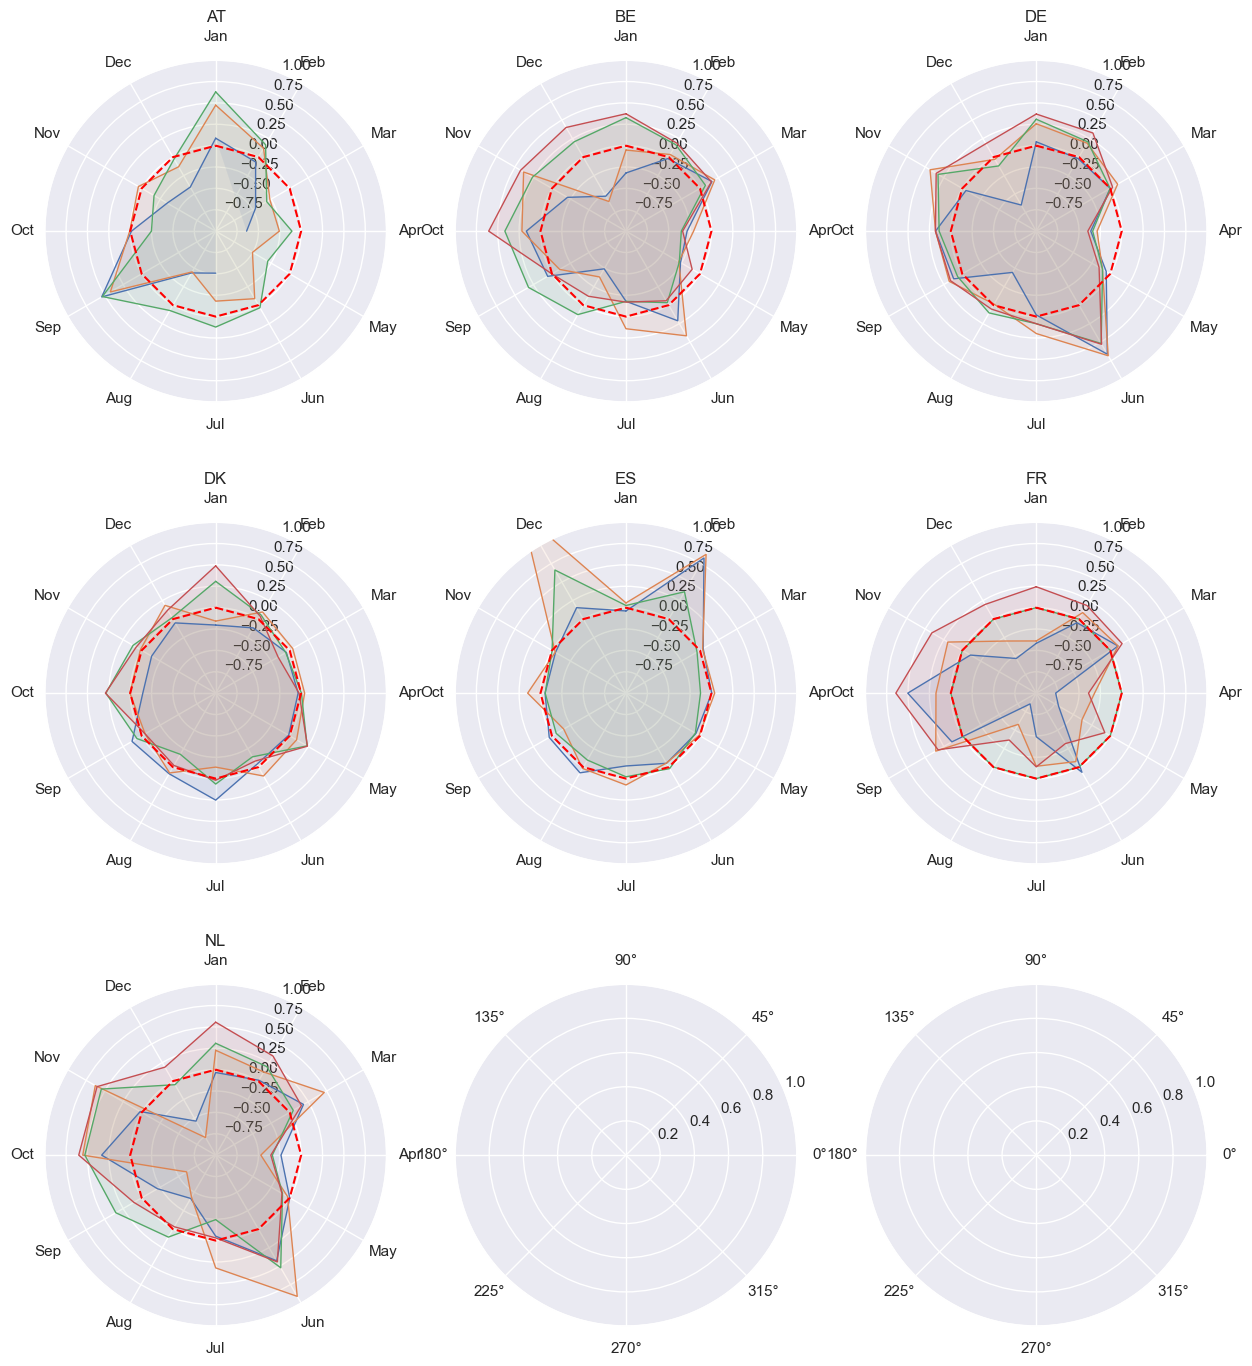

In [880]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Prepare data
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_values = analysis_df.columns[2:]
analysis_df[month_values] = analysis_df[month_values].fillna(0) 

# Colors for different plant labels
colors = plt.cm.viridis(np.linspace(0, 1, len(analysis_df['generation_type'].unique())))

# Create a function to plot radar chart
def plot_radar_chart(ax, df, title):
    labels = months
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  
    
    ax.set_title(title)
    
    for idx, row in df.iterrows():
        row_values = row[month_values].tolist()
        row_values += row_values[:1]
        ax.plot(angles, row_values, linewidth=1, linestyle='solid', label=row['generation_type'])
        ax.fill(angles, row_values, alpha=0.1)
        
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_ylim(-1,1)
    # Red dashed circle on the 0 line
    ax.plot(angles, [0] * (num_vars + 1), linestyle='dashed', color='red')
  

# ... [same code as before]

# Create subplots for each country and plot radar charts
countries = analysis_df['country_code'].unique()
num_countries = len(countries)
num_cols = min(3, num_countries)
num_rows = (num_countries - 1) // num_cols + 1
fig, axes = plt.subplots(figsize=(15, 8 * num_rows), nrows=num_rows, ncols=num_cols, subplot_kw=dict(polar=True))

if num_countries == 1:
    axes = [axes]

for i, country in enumerate(countries):
    ax = axes[i // num_cols] if num_rows == 1 else axes[i // num_cols, i % num_cols]
    subset_df = analysis_df[analysis_df['country_code'] == country]
    plot_radar_chart(ax, subset_df, country)

plt.subplots_adjust(hspace=-0.5)  # Adjust vertical spacing here

# Add legend
#handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper right')
plt.show()


##### 4.2.2.2 Sharpe Ratio Analysis

In [1068]:
INDEX = ['year','month']
analysis_df = portfolio_df_pivot[portfolio_df_pivot['ppa_structure'] == 'revenue_dynamic']
analysis_df = analysis_df.groupby(['country_code','generation_type','year']).agg({'revenue': ['mean','var', 'std'], 'optimal_revenue': ['mean','var', 'std']}).reset_index()

analysis_df['revenue_sharpe'] = analysis_df['revenue']['mean'] / analysis_df['revenue']['std'] 
analysis_df['optimal_revenue_sharpe'] = analysis_df['optimal_revenue']['mean'] / analysis_df['optimal_revenue']['std'] 

# Pivot the dataframe, rows are the months, columns are the plants. It is important that we can see revenue_sharpe and optimal_revenue_sharpe next to each other
analysis_df = analysis_df.pivot(index=['country_code'], columns=['year','generation_type'], values=['revenue_sharpe', 'optimal_revenue_sharpe'])
# Rearrange the columns so 'revenue_sharpe' and 'optimal_revenue_sharpe' are next to each other for each 'plant_label'
analysis_df = analysis_df.swaplevel(0, 2, axis=1).sort_index(axis=1)

analysis_df = analysis_df.transpose()
# Format 2f

# 6 generation types fit on one latex page, so we need to split the dataframe and then cbind them together
steps = 6*2*5
analysis_dfs = []
for i in range(0, len(analysis_df), steps):
    _temp = analysis_df.iloc[i:i+steps].reset_index()
    _temp.iloc[:,2:] = _temp.iloc[:,2:].round(2)

    if i > 0:
        # Get rid of first the second and third column, keep the first column
        discard_columns = [1,2]
        _temp = _temp.drop(_temp.columns[discard_columns], axis=1)        
        
    else:
        # Flip the first column and put it on position 3
        # Dynamically switch the column order
        cols = _temp.columns.tolist()
        cols = cols[1:3] + [cols[0]] + cols[3:]
        _temp = _temp[cols]                

    analysis_dfs.append(_temp)

        
analysis_df = pd.concat(analysis_dfs, axis=1).style
# Don't print index
analysis_df = analysis_df.hide_index()

print(analysis_df.to_latex(convert_css=True, clines= "skip-last;data", hrules = False, multicol_align = 'c', multirow_align='c'))

\begin{tabular}{rllrrrrrrrlrrrrrrrlrrrrrrrlrrrrrrr}
year & level_2 & generation_type & AT & BE & DE & DK & ES & FR & NL & generation_type & AT & BE & DE & DK & ES & FR & NL & generation_type & AT & BE & DE & DK & ES & FR & NL & generation_type & AT & BE & DE & DK & ES & FR & NL \\
2018 & optimal_revenue_sharpe & biomass & 9.100000 & 3.420000 & 6.060000 & nan & 5.090000 & 3.190000 & 0.260000 & fossil_oil & nan & 0.210000 & 1.890000 & nan & 5.240000 & 1.780000 & nan & nuclear & nan & 3.290000 & 4.420000 & nan & 4.960000 & 4.940000 & 1.980000 & wind_offshore & nan & 1.170000 & 1.630000 & nan & nan & nan & 1.480000 \\
2018 & revenue_sharpe & biomass & 9.860000 & 3.640000 & 6.420000 & nan & 4.790000 & 3.190000 & 0.100000 & fossil_oil & nan & 0.210000 & 1.740000 & nan & 5.220000 & 1.630000 & nan & nuclear & nan & 3.220000 & 4.510000 & nan & 4.610000 & 5.040000 & 1.910000 & wind_offshore & nan & 1.150000 & 1.590000 & nan & nan & nan & 1.520000 \\
2019 & optimal_revenue_sharpe & biomass & 3.76

#### 4.2.2 Portfolio Time Series (asset)

In [257]:
# To avoid issues with DK and DE, we average the prices by country instead of using bidding zones
_temp = hourly_entsoe_day_ahead_prices.groupby(['timestamp', 'country_code']).agg({
    'price' : 'mean',
    'price_fixed' : 'mean',
    **{f'price_{ppa_name}' : 'mean' for ppa_name in ppa_functions.keys()}
})
hourly_entsoe_asset_revenue = hourly_entsoe_unit_generation.merge(_temp, on = ['timestamp', 'country_code'])

for ppa_name, ppa_func in ppa_functions.items():
    hourly_entsoe_asset_revenue[f"revenue_{ppa_name}"] = hourly_entsoe_asset_revenue[f"price_{ppa_name}"] * hourly_entsoe_asset_revenue['generation'] 
    
# Turn to daily revenues
hourly_entsoe_asset_revenue['date'] = hourly_entsoe_asset_revenue['timestamp'].dt.date
daily_entsoe_asset_revenue = hourly_entsoe_asset_revenue.groupby(['date', 'plant_type','plant_label','eic_code','country_code']).agg(
    {'price' : 'mean', 'price_fixed' : 'mean', 
     'generation' : 'sum', 
    # ppa_functions
    **{f'revenue_{ppa_name}' : 'sum' for ppa_name in ppa_functions.keys()}
    }).reset_index()

daily_entsoe_asset_revenue['date'] = pd.to_datetime(daily_entsoe_asset_revenue['date'])
daily_entsoe_asset_revenue.head(5)

date  plant_type   plant_label          eic_code country_code  \
0 2017-12-31     Biomass  RODENHUIZE 4  22WRODENH150213L           BE   
1 2017-12-31  Fossil Gas     Diemen 34  49W0000000000172           NL   
2 2017-12-31     Nuclear   Borssele 30  49W000000000055V           NL   
3 2018-01-01     Biomass  RODENHUIZE 4  22WRODENH150213L           BE   
4 2018-01-01  Fossil Gas     Diemen 34  49W0000000000172           NL   

       price  price_fixed  generation  revenue_dynamic  
0  16.381667    18.540000      3573.0     66243.419864  
1  29.051250    30.700000      6203.0    190432.098817  
2  29.051250    30.700000     11684.0    358698.797771  
3   4.626667    47.639999        93.0      4430.519943  
4  29.432500    46.375000      7474.0    346606.750000

In [258]:
# Merge the revenue and temperature indices
portfolio_df = pd.merge(daily_entsoe_asset_revenue, temperature_indices_df, left_on=['date'], right_on=[ 'date'], how='inner')
portfolio_df_pivot = portfolio_df.melt(id_vars=[col for col in portfolio_df.columns if not col.startswith('revenue_')], var_name='ppa_structure', value_name='revenue')
portfolio_df_pivot['revenue'] = pd.to_numeric(portfolio_df_pivot['revenue'], errors='coerce')
portfolio_df_pivot['month'] = portfolio_df_pivot['date'].dt.month
portfolio_df_pivot['year'] = portfolio_df_pivot['date'].dt.year
portfolio_df_pivot.head(5)


date  plant_type   plant_label          eic_code country_code  \
0 2018-01-01     Biomass  RODENHUIZE 4  22WRODENH150213L           BE   
1 2018-01-01  Fossil Gas     Diemen 34  49W0000000000172           NL   
2 2018-01-01     Nuclear   Borssele 30  49W000000000055V           NL   
3 2018-01-02     Biomass  RODENHUIZE 4  22WRODENH150213L           BE   
4 2018-01-02  Fossil Gas     Diemen 34  49W0000000000172           NL   

       price  price_fixed  generation  strip_ot_continuous_payoff_aarhus_dk  \
0   4.626667    47.639999        93.0                              0.000000   
1  29.432500    46.375000      7474.0                              0.000000   
2  29.432500    46.375000     11686.0                              0.000000   
3  32.110833    47.639999      3214.0                              0.547287   
4  37.216250    46.375000      8556.0                              0.547287   

   strip_ot_continuous_payoff_amsterdam_nl  ...  \
0                                 0.000000  ...   
1                                 0.000000  ...   
2                                 0.000000  ...   
3                                17.289827  ...   
4                                17.289827  ...   

   strip_ot_continuous_payoff_milan_it  strip_ot_continuous_payoff_paris_fr  \
0                             0.000000                             0.000000   
1                             0.000000                             0.000000   
2                             0.000000                             0.000000   
3                            45.209052                            -3.566031   
4                            45.209052                            -3.566031   

   strip_ot_continuous_payoff_porto_pt  strip_ot_continuous_payoff_rome_it  \
0                             0.000000                            0.000000   
1                             0.000000                            0.000000   
2                             0.000000                            0.000000   
3                            32.086877                           -0.509182   
4                            32.086877                           -0.509182   

   strip_ot_continuous_payoff_rotterdam_nl  \
0                                 0.000000   
1                                 0.000000   
2                                 0.000000   
3                                18.329784   
4                                18.329784   

   strip_ot_continuous_payoff_vienna_at    ppa_structure        revenue  \
0                              0.000000  revenue_dynamic    4430.519943   
1                              0.000000  revenue_dynamic  346606.750000   
2                              0.000000  revenue_dynamic  541938.250000   
3                              3.804876  revenue_dynamic  153114.958038   
4                              3.804876  revenue_dynamic  396784.500000   

   month  year  
0      1  2018  
1      1  2018  
2      1  2018  
3      1  2018  
4      1  2018  

[5 rows x 30 columns]

In [259]:
portfolio_df_pivot['derivatives'] = None
portfolio_df_pivot['optimal_weights'] = None
portfolio_df_pivot['optimal_revenue'] = None

for tso_country, derivative_constraint in DERIVATIVES_COUNTRY_CONSTRAINTS.items():
    # Select the temporary data for the country
    print(tso_country)
    _temp = portfolio_df_pivot[portfolio_df_pivot['country_code'] == tso_country]
    
    _temperature_derivatives = [col for col in _temp.columns if col in derivative_constraint['temperature']]
    _wind_derivatives = [col for col in _temp.columns if col in derivative_constraint['wind']]
    
    _derivatives = _temperature_derivatives + _wind_derivatives
    # Iterate over the generation_type 
    for _asset, _asset_df in _temp.groupby('eic_code'):
        #if _generation_type != 'fossil_gas':
        #    continue
        for _ppa_structure, _ppa_structure_df in _asset_df.groupby('ppa_structure'):
            #print(f"{_asset}: {_ppa_structure} ({tso_country})")
            # Iterate over every month, year combination
            for _month, _month_df in _ppa_structure_df.groupby('month'):
                # Train the model on the data before the in-sample date, we do not have it rolling so nothing is updated after the in-sample date
                _training_df = _month_df[_month_df['date'] < IN_SAMPLE_DATE]
                # Starting point is simply 0 for all derivatives
                x0 = np.zeros(len(_derivatives))
                bounds = [(None, None) for _ in range(len(_derivatives))]
                optimal_weight = minimize(optim_func, x0=x0, args=(_training_df, 'revenue', _derivatives), method='Nelder-Mead', tol=1e-6, bounds=bounds)
                # Create a new DataFrame with the derivatives and optimal weights
                result_df = pd.DataFrame({
                    'derivatives': [_derivatives],
                    'optimal_weights': [optimal_weight.x],
                    'optimal_revenue': np.dot(optimal_weight.x, _month_df[_derivatives].values.T) + _month_df['revenue'].values,
                }, index=_month_df.index)

                # Set the new DataFrame to the desired location in portfolio_df_pivot
                portfolio_df_pivot.loc[_month_df.index, ['derivatives', 'optimal_weights', 'optimal_revenue']] = result_df.values

NL
BE
DE
DK
FR
ES
PT
AT
IT


##### 4.2.2.1 Weight Analysis

In [263]:
portfolio_df_pivot[portfolio_df_pivot['ppa_structure'] == 'revenue_dynamic']

date     plant_type          plant_label          eic_code  \
0    2018-01-01        Biomass         RODENHUIZE 4  22WRODENH150213L   
1    2018-01-01     Fossil Gas            Diemen 34  49W0000000000172   
2    2018-01-01        Nuclear          Borssele 30  49W000000000055V   
3    2018-01-02        Biomass         RODENHUIZE 4  22WRODENH150213L   
4    2018-01-02     Fossil Gas            Diemen 34  49W0000000000172   
...         ...            ...                  ...               ...   
7611 2023-05-31   Wind Onshore               GECAMA  18W000000000NXBH   
7612 2023-06-01        Biomass         RODENHUIZE 4  22WRODENH150213L   
7613 2023-06-01          Solar              NBALBOA  18W000000000H02A   
7614 2023-06-01  Wind Offshore  Seastar Offshore WP  22W20200608D---U   
7615 2023-06-01   Wind Onshore               GECAMA  18W000000000NXBH   

     country_code      price  price_fixed  generation  \
0              BE   4.626667    47.639999        93.0   
1              NL  29.432500    46.375000      7474.0   
2              NL  29.432500    46.375000     11686.0   
3              BE  32.110833    47.639999      3214.0   
4              NL  37.216250    46.375000      8556.0   
...           ...        ...          ...         ...   
7611           ES  87.742499    84.750000       246.0   
7612           BE  70.099998    70.099998         0.0   
7613           ES  87.000000    87.000000         0.0   
7614           BE  70.099998    70.099998       168.0   
7615           ES  87.000000    87.000000         0.0   

      strip_ot_continuous_payoff_aarhus_dk  \
0                                 0.000000   
1                                 0.000000   
2                                 0.000000   
3                                 0.547287   
4                                 0.547287   
...                                    ...   
7611                             -4.429372   
7612                              0.000000   
7613                              0.000000   
7614                              0.000000   
7615                              0.000000   

      strip_ot_continuous_payoff_amsterdam_nl  ...  \
0                                    0.000000  ...   
1                                    0.000000  ...   
2                                    0.000000  ...   
3                                   17.289827  ...   
4                                   17.289827  ...   
...                                       ...  ...   
7611                               -51.185086  ...   
7612                                 0.000000  ...   
7613                                 0.000000  ...   
7614                                 0.000000  ...   
7615                                 0.000000  ...   

      strip_ot_continuous_payoff_rome_it  \
0                               0.000000   
1                               0.000000   
2                               0.000000   
3                              -0.509182   
4                              -0.509182   
...                                  ...   
7611                          -36.934329   
7612                            0.000000   
7613                            0.000000   
7614                            0.000000   
7615                            0.000000   

      strip_ot_continuous_payoff_rotterdam_nl  \
0                                    0.000000   
1                                    0.000000   
2                                    0.000000   
3                                   18.329784   
4                                   18.329784   
...                                       ...   
7611                               -50.446450   
7612                                 0.000000   
7613                                 0.000000   
7614                                 0.000000   
7615                                 0.000000   

      strip_ot_continuous_payoff_vienna_at    ppa_structure        revenue  \
0                                 0.000000  revenue

In [261]:
analysis_df = portfolio_df_pivot[portfolio_df_pivot['ppa_structure'] == 'revenue_dynamic']
analysis_df['optimal_weights'] = analysis_df['optimal_weights'].apply(tuple)

analysis_df = analysis_df.groupby(['plant_label','plant_type', 'country_code', 'month']).agg({
    # optimal weights first observation
    'optimal_weights' : 'first',
    'generation' : 'mean'
}).reset_index()

# Pivot on month, and extract the optimal weights
analysis_df['optimal_weights'] = analysis_df['optimal_weights'].apply(lambda x: x[0])
analysis_df['optimal_weights'] = analysis_df['optimal_weights'] / analysis_df['generation']

analysis_df = analysis_df.pivot_table(index=['plant_label','plant_type', 'country_code'], columns='month', values='optimal_weights').reset_index()

# analysis_df['color'] = analysis_df['plant_type'].apply(lambda x: 
#     {
#     # Fossil fuels in earthy/grey tones
#     'Fossil Brown coal/Lignite': '#755C40',  # brownish-grey for brown coal
#     'Fossil Coal-derived gas': '#5A5A5A',  # slate grey for coal-derived gas
#     'Fossil Gas': '#93734A',  # muted gold for natural gas
#     'fossil (hard coal)': '#434343',  # darker grey for hard coal
#     'fossil (oil)': '#3E2A1B',  # very dark brown for oil
    
#     # Renewables in vibrant/fresh tones
#     'Biomass': '#4E7325',  # dark green for organic matter
#     'geothermal': '#CC4D00',  # deep orange for earth heat
#     'Solar': '#DB9500',  # deep gold for sun
#     'Wind Offshore': '#00617A',  # deep teal for oceanic winds
#     'Wind Onshore': '#00905E',  # forest green for onshore winds
#     'other (renewable)': '#7DAA52',  # muted green for other renewables
    
#     # Hydro in shades of blue
#     'Hydro Pumped Storage': '#0B3D6E',  # deep navy for stored water
#     'Hydro Run-of-river and poundage': '#1E6BB2',  # medium blue for running rivers
#     'Hydro Water Reservoir': '#3E91D3',  # sky blue for reservoirs
    
#     # Miscellaneous
#     'Nuclear': '#A200A6',  # muted magenta for nuclear
#     'other': '#9E9E9E',  # muted silver for other categories
#     'Waste': '#732E20',  # dark rust for waste
#     }[x]
#     )


analysis_df.sort_values('plant_type', inplace=True)
analysis_df.head(6)

month          plant_label     plant_type country_code         1         2  \
4             RODENHUIZE 4        Biomass           BE -0.124831 -0.031048   
1                Diemen 34     Fossil Gas           NL  0.012654  0.119529   
0              Borssele 30        Nuclear           NL  0.141221  0.125406   
3                  NBALBOA          Solar           ES  0.093617 -0.178116   
5      Seastar Offshore WP  Wind Offshore           BE  0.760801  0.148787   
2                   GECAMA   Wind Onshore           ES -0.121222 -0.390275   

month         3         4         5         6         7         8         9  \
4      0.168911 -0.167878 -0.000072  0.552515 -0.183734 -0.255242  0.212949   
1      0.080703 -0.357715 -0.260424  0.903709 -0.414504 -0.696755  0.000531   
0      0.117904 -0.033343 -0.232783  2.025210 -0.141334 -0.248772 -0.204477   
3     -0.451153 -0.461676 -0.311005  0.072124  0.114606 -0.103260  0.240638   
5      0.123880  0.612312 -0.590139  0.133561 -2.471120  0.268985  1.150049   
2      0.400947 -0.513466 -0.020065       NaN       NaN -0.195778  1.626095   

month        10        11        12  
4      0.669084 -0.227703 -0.310703  
1      0.676938 -0.126003 -0.347408  
0      0.517021  0.081435 -0.248194  
3      0.393146 -0.944695  0.161368  
5      0.836130 -0.234461  0.253064  
2      1.777889  0.468416  0.899358

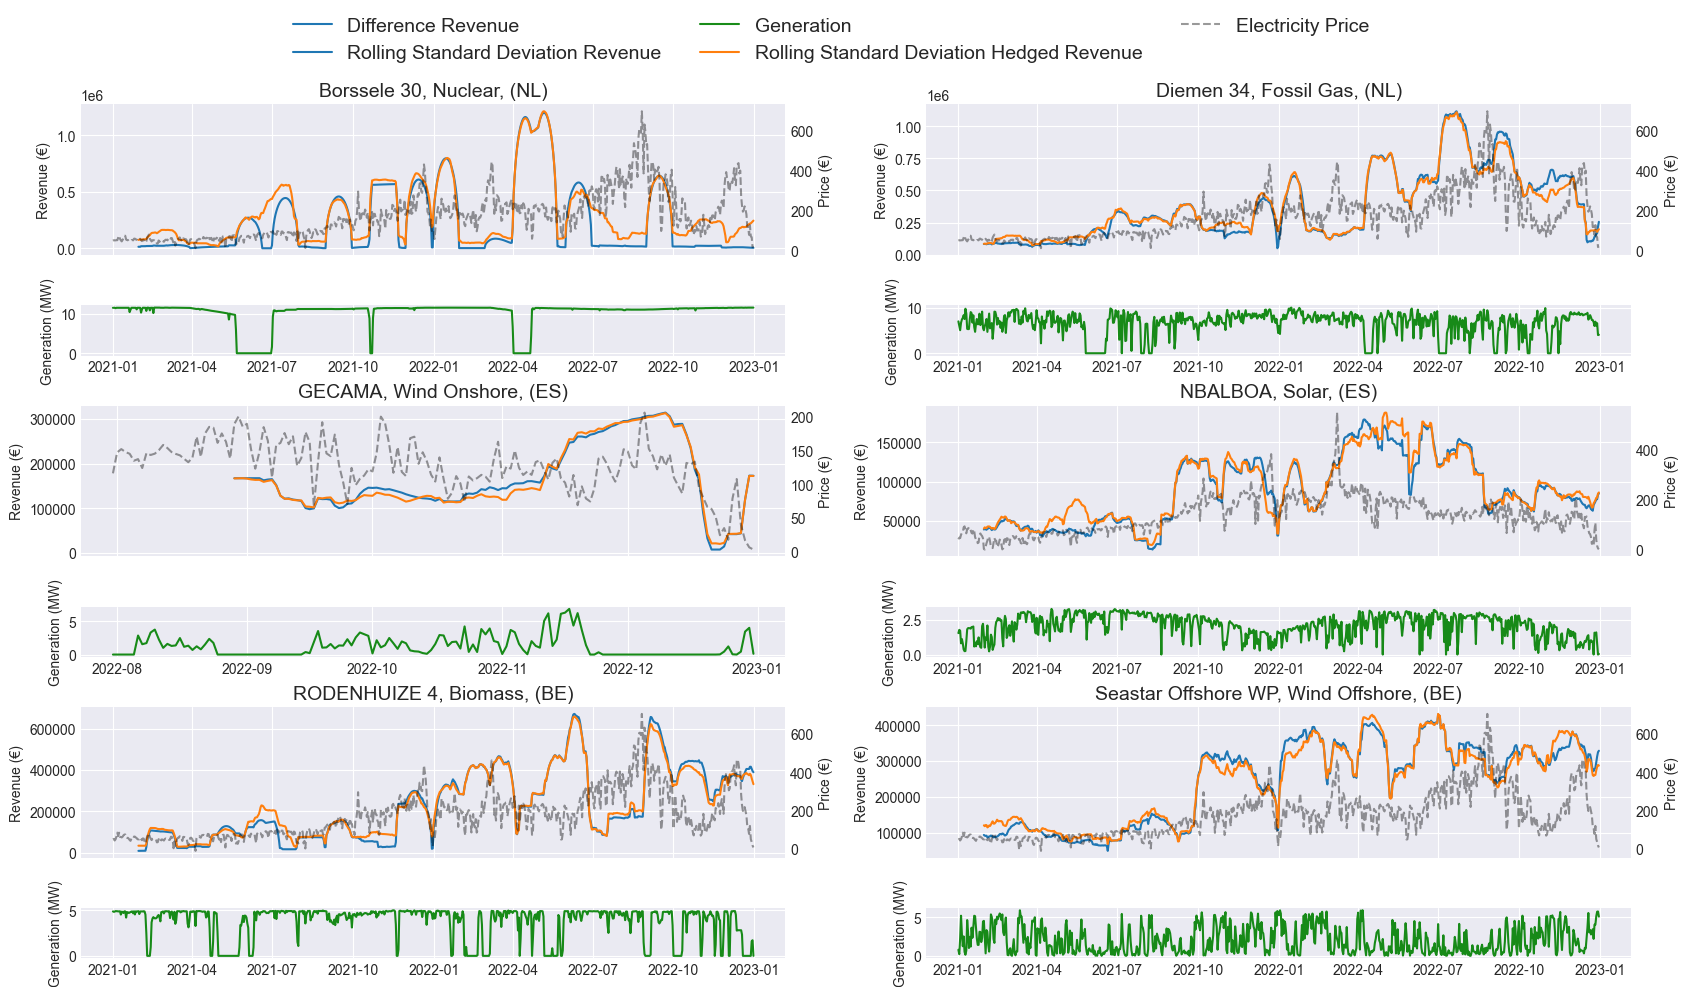

In [276]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

analysis_df = portfolio_df_pivot[portfolio_df_pivot['ppa_structure'] == 'revenue_dynamic']
analysis_df['optimal_weights'] = analysis_df['optimal_weights'].apply(tuple)
# Time period between 2021-2023
analysis_df = analysis_df[(analysis_df['date'] < '2023-01-01') & (analysis_df['date'] >= '2021-01-01')]

analysis_df['diff_revenue'] =  analysis_df['revenue'] - analysis_df['optimal_revenue']

# Rolling variance of revenue
analysis_df['rolling_revenue_var_30'] = analysis_df.groupby(['plant_label', 'plant_type', 'country_code','ppa_structure'])['revenue'].transform(lambda x: x.rolling(30).std())
analysis_df['rolling_optimal_revenue_var_30'] = analysis_df.groupby(['plant_label', 'plant_type', 'country_code','ppa_structure'])['optimal_revenue'].transform(lambda x: x.rolling(30).std())

num_countries = 4
# Define the grid layout
gs = gridspec.GridSpec(num_countries*2, 2, height_ratios=[3, 1] * num_countries, hspace = 0.50)  # 3:1 height ratio between line plot and bar chart
fig = plt.figure(figsize=(20, 15))

idx = -1
for i, (_asset_name, _asset_df) in enumerate(analysis_df.groupby('plant_label')):
        if i % 2 == 0:
            j = 0
            idx += 1

        else:
            j = 1
        plant_type = _asset_df['plant_type'].iloc[0]
        country_code = _asset_df['country_code'].iloc[0]
        
        # Create the line plot on a custom-sized subplot
        ax1 = plt.subplot(gs[2*idx, j])
        #line1, = ax1.plot(_asset_df['date'], _asset_df['diff_revenue'], label='Difference Revenue')
        line2, = ax1.plot(_asset_df['date'], _asset_df['rolling_revenue_var_30'], label='Rolling Standard Deviation Revenue')
        line4, = ax1.plot(_asset_df['date'], _asset_df['rolling_optimal_revenue_var_30'], label='Rolling Standard Deviation Hedged Revenue')

        #line3, = ax1.plot(_asset_df['date'], _asset_df['diff_revenue'], label='Difference Revenue')

        #line2, = ax1.plot(_asset_df['date'], _asset_df['optimal_revenue'], label='Hedged Revenue')
        ax1.set_ylabel('Revenue (€)')
        # Plot the temperature data on a secondary axis
        ax2 = ax1.twinx()
        line5, = ax2.plot(_asset_df['date'], _asset_df['price'], color='black', label='Electricity Price', alpha = 0.4, linestyle = '--')
        ax2.set_ylabel('Price (€)')
        
        # Create the bar chart on a custom-sized subplot below the line plot, sharing the x-axis
        ax3 = plt.subplot(gs[2*idx+1, j], sharex=ax1)
        line3, = ax3.plot(_asset_df['date'], _asset_df['generation']/1000, label='Generation', color = 'green', alpha = 0.9)
        ax3.set_ylabel('Generation (MW)')
        # Set title for the combined plot and hide grid for the secondary axis
        ax1.set_title(f'{_asset_name}, {plant_type}, ({country_code})', fontsize=14)
        ax2.grid(False, axis='y')
        ax2.grid(False, axis='x')

        # Hide x-ticks for ax1 since it's shared with ax3
        for label in ax1.get_xticklabels():
            label.set_visible(False)

# Add legend to the figure outside of the plots
lines = [line1, line2, line3, line4, line5]
labels = [l.get_label() for l in lines]
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=3, fontsize=14)

plt.tight_layout()
plt.show()

In [262]:
# Tabular stuff Category

# (1): Dynamic Sharpe Ratios
# (2): Dynamic Weight

analysis_df = portfolio_df_pivot[portfolio_df_pivot['ppa_structure'] == 'revenue_dynamic']
analysis_df['optimal_weights'] = analysis_df['optimal_weights'].apply(tuple)

# For each generation type
for _generation_type, _generation_type_df in analysis_df.groupby('plant_type'):
    _generation_type_df['year'] = 'fk'
    print(f"Generation Type: {_generation_type}")
    # (1) Dynamic Sharpe Ratios
    stats_df = _generation_type_df.groupby(['plant_label','year']).agg({'revenue': ['mean','var', 'std','sum'], 'optimal_revenue': ['mean','var', 'std','sum']}).reset_index()
    stats_df['revenue_sharpe'] = stats_df['revenue']['mean'] / stats_df['revenue']['std'] 
    stats_df['optimal_revenue_sharpe'] = stats_df['optimal_revenue']['mean'] / stats_df['optimal_revenue']['std'] 
    
    stats_df['variance_reduction'] = stats_df.apply(
        lambda row: np.nan if row['revenue']['var'] == 0 else (1- row['optimal_revenue']['var'] / row['revenue']['var'])*100,
        axis=1
    )
    stats_df['cost_of_hedging'] = stats_df.apply(
        lambda row: np.nan if row['revenue']['sum'] == 0 else (row['optimal_revenue']['sum'] - row['revenue']['sum'])/row['revenue']['sum']*100,
        axis=1
    )

    values = ['revenue_sharpe', 'optimal_revenue_sharpe', 'variance_reduction', 'cost_of_hedging']
        
    stats_df = stats_df.pivot(index=['year'], columns=['plant_label'], values=values)
    # Reset the column levels so they are combined into a single level
    stats_df.columns = stats_df.columns.map('_'.join).str.strip('_')
    # Melt the DataFrame to long form
    stats_df = stats_df.reset_index().melt(id_vars=['year'], value_vars=[col for col in stats_df.columns if col != 'year'])
    # Create a new column to differentiate between revenue_sharpe and optimal_revenue_sharpe
    stats_df['score'] = stats_df['variable'].str.extract(f'({"|" .join(values)})')
    stats_df['plant_label'] = stats_df['variable'].str.replace(f'({"|" .join(values)})', '')
    # Pivot the DataFrame to get it back to wide form, but in the desired format
    stats_df = stats_df.pivot_table(index=[ 'year', 'score'], columns='plant_label', values='value')
    # Format 3f
    stats_df = stats_df.applymap(lambda x: f"{x:.3f}")
    print(stats_df)
    
    # (2): Dynamic Weight
    
    weights_df = _generation_type_df.groupby(['plant_label', 'month']).agg({
        # optimal weights first observation
        'optimal_weights' : 'first',
        'generation' : 'mean'
    }).reset_index()

    # Pivot on month, and extract the optimal weights
    weights_df['optimal_weights'] = weights_df['optimal_weights'].apply(lambda x: x[0])
    weights_df['optimal_weights'] = weights_df['optimal_weights'] 

    weights_df = weights_df.pivot_table(index=['month'], columns='plant_label', values='optimal_weights')
    # Format 3f
    weights_df = weights_df.applymap(lambda x: f"{x:.3f}")
    print(weights_df)
    


Generation Type: Biomass
plant_label                 _RODENHUIZE 4
year score                               
fk   cost_of_hedging               -0.186
     optimal_revenue_sharpe         0.873
     revenue_sharpe                 0.868
     variance_reduction             1.578
plant_label RODENHUIZE 4
month                   
1               -544.633
2                -90.610
3                495.017
4               -472.729
5                 -0.148
6               2376.306
7               -827.815
8              -1099.683
9                902.294
10              1798.929
11              -978.129
12             -1205.835
Generation Type: Fossil Gas
plant_label                 _Diemen 34
year score                            
fk   cost_of_hedging            -0.874
     optimal_revenue_sharpe      1.074
     revenue_sharpe              1.061
     variance_reduction          4.149
plant_label  Diemen 34
month                 
1               99.827
2              938.214
3              612.